### Newsbot to write a daily AI news summary using langgraph
- Scrape a list of sources from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary


In [2]:
# import sys
# del sys.modules['ainb_webscrape']


In [3]:
from datetime import datetime
import os
import yaml
import dotenv
import sqlite3
import unicodedata
import json
from collections import Counter
import yaml
from typing import Any, List, Dict, TypedDict, Annotated
import logging

import operator
import pickle


from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain.memory import ChatMessageHistory
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.aiosqlite import AsyncSqliteSaver
from langchain.tools import BaseTool, StructuredTool, tool
from langchain_community.chat_models import ChatOllama
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser, StrOutputParser
from langchain.callbacks.base import AsyncCallbackHandler, BaseCallbackHandler
from langchain_core.outputs import LLMResult

from langgraph.graph import StateGraph, END

import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN

# import bs4
from bs4 import BeautifulSoup
import requests
from urllib.parse import urljoin, urlparse

import multiprocessing
from concurrent.futures import ThreadPoolExecutor, as_completed
import asyncio
import aiohttp

from IPython.display import HTML, Image, Markdown, display
import markdown

import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText

from openai import OpenAI
VERBOSE=1
from ainb_const import (DOWNLOAD_DIR, LOWCOST_MODEL, MODEL, CANONICAL_TOPICS,
                        SOURCECONFIG, FILTER_PROMPT, TOPIC_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT, FINAL_SUMMARY_PROMPT, TOP_CATEGORIES_PROMPT,
                        MAX_INPUT_TOKENS, MAX_OUTPUT_TOKENS, MAX_RETRIES, TEMPERATURE, SQLITE_DB)
from ainb_utilities import (log, delete_files, filter_unseen_urls_db, insert_article,
                            nearest_neighbor_sort, agglomerative_cluster_sort, traveling_salesman_sort_scipy,
                            unicode_to_ascii, send_gmail)
from ainb_webscrape import (get_driver, quit_drivers, launch_drivers, get_file, get_url, parse_file,
                            get_og_tags, get_path_from_url, trimmed_href, process_source_queue_factory,
                            process_url_queue_factory, get_google_news_redirects, DRIVERS)
from ainb_llm import (paginate_df, process_pages, fetch_pages, fetch_openai, fetch_all_summaries,
                      fetch_openai_summary, trunc_tokens, categorize_headline, categorize_df, clean_topics)


import asyncio
# need this to run async in jupyter since it already has an asyncio event loop running
import nest_asyncio
nest_asyncio.apply()


In [4]:
model = ChatOpenAI(model=MODEL)


In [5]:
prompt_inputs = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

system_template = 'Translate the following into {language}:'
user_template = 'Listen to me. You are {adjective1}. You are {adjective2} and I love you.'

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

start_time = datetime.now()
for tpl in prompt_inputs:
    response = ""
    # stream tokens as they are generated
    for r in chain.stream(tpl):
        print(r, end="")
        response += r
end_time = datetime.now()

difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")

# response


2024-07-18 20:44:51,200 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.

2024-07-18 20:44:51,843 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.

2024-07-18 20:44:52,618 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Escúchame. Eres perfecto/a. Eres hermoso/a y te quiero.

2024-07-18 20:44:53,553 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Ascoltami. Sei fantastico. Sei magnifico e ti amo.

2024-07-18 20:44:54,037 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Figyelj rám. Elbűvölő vagy. Lenyűgöző vagy, és szeretlek.

Elapsed seconds: 3.640162


In [6]:
prompt_templates = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

async def async_langchain(chain, input_dict):
    response = await chain.ainvoke(input_dict)
    return response

start_time = datetime.now()
tasks = []
for d in prompt_templates:
    task = asyncio.create_task(async_langchain(chain, d))
    tasks.append(task)
responses = await asyncio.gather(*tasks)
end_time = datetime.now()


difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")
print("\n".join(responses))


2024-07-18 20:44:55,059 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-07-18 20:44:55,086 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-07-18 20:44:55,088 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-07-18 20:44:55,218 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-07-18 20:44:55,390 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Elapsed seconds: 0.938198
Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.
Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.
Escúchame. Eres perfecto. Eres hermoso y te amo.
Ascoltami. Sei fantastico. Sei magnifico e ti amo.
Hallgass rám. Te elbűvölő vagy. Te lenyűgöző vagy, és szeretlek.


In [7]:
# async against vanilla REST API, a little faster
API_URL = 'https://api.openai.com/v1/chat/completions'

headers = {
    'Content-Type': 'application/json',
    'Authorization': f'Bearer {os.getenv("OPENAI_API_KEY")}',
}

async def fetch_openai_async(session, payload):
    async with session.post(API_URL, headers=headers, json=payload) as response:
        response_json = await response.json()
        return response_json

start_time = datetime.now()
tasks = []
responses = []

async with aiohttp.ClientSession() as session:
    for tpl in prompt_templates:
        prompt= """Translate the following into {language}:
Listen to me. You are {adjective1}. You are {adjective2} and I love you.""".format(**tpl)

        payload = {"model":  MODEL,
                   "messages": [{"role": "user",
                                 "content": prompt
                                }],
                  }


        task = asyncio.create_task(fetch_openai_async(session, payload))
        tasks.append(task)

    responses = await asyncio.gather(*tasks)

end_time = datetime.now()
difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")

print("\n".join([r['choices'][0]['message']['content'] for r in responses]))




Elapsed seconds: 0.962233
Écoute-moi. Tu es parfait(e). Tu es beau/belle et je t'aime.
Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.
Escúchame. Eres perfecto/a. Eres hermoso/a y te amo.
Ascoltami. Sei fantastico. Sei magnifico e ti amo.
Hallgass rám. Elbűvölő vagy. Lélegzetelállító vagy, és szeretlek.


In [8]:
class AgentState(TypedDict):
    AIdf: pd.DataFrame        #  dataframe of the current working set of headlines
    sources: dict             #  sources to scrap
    sources_reverse: dict     #  map file names to sources
    topic_counts: Counter     #  aggregate counts of topics in AIdf
    headline_str: str         #  headline text email
    bullets: str              #  bullet point summary email
    summary: str              #  final summary
    # message thread with OpenAI
    messages: Annotated[list[AnyMessage], operator.add]


In [9]:
# Initialize reading configurations from YAML file
def fn_initialize(state: AgentState) -> AgentState:
    """
    Initializes the agent state by loading source configurations from a YAML file.

    Args:
        state (AgentState): The current state of the agent.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        AgentState: The updated state of the agent.

    Raises:
        yaml.YAMLError: If there is an error while loading the YAML file.

    """

    #  load sources to scrape from sources.yaml
    with open(SOURCECONFIG, "r") as stream:
        try:
            state['sources'] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

    log(f"Loaded {len(state['sources'])} sources from {SOURCECONFIG}")

    # make a reverse dict to map file titles to source names
    state['sources_reverse'] = {}
    for k, v in state['sources'].items():
        log(f"{k} -> {v['url']} -> {v['title']}.html")
        v['sourcename'] = k
        # map filename (title) to source name
        state['sources_reverse'][v['title']] = k

    log(f"Mapped {len(state['sources_reverse'])} source page titles to sources")

    return state

test_state = AgentState()
fn_initialize(test_state)


2024-07-18 20:44:56,403 - AInewsbot - INFO - Loaded 17 sources from sources.yaml
2024-07-18 20:44:56,404 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-07-18 20:44:56,405 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/technology -> Bloomberg Technology - Bloomberg.html
2024-07-18 20:44:56,405 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Tech - Business Insider.html
2024-07-18 20:44:56,405 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> Technology.html
2024-07-18 20:44:56,406 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Discover and Add New Feedly AI Feeds.html
2024-07-18 20

{'sources': {'Ars Technica': {'include': ['^https://arstechnica.com/(\\w+)/(\\d+)/(\\d+)/'],
   'title': 'Ars Technica',
   'url': 'https://arstechnica.com/',
   'sourcename': 'Ars Technica'},
  'Bloomberg Tech': {'include': ['^https://www.bloomberg.com/news/'],
   'title': 'Bloomberg Technology - Bloomberg',
   'url': 'https://www.bloomberg.com/technology',
   'sourcename': 'Bloomberg Tech'},
  'Business Insider': {'exclude': ['^https://www.insider.com',
    '^https://www.passionfroot.me'],
   'title': 'Tech - Business Insider',
   'url': 'https://www.businessinsider.com/tech',
   'sourcename': 'Business Insider'},
  'FT Tech': {'include': ['https://www.ft.com/content/'],
   'title': 'Technology',
   'url': 'https://www.ft.com/technology',
   'sourcename': 'FT Tech'},
  'Feedly AI': {'exclude': ['^https://feedly.com',
    '^https://s1.feedly.com',
    '^https://blog.feedly.com'],
   'scroll': 5,
   'initial_sleep': 30,
   'title': 'Discover and Add New Feedly AI Feeds',
   'url': 'htt

In [10]:
# scrape sources with selenium and save local files

def fn_scrape_sources(state: AgentState, do_delete=True) -> AgentState:
    """
    Scrapes sources and saves HTML files. 
    If do_delete is True, deletes all files in DOWNLOAD_DIR and scrapes fresh copies.
    If do_delete is False, uses existing files in DOWNLOAD_DIR.
    Uses state["sources"] for config info on sources to scrape
    For each source, saves the current filename to state["sources"][sourcename]['latest']

    Args:
        state (AgentState): The current state of the agent.
        do_delete (bool, optional): Whether to delete files in DOWNLOAD_DIR. Defaults to True.

    Returns:
        AgentState: The updated state of the agent.
    """

    # empty download directory
    if do_delete:
        delete_files(DOWNLOAD_DIR)

        # save each file specified from sources
        num_browsers = 3
        log(f"Saving HTML files using {num_browsers} browsers")

        # Create a queue for multiprocessing and populate it
        queue = multiprocessing.Queue()
        for item in state["sources"].values():
            queue.put(item)

        # Function to take the queue and pop entries off and process until none are left
        # lets you create an array of functions with different args
        callable = process_source_queue_factory(queue)

        saved_pages = launch_drivers(num_browsers, callable)
        for sourcename, file in saved_pages:
            log(f"Downloaded {sourcename} to {file}")
            state['sources'][sourcename]['latest'] = file
    else:   # don't delete, just get list of existing files
        log(f"Web fetch disabled, using existing files in {DOWNLOAD_DIR}")
        # Get the current date
        datestr = datetime.now().strftime("%m_%d_%Y")
        nfiles = 50
        files = [os.path.join(DOWNLOAD_DIR, file)
                 for file in os.listdir(DOWNLOAD_DIR)]
        # filter last 50 files
        files = [file for file in files if os.path.isfile(file)]
        # Sort files by modification time and take top 50
        files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
        file = files[:nfiles]
        # filter files by with today's date ending in .html
        files = [
            file for file in files if datestr in file and file.endswith(".html")]
        log(len(files))
        for file in files:
            log(file)

        saved_pages = []
        for file in files:
            filename = os.path.basename(file)
            # locate date like '01_14_2024' in filename
            position = filename.find(" (" + datestr)
            basename = filename[:position]
            # match to source name
            sourcename = state["sources_reverse"].get(basename)
            if sourcename is None:
                log(f"Skipping {basename}, no sourcename metadata")
                continue
            state["sources"][sourcename]['latest'] = file

    return state

fn_scrape_sources(test_state, do_delete=False)


2024-07-18 20:44:56,422 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2024-07-18 20:44:56,426 - AInewsbot - INFO - 17
2024-07-18 20:44:56,426 - AInewsbot - INFO - htmldata/Technology - The Washington Post (07_18_2024 06_06_47 PM).html
2024-07-18 20:44:56,426 - AInewsbot - INFO - htmldata/Technology - WSJ.com (07_18_2024 06_06_42 PM).html
2024-07-18 20:44:56,426 - AInewsbot - INFO - htmldata/AI News _ VentureBeat (07_18_2024 06_06_40 PM).html
2024-07-18 20:44:56,427 - AInewsbot - INFO - htmldata/Discover and Add New Feedly AI Feeds (07_18_2024 06_06_36 PM).html
2024-07-18 20:44:56,427 - AInewsbot - INFO - htmldata/Artificial Intelligence - The Verge (07_18_2024 06_06_30 PM).html
2024-07-18 20:44:56,427 - AInewsbot - INFO - htmldata/top scoring links _ multi (07_18_2024 06_06_29 PM).html
2024-07-18 20:44:56,427 - AInewsbot - INFO - htmldata/The Register_ Enterprise Technology News and Analysis (07_18_2024 06_06_20 PM).html
2024-07-18 20:44:56,428 - AInewsbot -

{'sources': {'Ars Technica': {'include': ['^https://arstechnica.com/(\\w+)/(\\d+)/(\\d+)/'],
   'title': 'Ars Technica',
   'url': 'https://arstechnica.com/',
   'sourcename': 'Ars Technica',
   'latest': 'htmldata/Ars Technica (07_18_2024 06_05_15 PM).html'},
  'Bloomberg Tech': {'include': ['^https://www.bloomberg.com/news/'],
   'title': 'Bloomberg Technology - Bloomberg',
   'url': 'https://www.bloomberg.com/technology',
   'sourcename': 'Bloomberg Tech',
   'latest': 'htmldata/Bloomberg Technology - Bloomberg (07_18_2024 06_05_16 PM).html'},
  'Business Insider': {'exclude': ['^https://www.insider.com',
    '^https://www.passionfroot.me'],
   'title': 'Tech - Business Insider',
   'url': 'https://www.businessinsider.com/tech',
   'sourcename': 'Business Insider',
   'latest': 'htmldata/Tech - Business Insider (07_18_2024 06_05_15 PM).html'},
  'FT Tech': {'include': ['https://www.ft.com/content/'],
   'title': 'Technology',
   'url': 'https://www.ft.com/technology',
   'sourcename

In [11]:
# extract URLs from saved files
def fn_extract_urls(state: AgentState) -> AgentState:
    """
    Extracts news URLs from the latest HTML files matching the patterns defined in the state['sources'] configuration info.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted URLs stored in state['AIdf'].
    """
    # Parse news URLs and titles from downloaded HTML files
    log("Parsing html files")
    all_urls = []
    for sourcename, sourcedict in state['sources'].items():
        filename = sourcedict.get('latest')
        if not filename:
            log(f"no filename found for {sourcename}")
            continue

        log(sourcename +' -> ' + filename)
        links = parse_file(state['sources'][sourcename])
        log(f"{len(links)} links found")
        all_urls.extend(links)

    log(f"found {len(all_urls)} links")

    # make a pandas dataframe of all the links found
    state["AIdf"] = (
        pd.DataFrame(all_urls)
        .groupby("url")
        .first()
        .reset_index()
        .sort_values("src")[["src", "title", "url"]]
        .reset_index(drop=True)
        .reset_index(drop=False)
        .rename(columns={"index": "id"})
    )

    return state

_ = fn_extract_urls(test_state)


2024-07-18 20:44:56,436 - AInewsbot - INFO - Parsing html files
2024-07-18 20:44:56,438 - AInewsbot - INFO - Ars Technica -> htmldata/Ars Technica (07_18_2024 06_05_15 PM).html
2024-07-18 20:44:56,457 - AInewsbot - INFO - parse_file - found 252 raw links
2024-07-18 20:44:56,461 - AInewsbot - INFO - parse_file - found 28 filtered links
2024-07-18 20:44:56,462 - AInewsbot - INFO - 28 links found
2024-07-18 20:44:56,463 - AInewsbot - INFO - Bloomberg Tech -> htmldata/Bloomberg Technology - Bloomberg (07_18_2024 06_05_16 PM).html
2024-07-18 20:44:56,488 - AInewsbot - INFO - parse_file - found 226 raw links
2024-07-18 20:44:56,491 - AInewsbot - INFO - parse_file - found 27 filtered links
2024-07-18 20:44:56,492 - AInewsbot - INFO - 27 links found
2024-07-18 20:44:56,492 - AInewsbot - INFO - Business Insider -> htmldata/Tech - Business Insider (07_18_2024 06_05_15 PM).html
2024-07-18 20:44:56,514 - AInewsbot - INFO - parse_file - found 310 raw links
2024-07-18 20:44:56,519 - AInewsbot - INFO

In [12]:
before_date="2024-07-18 11:00:00"


In [13]:
# filter and clean URLs for new AI stories

def fn_filter_urls(state: AgentState, before_date="") -> AgentState:
    """
    Filters the URLs in state["AIdf"] to include only those that have not been previously seen,
    and are related to AI according to the response from a ChatGPT prompt.

    Args:
        state (AgentState): The current state of the agent.
        before_date (str, optional): The date before which the URLs should be filtered. Defaults to "".

    Returns:
    
    
        AgentState: The updated state of the agent with the filtered URLs stored in state["AIdf"].

    """    
    # filter to URL not previously seen
    AIdf = filter_unseen_urls_db(state["AIdf"], before_date=before_date)

    if len(AIdf) == 0:
        log("No new URLs, returning")
        return state

    # dedupe identical headlines
    # filter similar titles differing by type of quote or something
    AIdf['title'] = AIdf['title'].apply(unicode_to_ascii)
    AIdf['title_clean'] = AIdf['title'].map(lambda s: "".join(s.split()))
    AIdf = AIdf.sort_values("src") \
        .groupby("title_clean") \
        .first() \
        .reset_index(drop=True) \
        .drop(columns=['id']) \
        .reset_index() \
        .rename(columns={'index': 'id'})
    log(f"Found {len(AIdf)} unique AI headlines")

    # dedupe identical URLs
    AIdf = AIdf.sort_values("src") \
        .groupby("url") \
        .first() \
        .reset_index(drop=False) \
        .drop(columns=['id']) \
        .reset_index() \
        .rename(columns={'index': 'id'})
    log(f"Found {len(AIdf)} unique AI URLs")

    # filter AI-related headlines using a prompt
    pages = paginate_df(AIdf)
    enriched_urls = asyncio.run(fetch_pages(pages, prompt=FILTER_PROMPT))
    filter_df = pd.DataFrame(enriched_urls)

    # merge returned df with isAI column into original df on id column
    AIdf = pd.merge(AIdf, filter_df, on="id", how="outer")
    AIdf['date'] = datetime.now().date()
    
    # set hostname based on actualurl
    AIdf['actual_url'] = AIdf['url']
    AIdf['hostname']=AIdf['actual_url'].apply(lambda url: urlparse(url).netloc)

    # update SQLite database with all seen URLs (we are doing this using url and ignoring redirects)
    conn = sqlite3.connect(SQLITE_DB)
    cursor = conn.cursor()
    for row in AIdf.itertuples():
        insert_article(conn, cursor, row.src, row.hostname, row.title,
                       row.url, row.actual_url, row.isAI, row.date)
        
    # keep headlines that are related to AI
    AIdf = AIdf.loc[AIdf["isAI"]==1] \
        .reset_index(drop=True)  \
        .reset_index()  \
        .drop(columns=["id"])  \
        .rename(columns={'index': 'id'})

    log(f"Found {len(AIdf)} AI headlines")

    # update actual URLs for Google News redirects
    AIdf = get_google_news_redirects(AIdf)

    conn = sqlite3.connect('articles.db')
    query = "select * from sites"
    sites_df = pd.read_sql_query(query, conn)
    sites_dict = {row.hostname:row.site_name for row in sites_df.itertuples()}
    conn.close()
    
    # get hostname and site_name
    AIdf['hostname']=AIdf['actual_url'].apply(lambda url: urlparse(url).netloc)
    AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))

    state["AIdf"] = AIdf
    return state

fn_filter_urls(test_state, before_date=before_date)


2024-07-18 20:44:57,319 - AInewsbot - INFO - Existing URLs: 134245
2024-07-18 20:44:57,342 - AInewsbot - INFO - New URLs: 564
/var/folders/6d/3xz907yn5ylg43s2vlnnzptr0000gn/T/ipykernel_30309/501045119.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AIdf['title'] = AIdf['title'].apply(unicode_to_ascii)
/var/folders/6d/3xz907yn5ylg43s2vlnnzptr0000gn/T/ipykernel_30309/501045119.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AIdf['title_clean'] = AIdf['title'].map(lambda s: "".join(s.split()))
2024-0

2024-07-18 20:45:24,962 - AInewsbot - INFO - get_google_news_redirects - news.google.com -> 
2024-07-18 20:45:25,293 - AInewsbot - INFO - get_google_news_redirects - news.google.com -> 
2024-07-18 20:45:25,602 - AInewsbot - INFO - get_google_news_redirects - news.google.com -> 
2024-07-18 20:45:25,899 - AInewsbot - INFO - get_google_news_redirects - news.google.com -> 
2024-07-18 20:45:26,222 - AInewsbot - INFO - get_google_news_redirects - news.google.com -> 
2024-07-18 20:45:26,558 - AInewsbot - INFO - get_google_news_redirects - news.google.com -> 
2024-07-18 20:45:26,873 - AInewsbot - INFO - get_google_news_redirects - news.google.com -> 
2024-07-18 20:45:27,190 - AInewsbot - INFO - get_google_news_redirects - news.google.com -> 
2024-07-18 20:45:27,495 - AInewsbot - INFO - get_google_news_redirects - news.google.com -> 
2024-07-18 20:45:27,828 - AInewsbot - INFO - get_google_news_redirects - news.google.com -> 
2024-07-18 20:45:28,179 - AInewsbot - INFO - get_google_news_redirects

{'sources': {'Ars Technica': {'include': ['^https://arstechnica.com/(\\w+)/(\\d+)/(\\d+)/'],
   'title': 'Ars Technica',
   'url': 'https://arstechnica.com/',
   'sourcename': 'Ars Technica',
   'latest': 'htmldata/Ars Technica (07_18_2024 06_05_15 PM).html'},
  'Bloomberg Tech': {'include': ['^https://www.bloomberg.com/news/'],
   'title': 'Bloomberg Technology - Bloomberg',
   'url': 'https://www.bloomberg.com/technology',
   'sourcename': 'Bloomberg Tech',
   'latest': 'htmldata/Bloomberg Technology - Bloomberg (07_18_2024 06_05_16 PM).html'},
  'Business Insider': {'exclude': ['^https://www.insider.com',
    '^https://www.passionfroot.me'],
   'title': 'Tech - Business Insider',
   'url': 'https://www.businessinsider.com/tech',
   'sourcename': 'Business Insider',
   'latest': 'htmldata/Tech - Business Insider (07_18_2024 06_05_15 PM).html'},
  'FT Tech': {'include': ['https://www.ft.com/content/'],
   'title': 'Technology',
   'url': 'https://www.ft.com/technology',
   'sourcename

In [14]:
# Function for topic extraction

def clean_topics(row, lcategories):
    """
    Cleans the extracted_topics and assigned_topics by removing certain common topics and combining them into a single list.

    Args:
        row (pandas.Series): The row containing the extracted_topics and assigned_topics.
        lcategories (set): The set of lowercase categories.

    Returns:
        list: The cleaned and combined list of topics.
    """
    extracted_topics = [x.title() for x in row.extracted_topics if x.lower() not in {"technology", "ai", "artificial intelligence"}]
    assigned_topics = [x.title() for x in row.assigned_topics if x.lower() in lcategories]
    combined = sorted(list(set(extracted_topics + assigned_topics)))
    combined = [s.replace("Ai", "AI") for s in combined]
    combined = [s.replace("Genai", "Gen AI") for s in combined]
    combined = [s.replace("Openai", "OpenAI") for s in combined]
    
    return combined



async def do_cat(AIdf, categories):
    """
    Sends a prompt to ChatGPT to select topics for the title for each row in AIdf
    which match the topics in categories.

    Args:
        AIdf (pandas.DataFrame): The DataFrame containing the headlines.
        categories (list): The list of topics to match with the headlines.

    Returns:
        dict: A dictionary where the keys are the row IDs and the values are lists
        of selected topics for each headline.

    """
    catdict = {}
    async with aiohttp.ClientSession() as session:
        for i, row in enumerate(AIdf.itertuples()):
            tasks = []
            log(f"Categorizing headline {row.id+1} of {len(AIdf)}")
            h = row.title
            log(h)
            for c in categories:
                task = asyncio.create_task(categorize_headline(h, c, session))
                tasks.append(task)
            responses = await asyncio.gather(*tasks)
            catdict[row.id] = [item for sublist in responses for item in sublist]
            log(str(catdict[row.id]))
            
    return catdict



def fn_topic_analysis(state: AgentState) -> AgentState:

    """
    Extracts and selects topics for each headline in the state['AIdf'] dataframe, scrubs them, and stores them back in the dataframe.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted and selected topics stored in state['AIdf'].
    """
    AIdf = state["AIdf"]
    pages = paginate_df(AIdf)
    # apply topic extraction prompt to AI headlines
    log("start topic extraction")
    response = asyncio.run(fetch_pages(pages, prompt=TOPIC_PROMPT))
    topic_df = pd.DataFrame(response)
    topic_df = topic_df.rename(columns={'topics': 'extracted_topics'})

    log(f"{len(topic_df)} topics extracted")
    all_topics = [item.lower() for row in topic_df.itertuples() for item in row.extracted_topics]
    item_counts = Counter(all_topics)
    filtered_topics = [item for item in item_counts if item_counts[item] >= 2 and item not in {'technology', 'ai', 'artificial intelligence'}]
    state['topic_counts'] = item_counts

    categories = sorted(CANONICAL_TOPICS)
    catdict = asyncio.run(do_cat(AIdf, categories))
    topic_df['assigned_topics'] = topic_df['id'].apply(lambda id: catdict.get(id, ""))

    lcategories = set([c.lower() for c in categories])
    topic_df["topics"] = topic_df.apply(lambda t: clean_topics(t, lcategories), axis=1)
    topic_df["topic_str"] = topic_df.apply(lambda row: ", ".join(row.topics), axis=1)

    AIdf = pd.merge(AIdf, topic_df[["id", "topic_str"]], on="id", how="outer")
    AIdf['title_topic_str'] = AIdf.apply(lambda row: f'{row.title} (Topics: {row.topic_str})', axis=1)

    state["AIdf"] = AIdf
    return state


fn_topic_analysis(test_state)


2024-07-18 20:45:37,909 - AInewsbot - INFO - start topic extraction
2024-07-18 20:45:37,910 - AInewsbot - INFO - Applying prompt to 4 pages using gpt-4o-mini
2024-07-18 20:45:37,912 - AInewsbot - INFO - sent 50 items 
2024-07-18 20:45:37,917 - AInewsbot - INFO - sent 50 items 
2024-07-18 20:45:37,920 - AInewsbot - INFO - sent 50 items 
2024-07-18 20:45:37,922 - AInewsbot - INFO - sent 29 items 
2024-07-18 20:45:50,970 - AInewsbot - INFO - got dict with 29 items 
2024-07-18 20:45:51,899 - AInewsbot - INFO - got dict with 50 items 
2024-07-18 20:45:52,089 - AInewsbot - INFO - got dict with 50 items 
2024-07-18 20:45:54,140 - AInewsbot - INFO - got dict with 50 items 
2024-07-18 20:45:54,141 - AInewsbot - INFO - Processed 179 responses.
2024-07-18 20:45:54,143 - AInewsbot - INFO - 179 topics extracted
2024-07-18 20:45:54,148 - AInewsbot - INFO - Categorizing headline 1 of 179
2024-07-18 20:45:54,149 - AInewsbot - INFO - So Many People Think AI Is Sentient That Scientists Are Starting To G

2024-07-18 20:46:32,183 - AInewsbot - INFO - Strategizing Your Preparation for Machine Learning Interviews
2024-07-18 20:46:33,545 - AInewsbot - INFO - ['Education', 'Jobs, Careers, Labor Market', 'Machine learning']
2024-07-18 20:46:33,546 - AInewsbot - INFO - Categorizing headline 27 of 179
2024-07-18 20:46:33,547 - AInewsbot - INFO - The Blurred Reality of AIs Human-Washing
2024-07-18 20:46:34,464 - AInewsbot - INFO - ['Ethics', 'Gen AI', 'LLMs', 'Language Models', 'Opinion', 'Science', 'Society, Culture']
2024-07-18 20:46:34,465 - AInewsbot - INFO - Categorizing headline 28 of 179
2024-07-18 20:46:34,466 - AInewsbot - INFO - De-risking drug discovery with predictive AI
2024-07-18 20:46:36,529 - AInewsbot - INFO - ['Gen AI', 'Healthcare', 'Machine learning', 'Science']
2024-07-18 20:46:36,530 - AInewsbot - INFO - Categorizing headline 29 of 179
2024-07-18 20:46:36,531 - AInewsbot - INFO - Pharma Pulse 7/18/24: Improving Medication Reconciliation Accuracy, Synchron Says AI Will Be In

2024-07-18 20:47:21,016 - AInewsbot - INFO - AI in advice firms: what advisers need to know
2024-07-18 20:47:22,225 - AInewsbot - INFO - ['Education', 'Finance', 'Fintech', 'Gen AI']
2024-07-18 20:47:22,226 - AInewsbot - INFO - Categorizing headline 55 of 179
2024-07-18 20:47:22,227 - AInewsbot - INFO - 3 Artificial Intelligence (AI) Stocks With Scorching-Hot Upside of Up to 100%, According to Select Wall Street Analysts
2024-07-18 20:47:23,376 - AInewsbot - INFO - ['Finance', 'Stocks']
2024-07-18 20:47:23,377 - AInewsbot - INFO - Categorizing headline 56 of 179
2024-07-18 20:47:23,378 - AInewsbot - INFO - GE HealthCare looks to buy AI imaging business
2024-07-18 20:47:24,976 - AInewsbot - INFO - ['Deals', 'Gen AI', 'Healthcare', 'Mergers and acquisitions']
2024-07-18 20:47:24,977 - AInewsbot - INFO - Categorizing headline 57 of 179
2024-07-18 20:47:24,978 - AInewsbot - INFO - LexisNexis Accelerates Business Research with GenAI
2024-07-18 20:47:25,970 - AInewsbot - INFO - ['Data', 'Gen

2024-07-18 20:47:59,874 - AInewsbot - INFO - Categorizing headline 81 of 179
2024-07-18 20:47:59,875 - AInewsbot - INFO - How ToxMods AI impacted toxicity in Call of Duty voice chat | case study
2024-07-18 20:48:00,646 - AInewsbot - INFO - ['Gaming', 'Gen AI', 'Machine learning']
2024-07-18 20:48:00,648 - AInewsbot - INFO - Categorizing headline 82 of 179
2024-07-18 20:48:00,648 - AInewsbot - INFO - Socialist AI: Chinese regulators are reviewing GenAI models for 'core socialist values,' FT reports
2024-07-18 20:48:01,646 - AInewsbot - INFO - ['China', 'Ethics', 'Gen AI', 'LLMs', 'Language Models', 'Policy and regulation', 'Politics', 'Review', 'Society, Culture']
2024-07-18 20:48:01,647 - AInewsbot - INFO - Categorizing headline 83 of 179
2024-07-18 20:48:01,648 - AInewsbot - INFO - AMD Ryzen AI 9 HX 370 12-Core Strix APU is 46% Faster Than Ryzen 9 8945HS & 38% Faster Than Core Ultra 9 185H
2024-07-18 20:48:03,192 - AInewsbot - INFO - ['AMD', 'Big Tech', 'Products', 'Review', 'Semicond

2024-07-18 20:48:48,741 - AInewsbot - INFO - Googles AI Video Creator Aims to Streamline Production Time, Costs
2024-07-18 20:48:49,916 - AInewsbot - INFO - ['Big Tech', 'Gen AI', 'Google', 'Products', 'TV, Film, Movies']
2024-07-18 20:48:49,917 - AInewsbot - INFO - Categorizing headline 108 of 179
2024-07-18 20:48:49,918 - AInewsbot - INFO - AMD's fastest new laptop chip beats Apple M3 Max in single-core performance  Apple fires back at AMD's Ryzen AI 9 HX 370 in multi-core
2024-07-18 20:48:51,038 - AInewsbot - INFO - ['AMD', 'Big Tech', 'Products', 'Semiconductor chips']
2024-07-18 20:48:51,039 - AInewsbot - INFO - Categorizing headline 109 of 179
2024-07-18 20:48:51,040 - AInewsbot - INFO - Meta pulls plug on release of advanced AI model in EU
2024-07-18 20:48:52,180 - AInewsbot - INFO - ['Big Tech', 'European Union', 'Gen AI', 'LLMs', 'Language Models', 'Machine learning', 'Meta', 'Policy and regulation']
2024-07-18 20:48:52,181 - AInewsbot - INFO - Categorizing headline 110 of 179

2024-07-18 20:49:41,560 - AInewsbot - INFO - ['Ethics', 'Society, Culture']
2024-07-18 20:49:41,561 - AInewsbot - INFO - Categorizing headline 132 of 179
2024-07-18 20:49:41,561 - AInewsbot - INFO - What is GPT-4o Mini, OpenAI's newest launch?
2024-07-18 20:49:42,833 - AInewsbot - INFO - ['Big Tech', 'ChatGPT', 'Gen AI', 'LLMs', 'Language Models', 'Machine learning', 'OpenAI', 'Products', 'Science']
2024-07-18 20:49:42,834 - AInewsbot - INFO - Categorizing headline 133 of 179
2024-07-18 20:49:42,834 - AInewsbot - INFO - Austin-based Thoughtful AI, which provides healthcare revenue collection tools, raised a $20M Series A led by Drive Capital, bringing its total funding to $35M (Mike Wheatley/SiliconANGLE)
2024-07-18 20:49:43,834 - AInewsbot - INFO - ['Deals', 'Finance', 'Funding', 'Healthcare', 'Venture Capital']
2024-07-18 20:49:43,836 - AInewsbot - INFO - Categorizing headline 134 of 179
2024-07-18 20:49:43,836 - AInewsbot - INFO - Gartner revises server spending forecast sharply upw

2024-07-18 20:50:16,696 - AInewsbot - INFO - Categorizing headline 157 of 179
2024-07-18 20:50:16,697 - AInewsbot - INFO - Meta Won't Release Multimodal Llama AI in Europe
2024-07-18 20:50:18,228 - AInewsbot - INFO - ['Big Tech', 'European Union', 'Gen AI', 'LLMs', 'Language Models', 'Machine learning', 'Meta', 'Policy and regulation', 'Products']
2024-07-18 20:50:18,230 - AInewsbot - INFO - Categorizing headline 158 of 179
2024-07-18 20:50:18,231 - AInewsbot - INFO - AI Is Poised To Transform the Pay and Perception of Fast Food Work
2024-07-18 20:50:20,110 - AInewsbot - INFO - ['Economics', 'Jobs, Careers, Labor Market', 'Society, Culture']
2024-07-18 20:50:20,111 - AInewsbot - INFO - Categorizing headline 159 of 179
2024-07-18 20:50:20,112 - AInewsbot - INFO - Meta explores stake in Ray-Ban maker EssilorLuxottica
2024-07-18 20:50:21,827 - AInewsbot - INFO - ['Big Tech', 'Deals', 'Economics', 'Finance', 'Funding', 'Mergers and acquisitions', 'Meta', 'Stocks', 'Venture Capital']
2024-0

{'sources': {'Ars Technica': {'include': ['^https://arstechnica.com/(\\w+)/(\\d+)/(\\d+)/'],
   'title': 'Ars Technica',
   'url': 'https://arstechnica.com/',
   'sourcename': 'Ars Technica',
   'latest': 'htmldata/Ars Technica (07_18_2024 06_05_15 PM).html'},
  'Bloomberg Tech': {'include': ['^https://www.bloomberg.com/news/'],
   'title': 'Bloomberg Technology - Bloomberg',
   'url': 'https://www.bloomberg.com/technology',
   'sourcename': 'Bloomberg Tech',
   'latest': 'htmldata/Bloomberg Technology - Bloomberg (07_18_2024 06_05_16 PM).html'},
  'Business Insider': {'exclude': ['^https://www.insider.com',
    '^https://www.passionfroot.me'],
   'title': 'Tech - Business Insider',
   'url': 'https://www.businessinsider.com/tech',
   'sourcename': 'Business Insider',
   'latest': 'htmldata/Tech - Business Insider (07_18_2024 06_05_15 PM).html'},
  'FT Tech': {'include': ['https://www.ft.com/content/'],
   'title': 'Technology',
   'url': 'https://www.ft.com/technology',
   'sourcename

In [16]:
async def write_topic_name(session, topic_list_str, max_retries=3, model=LOWCOST_MODEL):
    """
    Generates a name for a cluster based on a list of headline topics.

    Parameters:
    session (aiohttp.ClientSession): The client session for making async HTTP requests.
    topic_list_str (str): A string containing the list of headline topics.
    max_retries (int, optional): The maximum number of retries in case of an error. Defaults to 3.
    model (str, optional): The model to use for generating the topic name. Defaults to LOWCOST_MODEL.

    Returns:
    dict: A dictionary containing the generated topic name.

    Example Usage:
    title_topic_str_list = "Headline 1 (Topic: Topic 1)\n\nHeadline 2 (Topic: Topic 2)"
    result = await write_topic_name(session, title_topic_str_list)
    print(result)
    
    Output:
    {"topic_title": "Generated Topic Name"}
    ```
    """
    TOPIC_WRITER_PROMPT = f"""
You are a topic writing assistant. I will provide a list of headlines with extracted topics in parentheses. 
Your task is to propose a name for a topic that very simply, clearly and accurately captures all the provided 
headlines in less than 7 words. You will output a JSON object with the key "topic_title".

Example Input:
In the latest issue of Caixins weekly magazine: CATL Bets on 'Skateboard Chassis' and Battery Swaps to Dispell Market Concerns (powered by AI) (Topics: Battery Swaps, Catl, China, Market Concerns, Skateboard Chassis)

AI, cheap EVs, future Chevy  the week (Topics: Chevy, Evs)

Electric Vehicles and AI: Driving the Consumer & World Forward (Topics: Consumer, Electric Vehicles, Technology)

Example Output:
{{"topic_title": "Electric Vehicles"}}

Task
Propose the name for the overall topic based on the following provided headlines and individual topics:

{topic_list_str}
"""

    for i in range(max_retries):
        try:
            messages=[
                      {"role": "user", "content": TOPIC_WRITER_PROMPT
                      }]

            payload = {"model":  model,
                       "response_format": {"type": "json_object"},
                       "messages": messages,
                       "temperature": 0
                       }
            response = asyncio.run(fetch_openai(session, payload))
            response_dict = json.loads(response["choices"][0]["message"]["content"])
            return response_dict

            break
        except Exception as exc:
            log(f"Error: {exc}")

    return {}
        
async def afn_topic_clusters(state: AgentState) -> AgentState:
    """
    Fetches embeddings for the headlines, creates clusters of similar articles using DBSCAN, and sorts 
    using the clusters and a traveling salesman shortest traversal in embedding space.

    Parameters:
    state (AgentState): The state of the agent.

    Returns:
    AgentState: The updated state of the agent.

    """    
    AIdf = state["AIdf"]

    log(f"Fetching embeddings for {len(AIdf)} headlines")
    embedding_model = 'text-embedding-3-large'
    client = OpenAI()
    response = client.embeddings.create(input=AIdf['title_topic_str'].tolist(),
                                        model=embedding_model)
    embedding_df = pd.DataFrame([e.model_dump()['embedding'] for e in response.data])

    # sort of a traveling salesman sort
    log(f"Sort with agglomerative cluster sort")
    sorted_indices = agglomerative_cluster_sort(embedding_df)
    AIdf['sort_order'] = sorted_indices

    # do dimensionality reduction on embedding_df and cluster analysis
    log(f"Perform dimensionality reduction")
    with open("reducer.pkl", 'rb') as file:
        # Load the model from the file
        reducer = pickle.load(file)
    reduced_data = reducer.transform(embedding_df)
    log(f"Cluster with DBSCAN")
    dbscan = DBSCAN(eps=0.4, min_samples=3)  # Adjust eps and min_samples as needed
    AIdf['cluster'] = dbscan.fit_predict(reduced_data)
    AIdf.loc[AIdf['cluster'] == -1, 'cluster'] = 999

    # sort first by clusters found by DBSCAN, then by semantic ordering
    AIdf = AIdf.sort_values(['cluster', 'sort_order']) \
        .reset_index(drop=True) \
        .reset_index() \
        .drop(columns=["id"]) \
        .rename(columns={'index': 'id'})

    # show clusters
    cluster_topics = []
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
        async with aiohttp.ClientSession() as session:
            for i in range(30):
                tmpdf = AIdf.loc[AIdf['cluster']==i][["id", "title_topic_str"]]
                if len(tmpdf) ==0:
                    break
                display(tmpdf)
                title_topic_str_list = ("\n\n".join(tmpdf['title_topic_str'].to_list()))
                cluster_topic = await write_topic_name(session, title_topic_str_list)
                cluster_topic = cluster_topic['topic_title']
                cluster_topics.append(cluster_topic)
                log(f"I dub this cluster: {cluster_topic}")
    state["cluster_topics"] = cluster_topics
    AIdf["cluster_name"] = AIdf['cluster'].apply(lambda i: cluster_topics[i] if i < len(cluster_topics) else "")
    state["AIdf"] = AIdf
    return state


def fn_topic_clusters(state: AgentState) -> AgentState:
    "call async afn_topic_closters on state"
    asyncio.run(afn_topic_clusters(state))
    return state

_ = fn_topic_clusters(test_state)


2024-07-18 20:53:08,556 - AInewsbot - INFO - Fetching embeddings for 179 headlines
2024-07-18 20:53:09,234 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-07-18 20:53:09,763 - AInewsbot - INFO - Sort with agglomerative cluster sort
2024-07-18 20:53:09,816 - AInewsbot - INFO - Perform dimensionality reduction
2024-07-18 20:53:11,238 - AInewsbot - INFO - Cluster with DBSCAN


,id,title_topic_str
0,0,"AI Recreates the Seven Wonders of the Ancient World (Topics: Ancient World, Art, Design, Gen AI, History, Recreation, Seven Wonders, Society, Culture)"
1,1,"These anti-AI tools help artists cloak their work from generative AI (Topics: Anti-AI Tools, Art, Design, Artists, Entertainment, Ethics, Gen AI, Generative AI, Intellectual Property, Privacy, Society, Culture)"
2,2,"You can now ask Salvador Dali questions (sort of), as part of an AI installation (Topics: Art, Art, Design, Entertainment, Gen AI, Installation, Language Models, Llms, Machine Learning, Salvador Dali, Society, Culture)"


2024-07-18 20:53:11,913 - AInewsbot - INFO - I dub this cluster: AI and Art in Society


,id,title_topic_str
3,3,"NeRF Editing and Inpainting Techniques: Method (Topics: Art, Design, Data, Editing, Gen AI, Inpainting, Machine Learning, Method, Nerf, Science)"
4,4,"The Chosen One: Consistent Characters in Text-to-Image Diffusion Models: Method (Topics: Art, Design, Characters, Data, Diffusion Models, Gen AI, Machine Learning, Method, Science, Text-To-Image)"
5,5,"NeRF Editing and Inpainting Techniques: Ablation and comparison (Topics: Ablation, Art, Design, Comparison, Editing, Gen AI, Inpainting, Machine Learning, Nerf, Review, Science)"
6,6,"NeRF Editing and Inpainting Techniques: Experiments and Qualitative results (Topics: Art, Design, Data, Editing, Experiments, Gen AI, Inpainting, Machine Learning, Nerf, Results, Review, Science)"
7,7,"NeRF Editing and Inpainting Techniques: Training View Pre-processing (Topics: Editing, Gen AI, Inpainting, Machine Learning, Nerf, Pre-Processing, Science, Training)"
8,8,"NeRF Editing and Inpainting Techniques: NeRF Editing and Inpainting Techniques (Topics: Art, Design, Editing, Gen AI, Inpainting, Machine Learning, Nerf, Review, Science, Techniques)"


2024-07-18 20:53:12,299 - AInewsbot - INFO - I dub this cluster: NeRF Editing and Inpainting Techniques


,id,title_topic_str
9,9,"So Many People Think AI Is Sentient That Scientists Are Starting To Get Concerned (Topics: AI Doom, Cognitive Science, Concerns, Consciousness, Ethics, Gen AI, Science, Sentience, Society, Culture)"
10,10,"Many people think AI is already sentient - and that's a big problem (Topics: AI Doom, Artificial General Intelligence, Consciousness, Ethics, Gen AI, Opinion, Public Perception, Science, Sentience, Society, Culture)"
11,11,"The AI Train is Leaving: Are You Onboard? (Topics: Future, Gen AI, Opinion)"
12,12,"The AI Revolution Is Meeting Reality | Commentary (Topics: Commentary, Gen AI, Opinion, Revolution)"
13,13,"Artificial Intelligence in EHS: Don't Fall for the Hype (Topics: Ehs, Hype, Opinion, Review, Safety)"


2024-07-18 20:53:12,701 - AInewsbot - INFO - I dub this cluster: Public Perception of AI Sentience


,id,title_topic_str
14,14,"The Many Ways Biopharma Can Use Artificial Intelligence, Including Generative AI (Topics: Applications, Biopharma, Gen AI, Generative AI, Healthcare, Machine Learning, Review, Science)"
15,15,"De-risking drug discovery with predictive AI (Topics: Drug Discovery, Gen AI, Healthcare, Machine Learning, Predictive AI, Science)"
16,16,"Pharma Pulse 7/18/24: Improving Medication Reconciliation Accuracy, Synchron Says AI Will Be Instrumental for Devices & more (Topics: Healthcare, Medication Reconciliation, Pharmaceuticals)"
17,17,"AI Will Change Pharmacy; Pharmacists Must Step Up Now (Topics: Gen AI, Healthcare, Jobs, Careers, Labor Market, Opinion, Pharmacists, Pharmacy)"


2024-07-18 20:53:13,944 - AInewsbot - INFO - I dub this cluster: AI in Biopharma and Healthcare


,id,title_topic_str
18,18,"OpenAI unveils GPT-4o mini, a smaller and cheaper AI model (Topics: AI Model, Big Tech, Chatgpt, Cost Reduction, Gen AI, Gpt-4O, Language Models, Llms, Machine Learning, OpenAI, Products, Science)"
19,19,"What is GPT-4o Mini, OpenAI's newest launch? (Topics: Big Tech, Chatgpt, Gen AI, Gpt-4O Mini, Language Models, Launch, Llms, Machine Learning, OpenAI, Products, Science)"
20,20,"OpenAI debuts mini version of its most powerful model yet (Topics: AI Model, Big Tech, Chatgpt, Gen AI, Language Models, Launch, Llms, Machine Learning, OpenAI, Products, Science)"
21,21,"OpenAI Releases GPT-4o Mini, a Cheaper Version of Flagship AI Model (Topics: AI Model, Big Tech, Chatgpt, Gen AI, Gpt-4O Mini, Language Models, Llms, Machine Learning, OpenAI, Products, Release, Science)"
22,22,"GPT-4o mini: advancing cost-efficient intelligence (Topics: Big Tech, Cost-Efficient Intelligence, Economics, Gen AI, Gpt-4O Mini, Language Models, Llms, Machine Learning, OpenAI, Products, Science)"
23,23,"OpenAI just took the shackles off the free version of ChatGPT (Topics: Big Tech, Chatgpt, Gen AI, Language Models, Llms, Machine Learning, OpenAI, Product Updates, Products)"
24,24,"OpenAI is releasing a cheaper, smarter model (Topics: AI Model, Big Tech, Chatgpt, Cost Reduction, Gen AI, Language Models, Llms, Machine Learning, OpenAI, Products, Science)"
25,25,"ChatGPT Maker OpenAI Goes Smaller and Cheaper With New AI Tech (Topics: AI Technology, Big Tech, Chatgpt, Cost Reduction, Gen AI, Language Models, Llms, Machine Learning, OpenAI, Products, Science)"


2024-07-18 20:53:14,308 - AInewsbot - INFO - I dub this cluster: OpenAI's Affordable AI Models


,id,title_topic_str
26,26,"TSMC boss predicts AI chip shortage through 2025, says Trump comments don't change his strategyOverseas expansion to continue, insists C.C. WeiSystems9 hrs|2 (Topics: AI Chip Shortage, C.C. Wei, Economics, Manufacturing, Overseas Expansion, Semiconductor Chips, Tsmc)"
27,27,"TSMC Hikes Revenue Guidance on Smartphone and AI Hopes. The Stock Falls Anyway. (Topics: Economics, Finance, Revenue, Semiconductor Chips, Smartphones, Stocks, Tsmc)"
28,28,"TSMC says AI chip constraints to last through 2025 (Topics: 2025, AI Chips, Big Tech, Constraints, Economics, Gen AI, Manufacturing, Semiconductor Chips, Tsmc)"


2024-07-18 20:53:14,810 - AInewsbot - INFO - I dub this cluster: TSMC and AI Chip Market Dynamics


,id,title_topic_str
29,29,"Healthcare revenue collection startup Thoughtful AI raises $20M in early-stage funding (Topics: Deals, Finance, Funding, Gen AI, Healthcare, Revenue Collection, Thoughtful AI, Venture Capital)"
30,30,"US Medical Co. To Buy Clinical AI Biz For 40M (Topics: Acquisition, Business, Deals, Finance, Health, Fitness, Healthcare, Machine Learning, Medical, Mergers And Acquisitions, Products, Venture Capital)"
31,31,"Thoughtful AI Secures $20M, Launches Human-Capable RCM AI Agents - (Topics: Data, Deals, Finance, Funding, Gen AI, Healthcare, Investment, Machine Learning, Products, Rcm AI Agents, Thoughtful AI, Venture Capital)"
32,32,"Austin-based Thoughtful AI, which provides healthcare revenue collection tools, raised a $20M Series A led by Drive Capital, bringing its total funding to $35M (Mike Wheatley/SiliconANGLE) (Topics: Deals, Finance, Funding, Healthcare, Revenue Collection, Thoughtful AI, Venture Capital)"
33,33,"Medtech firm Intelligent Ultrasound in40.5m deal to sell clinical AI arm to GE HealthCare (Topics: Acquisition, Clinical AI, Deals, Finance, Ge Healthcare, Healthcare, Intelligent Ultrasound, Mergers And Acquisitions)"
34,34,"GE HealthCare announces agreement to acquire clinical artificial intelligence business from Intelligent Ultrasound (Topics: Acquisition, Clinical AI, Deals, Ge Healthcare, Gen AI, Healthcare, Intelligent Ultrasound, Machine Learning, Mergers And Acquisitions, Products, Science)"


2024-07-18 20:53:15,395 - AInewsbot - INFO - I dub this cluster: Healthcare AI Funding and Acquisitions


,id,title_topic_str
35,35,"Banking on GenAI: The artificially intelligent future of finance (Topics: Economics, Finance, Fintech, Gen AI, Gen AI, Machine Learning, Opinion)"
36,36,"New AI tools aim to save Wall Street research analysts time (Topics: AI Tools, Efficiency, Finance, Fintech, Gen AI, Jobs, Careers, Labor Market, Products, Research Analysts, Stocks, Wall Street)"
37,37,"AI in advice firms: what advisers need to know (Topics: Advice Firms, Education, Finance, Financial Advice, Fintech, Gen AI)"


2024-07-18 20:53:15,843 - AInewsbot - INFO - I dub this cluster: AI in Finance and Economics


,id,title_topic_str
38,38,"Proton Scribe Is a 'Secure' AI Assistant That Writes, Proofreads Your Emails (Topics: AI Assistant, Authors, Writing, Big Tech, Cybersecurity, Email, Gen AI, Language Models, Llms, Privacy, Products, Proofreading, Proton Scribe)"
39,39,"Proton Mail now has a privacy-focused AI writing assistant (Topics: Big Tech, Cybersecurity, Gen AI, Language Models, Llms, Machine Learning, Privacy, Products, Proton Mail, Writing Assistant)"
40,40,"Proton Mail is adding an AI writing assistant. (Topics: Authors, Writing, Big Tech, Gen AI, Language Models, Llms, Products, Proton Mail, Writing Assistant)"


2024-07-18 20:53:16,335 - AInewsbot - INFO - I dub this cluster: AI Writing Assistants and Privacy


,id,title_topic_str
41,41,"New multi-billion dollar deal adds to rising trend of bitcoin miners moving to AI: CNBC Crypto World (Topics: Bitcoin, Cryptocurrency, Deal, Deals, Economics, Finance, Fintech, Miners, Trend)"
42,42,"Bye-bye bitcoin, hello AI: Texas miners leave crypto for next new wave (Topics: Bitcoin, Crypto, Economics, Finance, Fintech, Gen AI, Texas)"
43,43,"Bitcoin miner Crusoe to build multibillion-dollar AI data center in Texas (Topics: AI Data Center, Bitcoin, Crusoe, Cryptocurrency, Data, Deals, Gen AI, Texas)"
44,44,"Bitcoin Mining Is So Back (Except It's AI Now) (Topics: Bitcoin, Cryptocurrency, Fintech, Mining)"


2024-07-18 20:53:16,721 - AInewsbot - INFO - I dub this cluster: Bitcoin and AI Transition


,id,title_topic_str
45,45,"Crusoe to Build Initial 200 MW AI Data Center With Plans to Expand at 1.2 GW Lancium Clean Campus (Topics: AI Data Center, Clean Energy, Crusoe, Data, Deals, Energy, Lancium)"
46,46,"Gartner revises server spending forecast sharply upward as generative AI effect kicks in - SiliconANGLE (Topics: Big Tech, Data, Economics, Forecast, Gartner, Gen AI, Generative AI, Server Spending)"
47,47,"Crusoe confirms plans for 200MW AI data center in Texas (Topics: AI Data Center, Big Tech, Crusoe, Data, Gen AI, Plans, Texas)"


2024-07-18 20:53:17,065 - AInewsbot - INFO - I dub this cluster: AI Data Centers and Clean Energy


,id,title_topic_str
48,48,"Samsung agrees to acquire British startup Oxford Semantic for AI (Topics: Acquisition, Big Tech, Deals, Gen AI, Language Models, Llms, Machine Learning, Mergers And Acquisitions, Oxford Semantic, Samsung, Uk)"
49,49,"Samsung Electronics Announces Acquisition of Oxford Semantic Technologies, UK-Based Knowledge Graph Startup (Topics: Acquisition, Big Tech, Data, Deals, Gen AI, Knowledge Graph, Mergers And Acquisitions, Oxford Semantic Technologies, Samsung, Samsung Electronics)"
50,50,"Samsung to acquire UK knowledge graph startup to upgrade Galaxy AI (Topics: Big Tech, Data, Deals, Gen AI, Knowledge Graph, Machine Learning, Mergers And Acquisitions, Products, Samsung, Uk, Uk Startup)"


2024-07-18 20:53:17,360 - AInewsbot - INFO - I dub this cluster: Samsung's Acquisition of AI Startups


,id,title_topic_str
51,51,"Microsoft Outpaces Apple, Introduces 'Designer' AI Image Generation Tool For The iPhone (Topics: AI Image Generation, Apple, Art, Design, Big Tech, Designer, Gen AI, Iphone, Machine Learning, Microsoft, Products)"
52,52,"Apple breaks silence on claims it used 'swiped YouTube videos' to train AI (Topics: Apple, Big Tech, Data, Entertainment, Ethics, Gen AI, Intellectual Property, Machine Learning, Training Data, Youtube)"
53,53,"Steve Jobs predicts the rise of GenAI in this never-before-seen video from 1983 (Topics: Apple, Artificial General Intelligence, Big Tech, Gen AI, Gen AI, History, Science, Steve Jobs, Technology History, Video)"
54,54,"A young Steve Jobs talks AI in this video recorded a year before the Macintosh debut (Topics: Apple, Big Tech, Gen AI, Historical Video, History, Macintosh, Steve Jobs)"
55,55,"Watch Steve Jobs describe the future and AI a year before the Mac (Topics: Apple, Big Tech, Future, History, Mac, Steve Jobs)"


2024-07-18 20:53:17,851 - AInewsbot - INFO - I dub this cluster: Apple and AI Innovations


,id,title_topic_str
56,56,"Meta puts a halt to training its generative AI tools in Brazil (Topics: Big Tech, Brazil, Gen AI, Generative AI, Language Models, Llms, Machine Learning, Meta, Policy And Regulation, Training)"
57,57,"Meta Won't Release Multimodal Llama AI in Europe (Topics: AI Regulations, Big Tech, Europe, European Union, Gen AI, Language Models, Llama AI, Llms, Machine Learning, Meta, Policy And Regulation, Products)"
58,58,"Meta pulls plug on release of advanced AI model in EU (Topics: AI Model, Big Tech, Eu, European Union, Gen AI, Language Models, Llms, Machine Learning, Meta, Policy And Regulation, Product Release)"
59,59,"Meta abandons plans to introduce Llama 3 AI model in the EU (Topics: AI Model, Big Tech, Eu, European Union, Gen AI, Language Models, Llama 3, Llms, Machine Learning, Meta, Policy And Regulation)"


2024-07-18 20:53:18,262 - AInewsbot - INFO - I dub this cluster: Meta's AI Regulations and Developments


,id,title_topic_str
60,60,"The Best Workplaces for Millennials will thrive in an AI world, thanks to employee trust (Topics: Employee Trust, Jobs, Careers, Labor Market, Millennials, Society, Culture, Workplaces)"
61,61,"AI could replace third of textile material inspection jobs by 2034 (Topics: Economics, Future, Gen AI, Job Replacement, Jobs, Careers, Labor Market, Manufacturing, Science, Testing, Textile Industry)"
62,62,"AI Is Poised To Transform the Pay and Perception of Fast Food Work (Topics: Economics, Employment, Fast Food, Jobs, Careers, Labor Market, Society, Culture, Work Transformation)"


2024-07-18 20:53:18,619 - AInewsbot - INFO - I dub this cluster: AI and the Future of Work


,id,title_topic_str
63,63,"Meta explores stake in Ray-Ban maker EssilorLuxottica (Topics: Big Tech, Deals, Economics, Essilorluxottica, Finance, Funding, Mergers And Acquisitions, Meta, Ray-Ban, Stake Acquisition, Stocks, Venture Capital)"
64,64,"Meta Reportedly Eyes Stake In Ray-Ban Maker Amid Smart-Glasses Push (Topics: Big Tech, Deals, Funding, Mergers And Acquisitions, Meta, Products, Ray-Ban, Smart Glasses, Stake Acquisition, Venture Capital)"
65,65,"An interview with Tim Sweeney and Neal Stephenson on their definitions of Metaverse, Fortnite, Apple Vision Pro, blockchains, generative AI, and more (Topics: Apple Vision Pro, Big Tech, Blockchains, Fortnite, Gaming, Gen AI, Generative AI, Metaverse, Neal Stephenson, Tim Sweeney)"


2024-07-18 20:53:19,216 - AInewsbot - INFO - I dub this cluster: Big Tech Investments and Innovations


,id,title_topic_str
66,66,"Tinder's new AI tool helps users choose pictures that are most likely to get matches (Topics: Big Tech, Dating, Gen AI, Machine Learning, Photo Selection, Products, Recommendation Systems, Society, Culture, Tinder)"
67,67,"Tinder's new AI will pick out your best photos for your dating profile (Topics: Big Tech, Dating Profile, Entertainment, Gen AI, Machine Learning, Photo Selection, Products, Recommendation Systems, Society, Culture, Tinder)"
68,68,"New Japanese dating app allows you to 'marry' an AI bot and it already has 5000 users (Topics: AI Bot, Dating App, Entertainment, Gen AI, Japan, Marriage, Products, Robots, Society, Culture)"


2024-07-18 20:53:19,594 - AInewsbot - INFO - I dub this cluster: AI in Dating and Relationships


In [20]:
# scrape individual pages
def fn_scrape_pages(state: AgentState) -> AgentState:
    """
    Uses several Selenium browser sessions to download all the pages referenced in the 
    state["AIdf"] DataFrame and store their pathnames.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the downloaded pages' pathnames stored in the `state["AIdf"]` DataFrame.
    """    
    log("Queuing URLs for scraping")
    AIdf = state['AIdf']
    queue = multiprocessing.Queue()

    count = 0
    for row in AIdf.itertuples():
        if row.cluster < 999:
            queue.put((row.id, row.url, row.title))
            count +=1
    # scrape urls in queue asynchronously
    num_browsers = 4

    callable = process_url_queue_factory(queue)

    log(f"fetching {count} pages using {num_browsers} browsers")
    saved_pages = launch_drivers(num_browsers, callable)
    pages_df = pd.DataFrame(saved_pages)
    pages_df.columns = ['id', 'url', 'title', 'path']
    state['AIdf'] = pd.merge(AIdf, pages_df[["id", "path"]], on='id', how="inner")

    return state

fn_scrape_pages(test_state)

with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    display(test_state['AIdf'][['title', 'path']])


2024-07-18 20:53:48,477 - AInewsbot - INFO - Queuing URLs for scraping
2024-07-18 20:53:48,485 - AInewsbot - INFO - fetching 69 pages using 4 browsers
2024-07-18 20:53:48,488 - AInewsbot - INFO - get_driver - 30309 Initializing webdriver
2024-07-18 20:53:48,489 - AInewsbot - INFO - get_driver - 30309 Initializing webdriver
2024-07-18 20:53:48,490 - AInewsbot - INFO - get_driver - 30309 Initializing webdriver
2024-07-18 20:53:48,491 - AInewsbot - INFO - get_driver - 30309 Initializing webdriver
2024-07-18 20:54:09,986 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-18 20:54:09,986 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-18 20:54:09,987 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-18 20:54:09,988 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-18 20:54:09,988 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-07-18 20:54:09,988 - AInewsbot - INFO - get_driver - Ini

2024-07-18 20:56:13,732 - AInewsbot - INFO - Processing https://hackernoon.com/the-ai-train-is-leaving-are-you-onboard
2024-07-18 20:56:13,733 - AInewsbot - INFO - get_url(https://hackernoon.com/the-ai-train-is-leaving-are-you-onboard) - starting get_url https://hackernoon.com/the-ai-train-is-leaving-are-you-onboard
2024-07-18 20:56:13,929 - AInewsbot - INFO - get_url(NeRF Editing and Inpainting Techniques: NeRF Editing and Inpainting Techniques) - Saving NeRF_Editing_and_Inpainting_Techniques__NeRF_Editing_and_Inpainting_Techniques_20240718_205613.html as utf-8
2024-07-18 20:56:13,931 - AInewsbot - INFO - Processing https://news.google.com/articles/CBMiVGh0dHBzOi8vd3d3LnRoZXdyYXAuY29tL2FpLXJldm9sdXRpb24taXMtbWVldGluZy1yZWFsaXR5LWNvbW1lbnRhcnktYWxleC1rYW50cm93aXR6L9IBAA
2024-07-18 20:56:13,931 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMiVGh0dHBzOi8vd3d3LnRoZXdyYXAuY29tL2FpLXJldm9sdXRpb24taXMtbWVldGluZy1yZWFsaXR5LWNvbW1lbnRhcnktYWxleC1rYW50cm93aXR6L9IBAA) - startin

2024-07-18 20:56:37,161 - AInewsbot - INFO - get_url(https://www.bloomberg.com/news/articles/2024-07-18/openai-releases-gpt-4o-mini-a-cheaper-version-of-flagship-ai-model) - starting get_url https://www.bloomberg.com/news/articles/2024-07-18/openai-releases-gpt-4o-mini-a-cheaper-version-of-flagship-ai-model
2024-07-18 20:56:38,512 - AInewsbot - INFO - get_url(OpenAI unveils GPT-4o mini, a smaller and cheaper AI model) - Saving OpenAI_unveils_GPT-4o_mini__a_smaller_and_cheaper_AI_model_20240718_205638.html as utf-8
2024-07-18 20:56:38,514 - AInewsbot - INFO - Processing https://openai.com/index/gpt-4o-mini-advancing-cost-efficient-intelligence/
2024-07-18 20:56:38,514 - AInewsbot - INFO - get_url(https://openai.com/index/gpt-4o-mini-advancing-cost-efficient-intelligence/) - starting get_url https://openai.com/index/gpt-4o-mini-advancing-cost-efficient-intelligence/
2024-07-18 20:56:45,187 - AInewsbot - INFO - get_url(What is GPT-4o Mini, OpenAI's newest launch?) - Saving What_is_GPT-4o_

2024-07-18 20:57:06,425 - AInewsbot - INFO - get_url(TSMC says AI chip constraints to last through 2025) - Saving TSMC_says_AI_chip_constraints_to_last_through_2025_20240718_205706.html as utf-8
2024-07-18 20:57:06,426 - AInewsbot - INFO - Processing https://siliconangle.com/2024/07/18/draft-healthcare-revenue-collection-startup-thoughtful-ai-raises-20m-series-funding/
2024-07-18 20:57:06,426 - AInewsbot - INFO - get_url(https://siliconangle.com/2024/07/18/draft-healthcare-revenue-collection-startup-thoughtful-ai-raises-20m-series-funding/) - starting get_url https://siliconangle.com/2024/07/18/draft-healthcare-revenue-collection-startup-thoughtful-ai-raises-20m-series-funding/
2024-07-18 20:57:09,099 - AInewsbot - INFO - get_url(Healthcare revenue collection startup Thoughtful AI raises $20M in early-stage funding) - Saving Healthcare_revenue_collection_startup_Thoughtful_AI_raises__20M_in_early-stage_funding_20240718_205709.html as utf-8
2024-07-18 20:57:09,100 - AInewsbot - INFO - P

2024-07-18 20:57:29,751 - AInewsbot - INFO - get_url(AI in advice firms: what advisers need to know) - Saving AI_in_advice_firms__what_advisers_need_to_know_20240718_205729.html as utf-8
2024-07-18 20:57:29,753 - AInewsbot - INFO - Processing https://news.google.com/articles/CBMiWWh0dHBzOi8vd3d3LnRoZXZlcmdlLmNvbS8yMDI0LzcvMTgvMjQyMDEwMTkvcHJvdG9uLW1haWwtaXMtYWRkaW5nLWFuLWFpLXdyaXRpbmctYXNzaXN0YW500gEA
2024-07-18 20:57:29,753 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMiWWh0dHBzOi8vd3d3LnRoZXZlcmdlLmNvbS8yMDI0LzcvMTgvMjQyMDEwMTkvcHJvdG9uLW1haWwtaXMtYWRkaW5nLWFuLWFpLXdyaXRpbmctYXNzaXN0YW500gEA) - starting get_url https://news.google.com/articles/CBMiWWh0dHBzOi8vd3d3LnRoZXZlcmdlLmNvbS8yMDI0LzcvMTgvMjQyMDEwMTkvcHJvdG9uLW1haWwtaXMtYWRkaW5nLWFuLWFpLXdyaXRpbmctYXNzaXN0YW500gEA
2024-07-18 20:57:30,362 - AInewsbot - INFO - get_url(Proton Scribe Is a 'Secure' AI Assistant That Writes, Proofreads Your Emails) - Saving Proton_Scribe_Is_a__Secure__AI_Assistant_That_Writes__Proo

2024-07-18 20:57:51,492 - AInewsbot - INFO - Processing https://news.google.com/articles/CBMiigFodHRwczovL25ld3Muc2Ftc3VuZy5jb20vZ2xvYmFsL3NhbXN1bmctZWxlY3Ryb25pY3MtYW5ub3VuY2VzLWFjcXVpc2l0aW9uLW9mLW94Zm9yZC1zZW1hbnRpYy10ZWNobm9sb2dpZXMtdWstYmFzZWQta25vd2xlZGdlLWdyYXBoLXN0YXJ0dXDSAQA
2024-07-18 20:57:51,492 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMiigFodHRwczovL25ld3Muc2Ftc3VuZy5jb20vZ2xvYmFsL3NhbXN1bmctZWxlY3Ryb25pY3MtYW5ub3VuY2VzLWFjcXVpc2l0aW9uLW9mLW94Zm9yZC1zZW1hbnRpYy10ZWNobm9sb2dpZXMtdWstYmFzZWQta25vd2xlZGdlLWdyYXBoLXN0YXJ0dXDSAQA) - starting get_url https://news.google.com/articles/CBMiigFodHRwczovL25ld3Muc2Ftc3VuZy5jb20vZ2xvYmFsL3NhbXN1bmctZWxlY3Ryb25pY3MtYW5ub3VuY2VzLWFjcXVpc2l0aW9uLW9mLW94Zm9yZC1zZW1hbnRpYy10ZWNobm9sb2dpZXMtdWstYmFzZWQta25vd2xlZGdlLWdyYXBoLXN0YXJ0dXDSAQA
2024-07-18 20:57:53,126 - AInewsbot - INFO - get_url(Gartner revises server spending forecast sharply upward as generative AI effect kicks in - SiliconANGLE) - Saving Gartner_revises_s

2024-07-18 20:58:14,334 - AInewsbot - INFO - get_url(https://news.google.com/articles/CBMifGh0dHBzOi8vd3d3LnRoZWd1YXJkaWFuLmNvbS90ZWNobm9sb2d5L2FydGljbGUvMjAyNC9qdWwvMTgvbWV0YS1yZWxlYXNlLWFkdmFuY2VkLWFpLW11bHRpbW9kYWwtbGxhbWEtbW9kZWwtZXUtZmFjZWJvb2stb3duZXLSAXxodHRwczovL2FtcC50aGVndWFyZGlhbi5jb20vdGVjaG5vbG9neS9hcnRpY2xlLzIwMjQvanVsLzE4L21ldGEtcmVsZWFzZS1hZHZhbmNlZC1haS1tdWx0aW1vZGFsLWxsYW1hLW1vZGVsLWV1LWZhY2Vib29rLW93bmVy) - starting get_url https://news.google.com/articles/CBMifGh0dHBzOi8vd3d3LnRoZWd1YXJkaWFuLmNvbS90ZWNobm9sb2d5L2FydGljbGUvMjAyNC9qdWwvMTgvbWV0YS1yZWxlYXNlLWFkdmFuY2VkLWFpLW11bHRpbW9kYWwtbGxhbWEtbW9kZWwtZXUtZmFjZWJvb2stb3duZXLSAXxodHRwczovL2FtcC50aGVndWFyZGlhbi5jb20vdGVjaG5vbG9neS9hcnRpY2xlLzIwMjQvanVsLzE4L21ldGEtcmVsZWFzZS1hZHZhbmNlZC1haS1tdWx0aW1vZGFsLWxsYW1hLW1vZGVsLWV1LWZhY2Vib29rLW93bmVy
2024-07-18 20:58:18,014 - AInewsbot - INFO - get_url(Watch Steve Jobs describe the future and AI a year before the Mac) - Saving Watch_Steve_Jobs_describe_the_future_and_AI_a_year

2024-07-18 20:58:45,104 - AInewsbot - INFO - Quit webdriver
2024-07-18 20:58:47,156 - AInewsbot - INFO - get_url(Tinder's new AI tool helps users choose pictures that are most likely to get matches) - Saving Tinder_s_new_AI_tool_helps_users_choose_pictures_that_are_most_likely_to_get_matches_20240718_205847.html as utf-8
2024-07-18 20:58:47,170 - AInewsbot - INFO - Quit webdriver
2024-07-18 20:58:49,904 - AInewsbot - INFO - get_url(Tinder's new AI will pick out your best photos for your dating profile) - Saving Tinder_s_new_AI_will_pick_out_your_best_photos_for_your_dating_profile_20240718_205849.html as utf-8
2024-07-18 20:58:49,906 - AInewsbot - INFO - Quit webdriver
2024-07-18 20:58:54,720 - AInewsbot - INFO - get_url(New Japanese dating app allows you to 'marry' an AI bot and it already has 5000 users) - Saving New_Japanese_dating_app_allows_you_to__marry__an_AI_bot_and_it_already_has_5000_users_20240718_205854.html as utf-8
2024-07-18 20:58:54,722 - AInewsbot - INFO - Quit webdriv

,title,path
0,AI Recreates the Seven Wonders of the Ancient World,htmldata/AI_Recreates_the_Seven_Wonders_of_the_Ancient_World_20240718_205551.html
1,These anti-AI tools help artists cloak their work from generative AI,htmldata/These_anti-AI_tools_help_artists_cloak_their_work_from_generative_AI_20240718_205551.html
2,"You can now ask Salvador Dali questions (sort of), as part of an AI installation",htmldata/You_can_now_ask_Salvador_Dali_questions__sort_of___as_part_of_an_AI_installation_20240718_205554.html
3,NeRF Editing and Inpainting Techniques: Method,htmldata/NeRF_Editing_and_Inpainting_Techniques__Method_20240718_205603.html
4,The Chosen One: Consistent Characters in Text-to-Image Diffusion Models: Method,htmldata/The_Chosen_One__Consistent_Characters_in_Text-to-Image_Diffusion_Models__Method_20240718_205603.html
5,NeRF Editing and Inpainting Techniques: Ablation and comparison,htmldata/NeRF_Editing_and_Inpainting_Techniques__Ablation_and_comparison_20240718_205605.html
6,NeRF Editing and Inpainting Techniques: Experiments and Qualitative results,htmldata/NeRF_Editing_and_Inpainting_Techniques__Experiments_and_Qualitative_results_20240718_205607.html
7,NeRF Editing and Inpainting Techniques: Training View Pre-processing,htmldata/NeRF_Editing_and_Inpainting_Techniques__Training_View_Pre-processing_20240718_205613.html
8,NeRF Editing and Inpainting Techniques: NeRF Editing and Inpainting Techniques,htmldata/NeRF_Editing_and_Inpainting_Techniques__NeRF_Editing_and_Inpainting_Techniques_20240718_205613.html
9,So Many People Think AI Is Sentient That Scientists Are Starting To Get Concerned,htmldata/So_Many_People_Think_AI_Is_Sentient_That_Scientists_Are_Starting_To_Get_Concerned_20240718_205616.html


In [21]:
# summarize individual pages

def fn_summarize_pages(state: AgentState) -> AgentState:
    """
    Reads all the articles, summarizes each one using a ChatGPT prompt, and sends an email with the summaries.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent.

    """    
    log("Starting summarize")
    AIdf = state['AIdf']
    responses = asyncio.run(fetch_all_summaries(AIdf.loc[AIdf["cluster"] < 999]))
    log(f"Received {len(responses)} summaries")
    response_dict = {}
    for i, response in responses:
        try:
            response_str = response["choices"][0]["message"]["content"]
            response_dict[i] = response_str
        except Exception as exc:
            print(exc)
            
    markdown_str = ''
    bullets = []
            
    for i, row in enumerate(AIdf.itertuples()):
        topics = []
        if row.cluster_name:
            topics.append(row.cluster_name)
        if row.topic_str:
            topics.append(row.topic_str)
        topic_str = ", ".join(topics)

        mdstr = f"[{i+1}. {row.title} - {row.site_name}]({row.actual_url})  \n\n {topic_str}  \n\n{response_dict[row.id]} \n\n"
        bullets.append(f"[{row.title} - {row.site_name}]({row.actual_url})\n\nTopics: {row.topic_str} \n\n{response_dict[row.id]}\n\n")
        display(Markdown(mdstr.replace("$","\\$")))
        markdown_str += mdstr
        
    state['bullets'] = bullets
    # Convert Markdown to HTML
    html_str = markdown.markdown(markdown_str, extensions=['extra'])
    # save bullets
    with open('bullets.md', 'w') as f:
        f.write(markdown_str)
    # send email
    log("Sending bullet points email")
    subject = f'AI news bullets {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)

    return state

fn_summarize_pages(test_state)



2024-07-18 20:58:57,166 - AInewsbot - INFO - Starting summarize
2024-07-18 20:58:57,198 - AInewsbot - INFO - fetch_all_summaries - Page title: AI Recreates the Seven Wonders of the Ancient World
Social card title: AI Recreates the Seven Wonders of the Ancient World
Social card description: From the Statue of Zeus at Olympia to the Hanging Gardens of Babylon, AI recreated the seven wonders of the ancient world.

2024-07-18 20:58:57,343 - AInewsbot - INFO - fetch_all_summaries - Page title: These anti-AI tools help artists cloak their work from generative AI | AP News
Social card title: Artists are taking things into their own hands to protect their work from generative AI
Social card description: As image-generating AI continues to evolve, artists are increasingly fighting against what they see as an existential threat to their craft.

2024-07-18 20:58:57,391 - AInewsbot - INFO - fetch_all_summaries - Page title: You can now ask Salvador Dali questions (sort of), as part of an AI instal

2024-07-18 20:58:58,577 - AInewsbot - INFO - fetch_all_summaries - Page title: OpenAI Releases GPT-4o Mini, a Cheaper Version of Flagship AI Model - Bloomberg
Social card title: OpenAI Releases GPT-4o Mini, a Cheaper Version of Flagship AI Model
Social card description: The new option is designed to appeal to a wider range of developers and business customers.

2024-07-18 20:58:58,608 - AInewsbot - INFO - fetch_all_summaries - Page title: GPT-4o mini: advancing cost-efficient intelligence | OpenAI
Social card title: GPT-4o mini: advancing cost-efficient intelligence
Social card description: Introducing the most cost-efficient small model in the market

2024-07-18 20:58:58,654 - AInewsbot - INFO - fetch_all_summaries - Page title: GPT-4o just took unshackled the free version of ChatGPT | Digital Trends
Social card title: GPT-4o just took unshackled the free version of ChatGPT | Digital Trends
Social card description: GPT-4o mini is both less resource intensive and cheaper to operate tha

2024-07-18 20:58:59,354 - AInewsbot - INFO - fetch_all_summaries - Page title: Bye-bye bitcoin, hello AI: Texas miners leave crypto for next new wave
Social card title: Bye-bye bitcoin, hello AI: Texas miners leave crypto for next new wave
Social card description: In the race to power AI, bitcoin miners are teaming up with energy infrastructure companies in search of new ways to generate returns on their hefty investments.

2024-07-18 20:58:59,410 - AInewsbot - INFO - fetch_all_summaries - Page title: Bitcoin miner Crusoe to build 'multibillion-dollar' AI data center in Texas
Social card title: Bitcoin miner Crusoe to build 'multibillion-dollar' AI data center in Texas
Social card description: The Denver-based Bitcoin miner Crusoe Energy unveiled a multibillion-dollar deal to build a 200-megawatt data center for artificial intelligence in Texas

2024-07-18 20:59:00,408 - AInewsbot - INFO - fetch_all_summaries - Page title: Bitcoin Mining Is So Back (Except It's AI Now)
Social card titl

2024-07-18 20:59:01,731 - AInewsbot - INFO - fetch_all_summaries - Page title: AI Is Poised To Transform the Pay and Perception of Fast Food Work
Social card title: AI Is Poised To Transform the Pay and Perception of Fast Food Work
Social card description: What enhances our productivity increases our pay. 

2024-07-18 20:59:01,776 - AInewsbot - INFO - fetch_all_summaries - Page title: Meta explores stake in Ray-Ban maker EssilorLuxottica

2024-07-18 20:59:01,840 - AInewsbot - INFO - fetch_all_summaries - Page title: Meta Reportedly Eyes Stake In Ray-Ban Maker Amid Smart-Glasses Push
Social card title: Meta Reportedly Eyes Stake In Ray-Ban Maker Amid Smart-Glasses Push
Social card description: Facebook parent company Meta is reportedly in talks for a 5% stake in Ray-Ban owner EssilorLuxottica. Meta stock gained Thursday.

2024-07-18 20:59:02,079 - AInewsbot - INFO - fetch_all_summaries - Page title: Interviewing Epic Games Founder/CEO Tim Sweeney and Author/Entrepreneur Neal Stephenson 

[1. AI Recreates the Seven Wonders of the Ancient World - Greek Reporter](https://greekreporter.com/2024/07/18/ai-seven-wonders-ancient-world/)  

 AI and Art in Society, Ancient World, Art, Design, Gen AI, History, Recreation, Seven Wonders, Society, Culture  

- AI has successfully recreated the Seven Wonders of the Ancient World, including iconic structures like the Colossus of Rhodes and the Hanging Gardens of Babylon, using the Midjourney image generator.
- The reconstructions aim to visualize how these historical monuments might appear today, despite their destruction over time due to wars, disasters, and decline of civilizations.
- Key highlights include a restoration of the Great Pyramid of Giza's original limestone casing and accurate placements of the Colossus of Rhodes and the Temple of Artemis in their historical contexts. 



[2. These anti-AI tools help artists cloak their work from generative AI - Google News](https://news.google.com/articles/CBMiZ2h0dHBzOi8vYXBuZXdzLmNvbS9hcnRpY2xlL2FydGlmaWNpYWwtaW50ZWxsaWdlbmNlLWFpLWdsYXplLW5pZ2h0c2hhZGUtOTg1M2I0ODAxOTE3MTM2OGZiYjhkYTIwZGY5OGExM2LSAQA?hl=en-US&gl=US&ceid=US:en)  

 AI and Art in Society, Anti-AI Tools, Art, Design, Artists, Entertainment, Ethics, Gen AI, Generative AI, Intellectual Property, Privacy, Society, Culture  

- Artists are using anti-AI tools like Glaze and Nightshade to protect their work from being copied and emulated by generative AI, as they view AI as an existential threat to their craft.
- Legal actions are being pursued against AI developers, like Stability AI, to safeguard copyright and ensure artists' rights and consent are respected in the face of AI-generated art that can compete with original works.
- Experts caution that while these tools provide some protection, they are not foolproof and the evolving nature of AI may render them less effective over time, highlighting the need for ongoing improvement and regulation in the field. 



[3. You can now ask Salvador Dali questions (sort of), as part of an AI installation - www.wkyufm.org](https://www.wkyufm.org/news/2024-07-18/you-can-now-ask-salvador-dali-questions-sort-of-as-part-of-an-ai-installation)  

 AI and Art in Society, Art, Art, Design, Entertainment, Gen AI, Installation, Language Models, Llms, Machine Learning, Salvador Dali, Society, Culture  

- The Dali Museum in St. Petersburg, Florida, features an installation called Ask Dali, allowing visitors to pose questions to a simulated version of the artist.
- This installation utilizes generative AI technology to emulate Salvador Dali's consciousness.
- The project aims to create an interactive experience with the legendary Catalan artist, who passed away in 1989. 



[4. NeRF Editing and Inpainting Techniques: Method - Hacker Noon](https://hackernoon.com/nerf-editing-and-inpainting-techniques-method)  

 NeRF Editing and Inpainting Techniques, Art, Design, Data, Editing, Gen AI, Inpainting, Machine Learning, Method, Nerf, Science  

- The paper introduces Inpaint4DNeRF, a method utilizing stable diffusion models for generating completed background content in NeRF editing and inpainting.
- It describes a generative promptable inpainting framework focusing on generating multiview and temporally consistent 3D and 4D visual content driven by text prompts.
- The process consists of three main stages: initial inpainting and seed image generation, fine-tuning NeRF for multiview consistency, and propagating the results along the time dimension for 4D applications. 



[5. The Chosen One: Consistent Characters in Text-to-Image Diffusion Models: Method - Hacker Noon](https://hackernoon.com/the-chosen-one-consistent-characters-in-text-to-image-diffusion-models-method)  

 NeRF Editing and Inpainting Techniques, Art, Design, Characters, Data, Diffusion Models, Gen AI, Machine Learning, Method, Science, Text-To-Image  

- Researchers developed an iterative procedure to refine a text-to-image model's representation, enabling it to generate consistent images of a character based on textual descriptions.
- The method involves generating diverse images from a text prompt, clustering them to identify common characteristics, and using the most cohesive groups to enhance the model's accuracy in character depiction.
- The approach utilizes a pre-trained Stable Diffusion XL model and incorporates textual inversion and low-rank adaptation to improve representation, but it is nondeterministic, allowing for varied character outputs from the same input. 



[6. NeRF Editing and Inpainting Techniques: Ablation and comparison - Hacker Noon](https://hackernoon.com/nerf-editing-and-inpainting-techniques-ablation-and-comparison)  

 NeRF Editing and Inpainting Techniques, Ablation, Art, Design, Comparison, Editing, Gen AI, Inpainting, Machine Learning, Nerf, Review, Science  

- The authors introduce Inpaint4DNeRF, a method leveraging stable diffusion models for generating completed background content in NeRF editing and inpainting tasks.
- The paper conducts an ablation study, demonstrating the necessity of a specific pre-processing strategy which aids in convergence compared to independent inpainting.
- Results indicate that using instruct-nerf2nerf for generative inpainting is ineffective without prior warmup training for establishing a coarse geometry, emphasizing the importance of depth supervision in achieving consistent outputs. 



[7. NeRF Editing and Inpainting Techniques: Experiments and Qualitative results - Hacker Noon](https://hackernoon.com/nerf-editing-and-inpainting-techniques-experiments-and-qualitative-results)  

 NeRF Editing and Inpainting Techniques, Art, Design, Data, Editing, Experiments, Gen AI, Inpainting, Machine Learning, Nerf, Results, Review, Science  

- The paper introduces Inpaint4DNeRF, which leverages state-of-the-art diffusion models for effectively generating completed background content in 3D scenes.
- Experiments utilize the Nvidia Dynamic Scenes Dataset, demonstrating the method's capability to inpaint objects in both static and dynamic scenes with qualitative results showcasing multiview consistency. 
- The method successfully generalizes to dynamic NeRFs, effectively tracking motion and maintaining overall convergence in a video of 16 frames, highlighting the technique's versatility. 



[8. NeRF Editing and Inpainting Techniques: Training View Pre-processing - Hacker Noon](https://hackernoon.com/nerf-editing-and-inpainting-techniques-training-view-pre-processing)  

 NeRF Editing and Inpainting Techniques, Editing, Gen AI, Inpainting, Machine Learning, Nerf, Pre-Processing, Science, Training  

- The paper introduces Inpaint4DNeRF, utilizing stable diffusion models for generating completed background content in NeRF applications.
- The approach emphasizes inpainting training images while ensuring view consistency to enhance multiview convergence, simplifying the generation process.
- An innovative stable diffusion correction method is proposed to eliminate projection artifacts, enhancing the quality of training images before they are processed by NeRF. 



[9. NeRF Editing and Inpainting Techniques: NeRF Editing and Inpainting Techniques - Hacker Noon](https://hackernoon.com/nerf-editing-and-inpainting-techniques-nerf-editing-and-inpainting-techniques)  

 NeRF Editing and Inpainting Techniques, Art, Design, Editing, Gen AI, Inpainting, Machine Learning, Nerf, Review, Science, Techniques  

- The paper introduces Inpaint4DNeRF, a method that utilizes stable diffusion models for generating background content directly in NeRF editing and inpainting, aiming to create novel content consistent with the provided input images.
- It highlights the inadequacies of previous NeRF editing techniques which either focused solely on geometry or appearance edits, failing to generate new geometrical content while maintaining the integrity of the 3D scene.
- The study emphasizes the capability of recent advancements in generative models, particularly stable diffusion, in producing high-quality inpainted visuals that integrate contextually with existing scenes while ensuring fidelity to the overall 3D structure. 



[10. So Many People Think AI Is Sentient That Scientists Are Starting To Get Concerned - BroBible](https://brobible.com/culture/article/many-people-think-ai-sentient-concerned/)  

 Public Perception of AI Sentience, AI Doom, Cognitive Science, Concerns, Consciousness, Ethics, Gen AI, Science, Sentience, Society, Culture  

- A survey revealed that approximately 20% of Americans believe AI is sentient, with 30% thinking artificial general intelligences (AGIs) already exist, despite these claims being false.
- Concerns arise over the belief in AI sentience potentially leading to misplaced trust in AI judgments and decisions, influenced by the marketing strategies of tech companies.
- A substantial majority of respondents support restrictions on advanced AI, with 63% favoring a ban on smarter-than-human AI and 69% on sentient AI, highlighting fears about AI's impact on humanity and future generations. 



[11. Many people think AI is already sentient - and that's a big problem - Google News](https://news.google.com/articles/CBMibmh0dHBzOi8vd3d3Lm5ld3NjaWVudGlzdC5jb20vYXJ0aWNsZS8yNDM5ODg0LW1hbnktcGVvcGxlLXRoaW5rLWFpLWlzLWFscmVhZHktc2VudGllbnQtYW5kLXRoYXRzLWEtYmlnLXByb2JsZW0v0gEA?hl=en-US&gl=US&ceid=US:en)  

 Public Perception of AI Sentience, AI Doom, Artificial General Intelligence, Consciousness, Ethics, Gen AI, Opinion, Public Perception, Science, Sentience, Society, Culture  

- A survey found that about 20% of people in the US believe AI is already sentient, and around 30% think artificial general intelligences capable of human-like tasks exist.  
- These beliefs are incorrect, highlighting a general misunderstanding of the current capabilities of AI among the public.  
- The implications of widespread misconceptions about AI sentience raise concerns about public perception and potential future developments in technology.   



[12. The AI Train is Leaving: Are You Onboard? - Hacker Noon](https://hackernoon.com/the-ai-train-is-leaving-are-you-onboard)  

 Public Perception of AI Sentience, Future, Gen AI, Opinion  

- AI implementation will be essential for business survival and prosperity by 2024, integrating automation and enhancing productivity through tools like AI assistants and robotic process automation.
- The rise of AI is transforming the workforce, leading to new roles and skill requirements, necessitating companies to invest in employee training and upskilling to meet evolving demands.
- While AI presents opportunities for efficiency and innovation, it also poses challenges such as job displacement and cybersecurity risks, requiring careful management and responsible implementation. 



[13. The AI Revolution Is Meeting Reality | Commentary - Google News](https://news.google.com/articles/CBMiVGh0dHBzOi8vd3d3LnRoZXdyYXAuY29tL2FpLXJldm9sdXRpb24taXMtbWVldGluZy1yZWFsaXR5LWNvbW1lbnRhcnktYWxleC1rYW50cm93aXR6L9IBAA?hl=en-US&gl=US&ceid=US:en)  

 Public Perception of AI Sentience, Commentary, Gen AI, Opinion, Revolution  

- A week with Amazon’s AI team highlighted a mix of optimism and the challenges of developing effective generative AI applications.  
- Nearly two years post-ChatGPT, companies are eager to use generative AI but face difficulties due to high costs and data management issues.  
- Only 21% of companies surveyed have generative AI in production, with many still in the pilot or exploration phases.   



[14. Artificial Intelligence in EHS: Don't Fall for the Hype - Google News](https://news.google.com/articles/CBMiVGh0dHBzOi8vd3d3LndvbHRlcnNrbHV3ZXIuY29tL2VuL2V4cGVydC1pbnNpZ2h0cy9hcnRpZmljaWFsLWludGVsbGlnZW5jZS1pbi1laHMtaHlwZdIBAA?hl=en-US&gl=US&ceid=US:en)  

 Public Perception of AI Sentience, Ehs, Hype, Opinion, Review, Safety  

- The article discusses the emergence of misleading marketing claims surrounding AI capabilities in Environmental, Health, and Safety (EHS) solutions, likening it to past tech hype cycles.  
- A report by Verdantix reveals that many EHS vendors exaggerate their AI functionalities, with a significant percentage of AI startups in Europe not actually utilizing AI.  
- Key questions and insights from the Verdantix report help organizations accurately evaluate the AI capabilities of EHS solutions and assess the authenticity of vendors' claims. 



[15. The Many Ways Biopharma Can Use Artificial Intelligence, Including Generative AI - Google News](https://news.google.com/articles/CBMiaGh0dHBzOi8vd3d3LmJpb3NwYWNlLmNvbS90aGUtbWFueS13YXlzLWJpb3BoYXJtYS1jYW4tdXNlLWFydGlmaWNpYWwtaW50ZWxsaWdlbmNlLWluY2x1ZGluZy1nZW5lcmF0aXZlLWFp0gEA?hl=en-US&gl=US&ceid=US:en)  

 AI in Biopharma and Healthcare, Applications, Biopharma, Gen AI, Generative AI, Healthcare, Machine Learning, Review, Science  

- The biopharma industry is increasingly adopting generative AI to optimize processes from data collection to drug design and patient matching, improving research efficiency significantly.
- Notable applications include automating data management, drug repurposing, and faster discovery of novel drug candidates through deep learning technologies.
- Despite the potential benefits, there remains skepticism regarding the transparency and reliability of generative AI, along with concerns about job security for scientists in the industry. 



[16. De-risking drug discovery with predictive AI - Google News](https://news.google.com/articles/CBMiN2h0dHBzOi8vcGh5cy5vcmcvbmV3cy8yMDI0LTA3LWRlLWRydWctZGlzY292ZXJ5LWFpLmh0bWzSAQA?hl=en-US&gl=US&ceid=US:en)  

 AI in Biopharma and Healthcare, Drug Discovery, Gen AI, Healthcare, Machine Learning, Predictive AI, Science  

- Researchers at the Broad Institute have developed AI models to predict drug toxicity and pharmacokinetics, potentially increasing the success rate of drug candidates in clinical trials while reducing time and costs associated with drug development.  
- The models leverage FDA-curated datasets to distinguish between toxic effects in humans and animals, addressing issues like drug-induced cardiotoxicity and liver injury, and provide insights into cellular impacts on drug health.  
- AI-driven tools such as DICTrank Predictor, DILIPredictor, and BioMorph enhance drug discovery by offering a better understanding of drug interactions and mechanisms, guiding researchers to focus on promising candidates early in the development process.   



[17. Pharma Pulse 7/18/24: Improving Medication Reconciliation Accuracy, Synchron Says AI Will Be Instrumental for Devices & more - Google News](https://news.google.com/articles/CBMiNGh0dHBzOi8vd3d3LnBoYXJtZXhlYy5jb20vdmlldy9waGFybWEtcHVsc2UtNy0xOC0yNC3SAQA?hl=en-US&gl=US&ceid=US:en)  

 AI in Biopharma and Healthcare, Healthcare, Medication Reconciliation, Pharmaceuticals  

- Emphasis on patient-centered design in product development to enhance user experience, discussed by Kristy Birchard of YPrime.
- Highlighting the importance of accurate medication reconciliation in primary care to mitigate risks like drug interactions and contraindications.
- Synchron's integration of AI technology into medical devices aims to enhance functionality and innovation in the healthcare sector. 



[18. AI Will Change Pharmacy; Pharmacists Must Step Up Now - Google News](https://news.google.com/articles/CBMijgFodHRwczovL3d3dy5zcGVjaWFsdHlwaGFybWFjeWNvbnRpbnV1bS5jb20vUGhhcm1hY3ktVGVjaG5vbG9neS1SZXBvcnQvQXJ0aWNsZS8wNy0yNC9BSS1XaWxsLUNoYW5nZS1QaGFybWFjeS1QaGFybWFjaXN0cy1NdXN0LVN0ZXAtVXAtTm93Lzc0MzMz0gEA?hl=en-US&gl=US&ceid=US:en)  

 AI in Biopharma and Healthcare, Gen AI, Healthcare, Jobs, Careers, Labor Market, Opinion, Pharmacists, Pharmacy  

- The request was not successful.
- An Incapsula incident ID has been generated: 157000120105737858-484944259185443602. 



[19. OpenAI unveils GPT-4o mini, a smaller and cheaper AI model - Google News](https://news.google.com/articles/CBMiX2h0dHBzOi8vdGVjaGNydW5jaC5jb20vMjAyNC8wNy8xOC9vcGVuYWktdW52ZWlscy1ncHQtNG8tbWluaS1hLXNtYWxsLWFpLW1vZGVsLXBvd2VyaW5nLWNoYXRncHQv0gEA?hl=en-US&gl=US&ceid=US:en)  

 OpenAI's Affordable AI Models, AI Model, Big Tech, Chatgpt, Cost Reduction, Gen AI, Gpt-4O, Language Models, Llms, Machine Learning, OpenAI, Products, Science  

- OpenAI launched GPT-4o mini, a smaller, cheaper, and faster AI model aimed at developers and consumers, which outperforms leading small AI models in reasoning tasks involving text and vision.
- GPT-4o mini replaces GPT-3.5 Turbo as OpenAI's smallest model, scoring 82% on MMLU benchmarks and significantly reducing operating costs by over 60%.
- In addition, OpenAI introduced new tools for enterprise customers, including an Enterprise Compliance API for regulatory compliance, enhancing data audit capabilities and control over custom GPT versions. 



[20. What is GPT-4o Mini, OpenAI's newest launch? - Mashable](https://sea.mashable.com/tech/33477/what-is-gpt-4o-mini-openais-newest-launch)  

 OpenAI's Affordable AI Models, Big Tech, Chatgpt, Gen AI, Gpt-4O Mini, Language Models, Launch, Llms, Machine Learning, OpenAI, Products, Science  

- OpenAI launched GPT-4o Mini, a cost-efficient version of its AI model aimed at expanding the range of AI applications.
- The model currently supports text and vision inputs, with plans to add image, video, and audio capabilities in the future.
- GPT-4o Mini replaces GPT-3.5 Turbo for most ChatGPT users, while enterprise users will gain access next week. 



[21. OpenAI debuts mini version of its most powerful model yet - Google News](https://news.google.com/articles/CBMiQ2h0dHBzOi8vd3d3LmNuYmMuY29tLzIwMjQvMDcvMTgvb3BlbmFpLTRvLW1pbmktbW9kZWwtYW5ub3VuY2VkLmh0bWzSAUdodHRwczovL3d3dy5jbmJjLmNvbS9hbXAvMjAyNC8wNy8xOC9vcGVuYWktNG8tbWluaS1tb2RlbC1hbm5vdW5jZWQuaHRtbA?hl=en-US&gl=US&ceid=US:en)  

 OpenAI's Affordable AI Models, AI Model, Big Tech, Chatgpt, Gen AI, Language Models, Launch, Llms, Machine Learning, OpenAI, Products, Science  

- OpenAI launched the "GPT-4o mini," a new AI model aimed at expanding the capabilities of its chatbot, emphasizing its cost-efficiency and competence as the best small model available.
- The mini model is an offshoot of the more powerful GPT-4o, which supports multimodal capabilities, including text, images, audio, and video integration in future updates.
- GPT-4o mini will be available to free ChatGPT users and subscribers shortly after its announcement, affirming OpenAI's commitment to advancing generative AI in a multimodal context. 



[22. OpenAI Releases GPT-4o Mini, a Cheaper Version of Flagship AI Model - Bloomberg](https://www.bloomberg.com/news/articles/2024-07-18/openai-releases-gpt-4o-mini-a-cheaper-version-of-flagship-ai-model)  

 OpenAI's Affordable AI Models, AI Model, Big Tech, Chatgpt, Gen AI, Gpt-4O Mini, Language Models, Llms, Machine Learning, OpenAI, Products, Release, Science  

- OpenAI has launched GPT-4o Mini, a more affordable version of its flagship AI model, designed to attract a wider audience of developers and business customers.
- The new model replaces GPT-3.5 Turbo in ChatGPT and will soon be available for enterprise clients, providing functionalities such as text and image processing.
- GPT-4o Mini employs a new safety strategy called "instruction hierarchy" to prioritize certain instructions, enhancing its safety and usability. 



[23. GPT-4o mini: advancing cost-efficient intelligence - OpenAI](https://openai.com/index/gpt-4o-mini-advancing-cost-efficient-intelligence/)  

 OpenAI's Affordable AI Models, Big Tech, Cost-Efficient Intelligence, Economics, Gen AI, Gpt-4O Mini, Language Models, Llms, Machine Learning, OpenAI, Products, Science  

- OpenAI announces GPT-4o mini, its most cost-efficient AI model, priced significantly lower than previous models, enabling a wider range of applications at reduced costs.
- GPT-4o mini excels in academic benchmarks for reasoning tasks, math proficiency, and coding, outperforms previous models like GPT-3.5 Turbo, and supports multimodal inputs and outputs.
- The model incorporates built-in safety measures and monitoring to enhance reliability and address potential risks, and is available for developers through various APIs starting today. 



[24. OpenAI just took the shackles off the free version of ChatGPT - Digital Trends](https://www.digitaltrends.com/computing/openai-gpt-4o-mini-released/)  

 OpenAI's Affordable AI Models, Big Tech, Chatgpt, Gen AI, Language Models, Llms, Machine Learning, OpenAI, Product Updates, Products  

- OpenAI launched the GPT-4o mini model, which is less resource-intensive and more cost-effective, expanding its use in various applications and enhancing the free version of ChatGPT.
- The GPT-4o mini will replace the GPT-3.5 Turbo model for end users and is set to be available in the ChatGPT web and app for Free, Plus, and Team tiers, while Enterprise users will gain access next week.
- This new model is claimed to be 60% cheaper to operate than GPT-3.5 Turbo, making it a more efficient option for tasks that do not require the full capabilities of larger models. 



[25. OpenAI is releasing a cheaper, smarter model - Google News](https://news.google.com/articles/CBMiWGh0dHBzOi8vd3d3LnRoZXZlcmdlLmNvbS8yMDI0LzcvMTgvMjQyMDA3MTQvb3BlbmFpLW5ldy1jaGVhcGVyLXNtYXJ0ZXItbW9kZWwtZ3B0LTRvLW1pbmnSAQA?hl=en-US&gl=US&ceid=US:en)  

 OpenAI's Affordable AI Models, AI Model, Big Tech, Chatgpt, Cost Reduction, Gen AI, Language Models, Llms, Machine Learning, OpenAI, Products, Science  

- OpenAI is launching GPT-4o Mini, a lighter and more affordable model for developers that outperforms GPT-3.5, aiming to enhance accessibility and reduce costs associated with AI applications.
- GPT-4o Mini supports text and vision and has shown strong performance on the Measuring Massive Multitask Language Understanding benchmark, scoring 82%, indicating its potential for simple tasks and multimodal capabilities.
- The release responds to developers' needs for cost-effective tools, attracting those who previously considered cheaper alternatives like Google’s Gemini or Anthropic’s Claude. 



[26. ChatGPT Maker OpenAI Goes Smaller and Cheaper With New AI Tech - Google News](https://news.google.com/articles/CBMiXGh0dHBzOi8vd3d3Lndzai5jb20vdGVjaC9haS9jaGF0Z3B0LW1ha2VyLWdvZXMtc21hbGxlci1hbmQtY2hlYXBlci13aXRoLW5ldy1haS10ZWNoLTBjYmNmZjg00gEA?hl=en-US&gl=US&ceid=US:en)  

 OpenAI's Affordable AI Models, AI Technology, Big Tech, Chatgpt, Cost Reduction, Gen AI, Language Models, Llms, Machine Learning, OpenAI, Products, Science  

- OpenAI has launched a smaller and cheaper version of its AI technology, named GPT-4o mini, to enhance cost-effectiveness and efficiency in the market.
- The new model is reported to be 60% cheaper to use compared to the previous GPT-3.5 turbo while achieving better performance in intelligence and effectiveness tests.
- This move reflects a broader industry trend towards the development of more efficient artificial intelligence models. 



[27. TSMC boss predicts AI chip shortage through 2025, says Trump comments don't change his strategyOverseas expansion to continue, insists C.C. WeiSystems9 hrs|2 - The Register](https://www.theregister.com/2024/07/18/tsmc_ceo_predicts_ai_chip/)  

 TSMC and AI Chip Market Dynamics, AI Chip Shortage, C.C. Wei, Economics, Manufacturing, Overseas Expansion, Semiconductor Chips, Tsmc  

- TSMC CEO C.C. Wei predicts an AI chip shortage will persist until 2025 or 2026 due to high demand and bottlenecks in CoWoS packaging capacity, despite efforts to increase supply.  
- TSMC is expanding its overseas capacity by building plants in Arizona and Kumamoto, Japan, and aims to meet customer demand through collaboration with international partners.  
- Despite geopolitical tensions and recent comments from Donald Trump affecting TSMC's stock, Wei confirmed that the company's expansion plans remain unchanged. 



[28. TSMC Hikes Revenue Guidance on Smartphone and AI Hopes. The Stock Falls Anyway. - Google News](https://news.google.com/articles/CBMiRmh0dHBzOi8vd3d3LmJhcnJvbnMuY29tL2FydGljbGVzL3RzbWMtc3RvY2stZWFybmluZ3MtYWktY2hpcHMtNjkwYTE1MzTSAUpodHRwczovL3d3dy5iYXJyb25zLmNvbS9hbXAvYXJ0aWNsZXMvdHNtYy1zdG9jay1lYXJuaW5ncy1haS1jaGlwcy02OTBhMTUzNA?hl=en-US&gl=US&ceid=US:en)  

 TSMC and AI Chip Market Dynamics, Economics, Finance, Revenue, Semiconductor Chips, Smartphones, Stocks, Tsmc  

- TSMC has raised its revenue guidance due to increased demand for AI chips, particularly from Nvidia, signaling optimism in the market.
- Despite the positive outlook for revenue growth, TSMC's stock has declined, suggesting that other factors, possibly geopolitical concerns, are affecting investor sentiment.
- Wall Street remains cautious about the long-term impact of rising demand amidst potential geopolitical instability. 



[29. TSMC says AI chip constraints to last through 2025 - Google News](https://news.google.com/articles/CBMiZ2h0dHBzOi8vYXNpYS5uaWtrZWkuY29tL0J1c2luZXNzL1RlY2gvU2VtaWNvbmR1Y3RvcnMvVFNNQy1zYXlzLUFJLWNoaXAtY29uc3RyYWludHMtdG8tbGFzdC10aHJvdWdoLTIwMjXSAQA?hl=en-US&gl=US&ceid=US:en)  

 TSMC and AI Chip Market Dynamics, 2025, AI Chips, Big Tech, Constraints, Economics, Gen AI, Manufacturing, Semiconductor Chips, Tsmc  

- TSMC expects AI chip output constraints to persist until 2025, prompting exploration of new chip packaging technology to meet the high demand.
- The company reported a substantial increase in net profit and revenue for Q2, driven by strong demand for AI technology, while forecasting a revenue range for Q3 in line with analyst expectations.
- TSMC projects that its advanced chip production technologies, including 2-nanometer production, will continue to develop, while price hikes for cutting-edge chip production are anticipated starting in 2025. 



[30. Healthcare revenue collection startup Thoughtful AI raises \$20M in early-stage funding - Google News](https://news.google.com/articles/CBMieGh0dHBzOi8vc2lsaWNvbmFuZ2xlLmNvbS8yMDI0LzA3LzE4L2RyYWZ0LWhlYWx0aGNhcmUtcmV2ZW51ZS1jb2xsZWN0aW9uLXN0YXJ0dXAtdGhvdWdodGZ1bC1haS1yYWlzZXMtMjBtLXNlcmllcy1mdW5kaW5nL9IBAA?hl=en-US&gl=US&ceid=US:en)  

 Healthcare AI Funding and Acquisitions, Deals, Finance, Funding, Gen AI, Healthcare, Revenue Collection, Thoughtful AI, Venture Capital  

- Thoughtful AI has raised \$20 million in a Series A funding round to enhance its healthcare revenue cycle management solutions, bringing its total raised to \$35 million.
- The company launched three AI agents—CAM, EVA, and PHIL—designed to automate claims processing, patient eligibility verification, and payment posting, promising increased efficiency and significantly faster processing times compared to traditional methods.
- Thoughtful AI aims to address the high operational costs of revenue collection in healthcare, which are often ten times greater than in other industries, while also reducing workforce attrition in revenue cycle management teams. 



[31. US Medical Co. To Buy Clinical AI Biz For 40M - Google News](https://news.google.com/articles/CBMiVGh0dHBzOi8vd3d3LmxhdzM2MC5jb20vYXJ0aWNsZXMvMTg1OTQ0Mi91cy1tZWRpY2FsLWNvLXRvLWJ1eS1jbGluaWNhbC1haS1iaXotZm9yLTQwbdIBK2h0dHBzOi8vd3d3LmxhdzM2MC5jb20vYW1wL2FydGljbGVzLzE4NTk0NDI?hl=en-US&gl=US&ceid=US:en)  

 Healthcare AI Funding and Acquisitions, Acquisition, Business, Deals, Finance, Health, Fitness, Healthcare, Machine Learning, Medical, Mergers And Acquisitions, Products, Venture Capital  

- GE HealthCare has agreed to purchase the clinical AI business of Intelligent Ultrasound Group PLC for £40.5 million (\$52.6 million).
- The acquisition includes related assets from the U.K. software company.
- The deal highlights GE HealthCare's strategy to enhance its capabilities in artificial intelligence within the medical field. 



[32. Thoughtful AI Secures \$20M, Launches Human-Capable RCM AI Agents - - Google News](https://news.google.com/articles/CBMiZGh0dHBzOi8vaGl0Y29uc3VsdGFudC5uZXQvMjAyNC8wNy8xOC90aG91Z2h0ZnVsLWFpLXNlY3VyZXMtMjBtLWxhdW5jaGVzLWh1bWFuLWNhcGFibGUtcmNtLWFpLWFnZW50cy_SAQA?hl=en-US&gl=US&ceid=US:en)  

 Healthcare AI Funding and Acquisitions, Data, Deals, Finance, Funding, Gen AI, Healthcare, Investment, Machine Learning, Products, Rcm AI Agents, Thoughtful AI, Venture Capital  

- Thoughtful AI has launched the world's first fully human-capable AI Agents for healthcare revenue cycle management (RCM) and secured \$20 million in Series A funding to support further development.
- The AI Agents, including CAM, EVA, and PHIL, significantly enhance efficiency in repetitive RCM tasks, reducing claim denials and operational costs while allowing healthcare providers to focus more on patient care.
- Thoughtful AI boasts a remarkable 220% year-over-year growth and delivers a 5-9x return on investment for its customers, demonstrating proven scalability and reliability in improving healthcare revenue cycles. 



[33. Austin-based Thoughtful AI, which provides healthcare revenue collection tools, raised a \$20M Series A led by Drive Capital, bringing its total funding to \$35M (Mike Wheatley/SiliconANGLE) - SiliconANGLE](https://siliconangle.com/2024/07/18/draft-healthcare-revenue-collection-startup-thoughtful-ai-raises-20m-series-funding/)  

 Healthcare AI Funding and Acquisitions, Deals, Finance, Funding, Healthcare, Revenue Collection, Thoughtful AI, Venture Capital  

- Thoughtful AI, a healthcare revenue cycle management startup, has raised \$20 million in Series A funding, bringing its total funding to \$35 million, aiming to enhance business operations and efficiency in healthcare revenue collection.
- The company launched three AI agents named CAM, EVA, and PHIL designed for claims processing, patient eligibility verification, and payment posting, which are expected to reduce costs and improve productivity for healthcare organizations struggling with manual revenue collection processes.
- Thoughtful AI's technology claims to significantly outpace traditional RPA tools and human workers in efficiency, with clients reportedly experiencing up to 300% greater net revenue retention and an impressive reduction in claims processing times. 



[34. Medtech firm Intelligent Ultrasound in40.5m deal to sell clinical AI arm to GE HealthCare - Google News](https://news.google.com/articles/CBMiXmh0dHBzOi8vd3d3LmJ1c2luZXNzLWxpdmUuY28udWsvdGVjaG5vbG9neS9tZWR0ZWNoLWZpcm0taW50ZWxsaWdlbnQtdWx0cmFzb3VuZC1pbjQwNW0tMjk1Njc1ODbSAWJodHRwczovL3d3dy5idXNpbmVzcy1saXZlLmNvLnVrL3RlY2hub2xvZ3kvbWVkdGVjaC1maXJtLWludGVsbGlnZW50LXVsdHJhc291bmQtaW40MDVtLTI5NTY3NTg2LmFtcA?hl=en-US&gl=US&ceid=US:en)  

 Healthcare AI Funding and Acquisitions, Acquisition, Clinical AI, Deals, Finance, Ge Healthcare, Healthcare, Intelligent Ultrasound, Mergers And Acquisitions  

- Intelligent Ultrasound is selling its clinical AI arm to GE HealthCare for £40.5 million, subject to shareholder approval, while retaining its simulation business.
- The acquisition will involve the transfer of chief technology officer Nick Sleep and aims to enhance GE’s ultrasound portfolio with Intelligent Ultrasound's AI solutions.
- The deal follows a recognition of slower-than-expected growth in their clinical AI revenues, leading the board to conclude that this sale is in the best interest of shareholders. 



[35. GE HealthCare announces agreement to acquire clinical artificial intelligence business from Intelligent Ultrasound - Google News](https://news.google.com/articles/CBMiqwFodHRwczovL3d3dy5idXNpbmVzc3dpcmUuY29tL25ld3MvaG9tZS8yMDI0MDcxNzU4MDA0MS9lbi9HRS1IZWFsdGhDYXJlLWFubm91bmNlcy1hZ3JlZW1lbnQtdG8tYWNxdWlyZS1jbGluaWNhbC1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1idXNpbmVzcy1mcm9tLUludGVsbGlnZW50LVVsdHJhc291bmTSAQA?hl=en-US&gl=US&ceid=US:en)  

 Healthcare AI Funding and Acquisitions, Acquisition, Clinical AI, Deals, Ge Healthcare, Gen AI, Healthcare, Intelligent Ultrasound, Machine Learning, Mergers And Acquisitions, Products, Science  

- GE HealthCare has agreed to acquire the clinical AI software business from Intelligent Ultrasound for approximately \$51 million, enhancing its ultrasound portfolio with integrated AI-driven image analysis tools.
- The acquisition aims to improve clinical workflows, reduce repetitive tasks for clinicians, and boost patient care quality through AI-enabled technologies, addressing the demands posed by rising complexities in ultrasound exams.
- This move follows GE HealthCare’s earlier acquisition of Caption Health in 2023 and emphasizes the growing trend of AI innovation in medical imaging, particularly in ultrasound applications. 



[36. Banking on GenAI: The artificially intelligent future of finance - Google News](https://news.google.com/articles/CBMikgFodHRwczovL20uZWNvbm9taWN0aW1lcy5jb20vdGVjaC9hcnRpZmljaWFsLWludGVsbGlnZW5jZS9iYW5raW5nLW9uLWdlbmFpLXRoZS1hcnRpZmljaWFsbHktaW50ZWxsaWdlbnQtZnV0dXJlLW9mLWZpbmFuY2UvYXJ0aWNsZXNob3cvMTExNzYxMzc3LmNtc9IBlgFodHRwczovL20uZWNvbm9taWN0aW1lcy5jb20vdGVjaC9hcnRpZmljaWFsLWludGVsbGlnZW5jZS9iYW5raW5nLW9uLWdlbmFpLXRoZS1hcnRpZmljaWFsbHktaW50ZWxsaWdlbnQtZnV0dXJlLW9mLWZpbmFuY2UvYW1wX2FydGljbGVzaG93LzExMTc2MTM3Ny5jbXM?hl=en-US&gl=US&ceid=US:en)  

 AI in Finance and Economics, Economics, Finance, Fintech, Gen AI, Gen AI, Machine Learning, Opinion  

- Major Indian banks, including SBI, HDFC, and Axis Bank, are leveraging generative artificial intelligence (GenAI) to enhance customer engagement and streamline operations, given that the BFSI sector's IT spending reached \$13.2 billion in 2024.
- Fintech startups are playing a crucial role in implementing AI-driven innovations like fraud detection and data analysis, with initiatives such as Setu's large language model for BFSI and other AI applications improving efficiency across the sector.
- While banks acknowledge the advantages of GenAI, they are also addressing the new risks and cybersecurity challenges it brings, emphasizing the need for ethical AI practices and accuracy in financial services. 



[37. New AI tools aim to save Wall Street research analysts time - American Banker](https://www.americanbanker.com/news/new-ai-tools-aim-to-save-wall-street-research-analysts-time)  

 AI in Finance and Economics, AI Tools, Efficiency, Finance, Fintech, Gen AI, Jobs, Careers, Labor Market, Products, Research Analysts, Stocks, Wall Street  

- New generative AI tools from companies like Bloomberg, FactSet, and Brightwave are designed to streamline the research process for Wall Street analysts by summarizing earnings calls and analyzing financial documents, potentially enhancing productivity.
- While firms are curious about the benefits, many remain cautious about the costs and risks, including issues related to automation integration, accuracy, and the phenomenon of AI-generated misinformation or "hallucinations."
- The incorporation of these technologies may improve analysts' efficiency, but their success will depend on how well they fit into existing workflows and comply with industry regulations. 



[38. AI in advice firms: what advisers need to know - Google News](https://news.google.com/articles/CBMiW2h0dHBzOi8vd3d3LmZ0YWR2aXNlci5jb20vb3Bpbmlvbi8yMDI0LzA3LzE4L2FpLWluLWFkdmljZS1maXJtcy13aGF0LWFkdmlzZXJzLW5lZWQtdG8ta25vdy_SAQA?hl=en-US&gl=US&ceid=US:en)  

 AI in Finance and Economics, Advice Firms, Education, Finance, Financial Advice, Fintech, Gen AI  

- AI has the potential to transform financial advisory firms by enhancing decision-making, risk management, and client interactions through tools like predictive analytics and automated chatbots.
- The market for AI in financial services is projected to grow significantly, necessitating that advisers develop both technical skills in AI tools and human-centric skills such as emotional intelligence and ethical judgment.
- Continuous learning and upskilling in AI are essential for financial advisers to stay relevant and lead in an increasingly data-driven industry, with many roles expected to require AI training in the near future. 



[39. Proton Scribe Is a 'Secure' AI Assistant That Writes, Proofreads Your Emails - Google News](https://news.google.com/articles/CBMiZGh0dHBzOi8vd3d3LnBjbWFnLmNvbS9uZXdzL3Byb3Rvbi1zY3JpYmUtaXMtYS1zZWN1cmUtYWktYXNzaXN0YW50LXRoYXQtd3JpdGVzLXByb29mcmVhZHMteW91ci1lbWFpbHPSAQA?hl=en-US&gl=US&ceid=US:en)  

 AI Writing Assistants and Privacy, AI Assistant, Authors, Writing, Big Tech, Cybersecurity, Email, Gen AI, Language Models, Llms, Privacy, Products, Proofreading, Proton Scribe  

- Proton Scribe is an AI email assistant that operates locally on your device, ensuring that no data leaves your device and maintaining user privacy. 
- The tool can write, proofread, shorten, and formalize emails, allowing users to draft and edit messages efficiently. 
- Available through various Proton email plans, Scribe represents Proton's secure alternative to similar AI tools from competitors like Google and Microsoft. 



[40. Proton Mail now has a privacy-focused AI writing assistant - Google News](https://news.google.com/articles/CBMiYmh0dHBzOi8vd3d3LmVuZ2FkZ2V0LmNvbS9wcm90b24tbWFpbC1ub3ctaGFzLWEtcHJpdmFjeS1mb2N1c2VkLWFpLXdyaXRpbmctYXNzaXN0YW50LTE1NTgxNjIyMy5odG1s0gEA?hl=en-US&gl=US&ceid=US:en)  

 AI Writing Assistants and Privacy, Big Tech, Cybersecurity, Gen AI, Language Models, Llms, Machine Learning, Privacy, Products, Proton Mail, Writing Assistant  

- Proton Mail has launched Scribe, a privacy-focused AI writing assistant that does not utilize or store users' inbox data, aligning with its zero-access encryption policy.  
- The writing assistant, which is an open-source tool, allows users to draft, shorten, proofread, and adjust the tone of their emails, while being designed based on user demand.  
- Currently, Scribe supports only the English language and is available to paid subscribers, with a 14-day free trial for certain business plan users. 



[41. Proton Mail is adding an AI writing assistant. - Google News](https://news.google.com/articles/CBMiWWh0dHBzOi8vd3d3LnRoZXZlcmdlLmNvbS8yMDI0LzcvMTgvMjQyMDEwMTkvcHJvdG9uLW1haWwtaXMtYWRkaW5nLWFuLWFpLXdyaXRpbmctYXNzaXN0YW500gEA?hl=en-US&gl=US&ceid=US:en)  

 AI Writing Assistants and Privacy, Authors, Writing, Big Tech, Gen AI, Language Models, Llms, Products, Proton Mail, Writing Assistant  

- Proton Mail introduces Proton Scribe, an AI writing assistant designed to enhance productivity for business customers.
- The tool operates locally on devices, ensuring user data remains private and is not used for training or shared with third parties.
- Proton Scribe is being rolled out to web and desktop applications, assisting users with drafting, redrafting, and proofreading emails. 



[42. New multi-billion dollar deal adds to rising trend of bitcoin miners moving to AI: CNBC Crypto World - CNBC](https://www.cnbc.com/video/2024/07/18/new-multi-billion-dollar-deal-adds-to-rising-trend-of-bitcoin-miners-moving-to-ai-cnbc-crypto-world.html)  

 Bitcoin and AI Transition, Bitcoin, Cryptocurrency, Deal, Deals, Economics, Finance, Fintech, Miners, Trend  

- A new multi-billion dollar deal highlights the growing trend of bitcoin miners transitioning to AI technologies.
- Ryan Condron, CEO of Lumerin, emphasizes that bitcoin mining can help stabilize power grids that are under pressure from AI data centers.
- CNBC Crypto World continues to provide insights on the digital currency markets, including interviews and analysis of industry developments. 



[43. Bye-bye bitcoin, hello AI: Texas miners leave crypto for next new wave - Google News](https://news.google.com/articles/CBMiaWh0dHBzOi8vd3d3LmNuYmMuY29tLzIwMjQvMDcvMTgvYnllLWJ5ZS1iaXRjb2luLWhlbGxvLWFpLXRleGFzLW1pbmVycy1sZWF2ZS1jcnlwdG8tZm9yLW5leHQtbmV3LXdhdmUuaHRtbNIBbWh0dHBzOi8vd3d3LmNuYmMuY29tL2FtcC8yMDI0LzA3LzE4L2J5ZS1ieWUtYml0Y29pbi1oZWxsby1haS10ZXhhcy1taW5lcnMtbGVhdmUtY3J5cHRvLWZvci1uZXh0LW5ldy13YXZlLmh0bWw?hl=en-US&gl=US&ceid=US:en)  

 Bitcoin and AI Transition, Bitcoin, Crypto, Economics, Finance, Fintech, Gen AI, Texas  

- Bitcoin miners in Texas, including Lancium and Crusoe Energy Systems, are transitioning to support AI infrastructure by building a major data center near Abilene, signaling a shift away from cryptocurrency mining due to reduced profitability.
- The project marks the first phase of a larger 1.2-gigawatt development aimed at meeting the demands of AI companies, highlighting the synergies between AI infrastructure and existing mining operations.
- This pivot is further driven by the need for miners to diversify revenue streams amidst financial challenges, with several mining firms already securing significant investments and partnerships to facilitate the transition to AI-related services. 



[44. Bitcoin miner Crusoe to build multibillion-dollar AI data center in Texas - Google News](https://news.google.com/articles/CBMiXmh0dHBzOi8vY3J5cHRvLm5ld3MvYml0Y29pbi1taW5lci1jcnVzb2UtdG8tYnVpbGQtbXVsdGliaWxsaW9uLWRvbGxhci1haS1kYXRhLWNlbnRlci1pbi10ZXhhcy_SAQA?hl=en-US&gl=US&ceid=US:en)  

 Bitcoin and AI Transition, AI Data Center, Bitcoin, Crusoe, Cryptocurrency, Data, Deals, Gen AI, Texas  

- Crusoe Energy announced a multibillion-dollar deal with Lancium to construct a 200-megawatt AI data center in Texas.
- The data center aims to support large-scale AI workloads with the capacity to operate up to 100,000 GPUs on a single integrated network.
- The project is part of a broader plan to expand to 1.2 GW of power capacity and is expected to be energized by 2025. 



[45. Bitcoin Mining Is So Back (Except It's AI Now) - CoinDesk](https://www.coindesk.com/opinion/2024/07/18/bitcoin-mining-is-so-back-except-its-ai-now/)  

 Bitcoin and AI Transition, Bitcoin, Cryptocurrency, Fintech, Mining  

- Bitcoin miners are diversifying into AI and high-performance computing to compensate for fluctuating revenues, with some companies seeing significant stock price increases due to these ventures.
- Public sentiment around bitcoin mining firms is shifting, with investors showing increased interest in miners who can adapt to supporting AI operations, even as some companies like Iris Energy face challenges.
- Miners are exploring alternative cryptocurrencies like Kaspa alongside bitcoin mining to create additional revenue streams as profitability remains a critical concern for the sector. 



[46. Crusoe to Build Initial 200 MW AI Data Center With Plans to Expand at 1.2 GW Lancium Clean Campus - Google News](https://news.google.com/articles/CBMimgFodHRwczovL3d3dy5idXNpbmVzc3dpcmUuY29tL25ld3MvaG9tZS8yMDI0MDcxODI3Mzc4My9lbi9DcnVzb2UtdG8tQnVpbGQtSW5pdGlhbC0yMDAtTVctQUktRGF0YS1DZW50ZXItV2l0aC1QbGFucy10by1FeHBhbmQtYXQtMS4yLUdXLUxhbmNpdW0tQ2xlYW4tQ2FtcHVz0gEA?hl=en-US&gl=US&ceid=US:en)  

 AI Data Centers and Clean Energy, AI Data Center, Clean Energy, Crusoe, Data, Deals, Energy, Lancium  

- Crusoe Energy Systems is constructing a 200 MW AI data center at the Lancium Clean Campus in Texas, with plans to expand to 1.2 GW capacity for AI workloads.
- The data center will utilize renewable energy and advanced cooling technologies to support high-density GPU clusters, aiming to power significant AI advancements sustainably.
- Scheduled to be operational by 2025, the project seeks to reduce costs and environmental impacts while benefiting the local Abilene community through clean energy initiatives. 



[47. Gartner revises server spending forecast sharply upward as generative AI effect kicks in - SiliconANGLE - SiliconANGLE](https://siliconangle.com/2024/07/18/gartner-revises-server-spending-forecast-sharply-upward-generative-ai-effect-kicks/)  

 AI Data Centers and Clean Energy, Big Tech, Data, Economics, Forecast, Gartner, Gen AI, Generative AI, Server Spending  

- Gartner's latest forecast predicts a 24.1% increase in data center systems spending, significantly revised from 10% growth just three months ago, driven by demand for AI-optimized servers.
- The easing of supply chain issues, particularly with Nvidia's GPU production, combined with continued demand from hyperscalers, will sustain high server spending for the coming years.
- While large hyperscalers are projected to increase cloud infrastructure spending to \$210 billion by 2028, corporate data centers are growing slower, and software vendors are under pressure to incorporate generative AI features to remain competitive. 



[48. Crusoe confirms plans for 200MW AI data center in Texas - Google News](https://news.google.com/articles/CBMiY2h0dHBzOi8vd3d3LmRhdGFjZW50ZXJkeW5hbWljcy5jb20vZW4vbmV3cy9jcnVzb2UtY29uZmlybXMtcGxhbnMtZm9yLTIwMG13LWFpLWRhdGEtY2VudGVyLWluLXRleGFzL9IBAA?hl=en-US&gl=US&ceid=US:en)  

 AI Data Centers and Clean Energy, AI Data Center, Big Tech, Crusoe, Data, Gen AI, Plans, Texas  

- Crusoe is constructing a 200MW GPU-focused data center at the Lancium Clean Campus in Abilene, Texas, aimed at supporting AI workloads and utilizing advanced cooling technologies.
- The data center, expected to be operational by 2025, is the first phase of a larger 1.2GW development plan, designed to accommodate up to 100,000 GPUs in a single network.
- The project emphasizes sustainable energy use, leveraging renewable sources and innovative energy management strategies to minimize costs and benefit the local community. 



[49. Samsung agrees to acquire British startup Oxford Semantic for AI - Google News](https://news.google.com/articles/CBMigAFodHRwczovL3d3dy5yZXV0ZXJzLmNvbS90ZWNobm9sb2d5L2FydGlmaWNpYWwtaW50ZWxsaWdlbmNlL3NhbXN1bmctYWdyZWVzLWFjcXVpcmUtYnJpdGlzaC1zdGFydHVwLW94Zm9yZC1zZW1hbnRpYy1haS0yMDI0LTA3LTE3L9IBAA?hl=en-US&gl=US&ceid=US:en)  

 Samsung's Acquisition of AI Startups, Acquisition, Big Tech, Deals, Gen AI, Language Models, Llms, Machine Learning, Mergers And Acquisitions, Oxford Semantic, Samsung, Uk  

- Samsung Electronics has agreed to acquire British startup Oxford Semantic Technologies, which specializes in advanced AI applications.
- The startup focuses on knowledge graph technology, enhancing personalized AI functionalities, particularly for on-device AI in Samsung smartphones.
- The financial details of the acquisition have not been disclosed. 



[50. Samsung Electronics Announces Acquisition of Oxford Semantic Technologies, UK-Based Knowledge Graph Startup - Google News](https://news.google.com/articles/CBMiigFodHRwczovL25ld3Muc2Ftc3VuZy5jb20vZ2xvYmFsL3NhbXN1bmctZWxlY3Ryb25pY3MtYW5ub3VuY2VzLWFjcXVpc2l0aW9uLW9mLW94Zm9yZC1zZW1hbnRpYy10ZWNobm9sb2dpZXMtdWstYmFzZWQta25vd2xlZGdlLWdyYXBoLXN0YXJ0dXDSAQA?hl=en-US&gl=US&ceid=US:en)  

 Samsung's Acquisition of AI Startups, Acquisition, Big Tech, Data, Deals, Gen AI, Knowledge Graph, Mergers And Acquisitions, Oxford Semantic Technologies, Samsung, Samsung Electronics  

- Samsung Electronics has acquired Oxford Semantic Technologies, a UK-based startup focused on knowledge graph technology, to enhance ultra-personalized experiences through integration with on-device AI.
- Founded in 2017, Oxford Semantic Technologies specializes in knowledge representation and semantic reasoning, utilizing its engine RDFox® to process large datasets for industries including finance, manufacturing, and e-commerce.
- The acquisition aims to bolster Samsung's capabilities in delivering tailor-made AI experiences across its product range, including mobile devices, televisions, and home appliances, while maintaining user data security. 



[51. Samsung to acquire UK knowledge graph startup to upgrade Galaxy AI - Google News](https://news.google.com/articles/CBMiYWh0dHBzOi8vd3d3LnpkbmV0LmNvbS9hcnRpY2xlL3NhbXN1bmctdG8tYWNxdWlyZS11ay1rbm93bGVkZ2UtZ3JhcGgtc3RhcnR1cC10by11cGdyYWRlLWdhbGF4eS1haS_SAQA?hl=en-US&gl=US&ceid=US:en)  

 Samsung's Acquisition of AI Startups, Big Tech, Data, Deals, Gen AI, Knowledge Graph, Machine Learning, Mergers And Acquisitions, Products, Samsung, Uk, Uk Startup  

- Samsung plans to acquire Oxford Semantic Technologies to enhance its Galaxy AI with knowledge graph technology, aimed at providing "hyper-personalized" user experiences while ensuring data security.
- The integration of this technology will improve Samsung's understanding of user preferences, allowing for better information retrieval and tailored recommendations across devices such as mobile phones, TVs, and home appliances.
- While AI adoption is growing, Samsung faces challenges in establishing viable business models and addressing security concerns related to data collection; on-device AI is proposed as a potential solution to enhance user privacy. 



[52. Microsoft Outpaces Apple, Introduces 'Designer' AI Image Generation Tool For The iPhone - Google News](https://news.google.com/articles/CBMigQFodHRwczovL3d3dy5iZW56aW5nYS5jb20vbmV3cy8yNC8wNy8zOTgzMDg0Ni9taWNyb3NvZnQtb3V0cGFjZXMtYXBwbGUtaW50cm9kdWNlcy1kZXNpZ25lci1haS1pbWFnZS1nZW5lcmF0aW9uLXRvb2wtZm9yLXRoZS1pcGhvbmXSAQA?hl=en-US&gl=US&ceid=US:en)  

 Apple and AI Innovations, AI Image Generation, Apple, Art, Design, Big Tech, Designer, Gen AI, Iphone, Machine Learning, Microsoft, Products  

- Microsoft has launched the Microsoft Designer AI image generation tool as a free app for iOS, Android, and Windows, surpassing Apple in this technology before Apple's anticipated AI tool release.
- The app allows users to create images from text prompts, offers templates for social media and greeting cards, and includes editing features like background removal, with a daily limit of 15 AI boosts.
- Analysts predict a significant increase in Microsoft's market valuation due to AI advancements, with estimates suggesting a potential \$1 trillion boost. 



[53. Apple breaks silence on claims it used 'swiped YouTube videos' to train AI - Mashable](https://mashable.com/article/apple-breaks-silence-on-swiped-youtube-video-claims)  

 Apple and AI Innovations, Apple, Big Tech, Data, Entertainment, Ethics, Gen AI, Intellectual Property, Machine Learning, Training Data, Youtube  

- Apple confirmed that its open-source language model, OpenELM, utilized a dataset derived from YouTube subtitles, but clarified it is for research purposes only and will not be used in any commercial AI services such as Apple Intelligence.
- Salesforce stated that the dataset referred to in the investigation was used in 2021 solely for academic and research purposes and was publicly available under a permissive license.
- The controversy involves data from a report alleging several tech companies used "swiped YouTube videos" for AI training, with Apple and Salesforce addressing the claims but no response yet from Nvidia or Anthropic. 



[54. Steve Jobs predicts the rise of GenAI in this never-before-seen video from 1983 - Google News](https://news.google.com/articles/CBMidWh0dHBzOi8vd3d3LmZhc3Rjb21wYW55LmNvbS85MTE1NzQ3NC9zdGV2ZS1qb2JzLXByZWRpY3RzLXRoZS1yaXNlLW9mLWdlbmVyYXRpdmUtYWktaW4tdGhpcy1uZXZlci1zZWVuLXZpZGVvLWZyb20tMTk4M9IBAA?hl=en-US&gl=US&ceid=US:en)  

 Apple and AI Innovations, Apple, Artificial General Intelligence, Big Tech, Gen AI, Gen AI, History, Science, Steve Jobs, Technology History, Video  

- A newly released 1983 video features a young Steve Jobs predicting the impact of computers and the future of design at the International Design Conference, highlighting the need for better-designed computers.
- Jobs emphasizes the transformative potential of computers as a new medium of communication and envisions a future where software could redefine economics, hinting at concepts similar to generative AI.
- His insights reflect a desire to translate complex technological ideas into accessible concepts, underscoring the importance of integrating design with technology for better user experiences. 



[55. A young Steve Jobs talks AI in this video recorded a year before the Macintosh debut - Macworld](https://www.macworld.com/article/2403863/a-young-steve-jobs-talks-ai-in-this-video-recorded-a-year-before-the-macintosh-debut.html)  

 Apple and AI Innovations, Apple, Big Tech, Gen AI, Historical Video, History, Macintosh, Steve Jobs  

- The Steve Jobs Archive has launched an online exhibit featuring a 1983 presentation by Steve Jobs at the International Design Conference, discussing the impact of technology on communication and society.
- In the 55-minute video, Jobs emphasizes that computers will play a crucial role in education, finance, and creativity, linking this to the emergence of a "computer generation."
- The exhibit includes additional footage of Jobs discussing early AI concepts and the importance of design simplicity, the future of personal computers, and how technology enhances human capabilities. 



[56. Watch Steve Jobs describe the future and AI a year before the Mac - Google News](https://news.google.com/articles/CBMibGh0dHBzOi8vYXBwbGVpbnNpZGVyLmNvbS9hcnRpY2xlcy8yNC8wNy8xOC93YXRjaC1zdGV2ZS1qb2JzLWRlc2NyaWJlLXRoZS1mdXR1cmUtYW5kLWFpLWEteWVhci1iZWZvcmUtdGhlLW1hY9IBcWh0dHBzOi8vYXBwbGVpbnNpZGVyLmNvbS9hcnRpY2xlcy8yNC8wNy8xOC93YXRjaC1zdGV2ZS1qb2JzLWRlc2NyaWJlLXRoZS1mdXR1cmUtYW5kLWFpLWEteWVhci1iZWZvcmUtdGhlLW1hYy9hbXAv?hl=en-US&gl=US&ceid=US:en)  

 Apple and AI Innovations, Apple, Big Tech, Future, History, Mac, Steve Jobs  

- The Steve Jobs Archive has released a rare 55-minute video of a young Steve Jobs speaking about the future of computing and AI at the 1983 International Design Conference.
- Jobs predicted the significant role computers would play in daily life, suggesting that people would eventually interact with machines more than with cars or other technology.
- Jony Ive noted Jobs' profound understanding of forthcoming technological changes and his influence on defining transformative products in the tech industry. 



[57. Meta puts a halt to training its generative AI tools in Brazil - TechCrunch](https://techcrunch.com/2024/07/18/meta-suspends-generative-ai-tools-in-brazil/)  

 Meta's AI Regulations and Developments, Big Tech, Brazil, Gen AI, Generative AI, Language Models, Llms, Machine Learning, Meta, Policy And Regulation, Training  

- Meta has suspended its generative AI tools in Brazil following a ban from the National Data Protection Authority (ANPD) on training AI models with Brazilian personal data.
- The ANPD imposed this preventive measure citing the potential for serious harm to fundamental rights, alongside a daily fine of 50,000 reais for non-compliance.
- This suspension impacts Meta's development of AI products in Brazil, a country with a significant user base of over 200 million people, and follows similar challenges in Europe and the U.K. 



[58. Meta Won't Release Multimodal Llama AI in Europe - ExtremeTech](https://www.extremetech.com/computing/meta-wont-release-multimodal-llama-ai-in-europe)  

 Meta's AI Regulations and Developments, AI Regulations, Big Tech, Europe, European Union, Gen AI, Language Models, Llama AI, Llms, Machine Learning, Meta, Policy And Regulation, Products  

- Meta will not release its multimodal Llama AI in Europe due to the "unpredictable" nature of EU AI regulations, despite plans to launch the model in the coming months.
- The EU's AI Act enforces strict rules around AI model deployment, including data privacy and bans on certain applications, giving companies until August 2026 to comply.
- This trend of avoiding the EU for regulatory reasons may extend to other tech companies, as seen with Apple, potentially limiting advanced AI tools available to European consumers. 



[59. Meta pulls plug on release of advanced AI model in EU - Google News](https://news.google.com/articles/CBMifGh0dHBzOi8vd3d3LnRoZWd1YXJkaWFuLmNvbS90ZWNobm9sb2d5L2FydGljbGUvMjAyNC9qdWwvMTgvbWV0YS1yZWxlYXNlLWFkdmFuY2VkLWFpLW11bHRpbW9kYWwtbGxhbWEtbW9kZWwtZXUtZmFjZWJvb2stb3duZXLSAXxodHRwczovL2FtcC50aGVndWFyZGlhbi5jb20vdGVjaG5vbG9neS9hcnRpY2xlLzIwMjQvanVsLzE4L21ldGEtcmVsZWFzZS1hZHZhbmNlZC1haS1tdWx0aW1vZGFsLWxsYW1hLW1vZGVsLWV1LWZhY2Vib29rLW93bmVy?hl=en-US&gl=US&ceid=US:en)  

 Meta's AI Regulations and Developments, AI Model, Big Tech, Eu, European Union, Gen AI, Language Models, Llms, Machine Learning, Meta, Policy And Regulation, Product Release  

- Meta has decided not to release its advanced multimodal Llama AI model in the EU, citing "unpredictable" regulatory behavior and privacy concerns under GDPR.
- The EU AI Act and the Digital Markets Act are contributing to a stricter regulatory environment for big tech firms, prompting Meta's cautious approach to model compliance.
- Similar to Meta, Apple also announced plans to limit the rollout of new AI features in the EU due to compliance concerns, highlighting the growing tensions between tech companies and European regulators. 



[60. Meta abandons plans to introduce Llama 3 AI model in the EU - ReadWrite](https://readwrite.com/meta-abandons-plans-to-introduce-llama-3-ai-model-in-the-eu/)  

 Meta's AI Regulations and Developments, AI Model, Big Tech, Eu, European Union, Gen AI, Language Models, Llama 3, Llms, Machine Learning, Meta, Policy And Regulation  

- Meta will not launch its Llama 3 AI model in the EU due to concerns over the unpredictable regulatory environment and compliance with GDPR rules.  
- The decision reflects ongoing difficulties posed by EU legislation, including the Digital Markets Act and upcoming AI regulations, affecting tech companies' willingness to introduce new products.  
- Similar to Meta, Apple has also decided to skip the EU rollout for its AI, citing concerns about compliance with the Digital Markets Act and its impact on user privacy and product integrity.   



[61. The Best Workplaces for Millennials will thrive in an AI world, thanks to employee trust - Google News](https://news.google.com/articles/CBMifWh0dHBzOi8vZm9ydHVuZS5jb20vMjAyNC8wNy8xOC9iZXN0LXdvcmtwbGFjZXMtbWlsbGVubmlhbHMtYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtYWRvYmUtcHdjLWludHVpdC1oaWx0b24tc2VydmljZW5vdy1zbGFsb20v0gEA?hl=en-US&gl=US&ceid=US:en)  

 AI and the Future of Work, Employee Trust, Jobs, Careers, Labor Market, Millennials, Society, Culture, Workplaces  

- Gen Z and millennials show greater excitement for AI in the workplace compared to Baby Boomers and Gen X, highlighting the importance of trust in leaders for successful AI adoption.
- Companies recognized as the Best Workplaces for Millennials excel in agility, productivity, and innovation due to a high-trust culture, significantly outperforming typical organizations.
- Successful strategies for AI integration include soliciting employee input, creating interactive learning experiences, and offering AI-assisted development and mentorship programs. 



[62. AI could replace third of textile material inspection jobs by 2034 - Google News](https://news.google.com/articles/CBMiY2h0dHBzOi8vd3d3Lmp1c3Qtc3R5bGUuY29tL25ld3MvYWktY291bGQtcmVwbGFjZS10aGlyZC1vZi10ZXh0aWxlLW1hdGVyaWFsLWluc3BlY3Rpb24tam9icy1ieS0yMDM0L9IBAA?hl=en-US&gl=US&ceid=US:en)  

 AI and the Future of Work, Economics, Future, Gen AI, Job Replacement, Jobs, Careers, Labor Market, Manufacturing, Science, Testing, Textile Industry  

- The Hong Kong Polytechnic University has developed an AI technology for textile material inspection expected to be ready in four years.
- This technology could potentially replace one-third of jobs in textile material inspection by 2034.
- The text offers insights into competitive analysis through comprehensive Company Profiles powered by GlobalData. 



[63. AI Is Poised To Transform the Pay and Perception of Fast Food Work - Forbes](https://www.forbes.com/sites/johntamny/2024/07/18/ai-is-poised-to-transform-the-pay-and-perception-of-fast-food-work/)  

 AI and the Future of Work, Economics, Employment, Fast Food, Jobs, Careers, Labor Market, Society, Culture, Work Transformation  

- Fast food chains like Yum Brands are investing heavily in AI to increase productivity and improve service quality, countering the myth that they prefer low labor costs.
- Contrary to common beliefs, low pay is costly for employers due to high turnover and low worker productivity; investing in technology can enable higher wages for workers.
- As AI technology advances in restaurants, it is expected to significantly enhance job pay and alter perceptions of fast food work by improving efficiency and food quality. 



[64. Meta explores stake in Ray-Ban maker EssilorLuxottica - Financial Times](https://www.ft.com/content/4da37b6a-b241-4090-9445-467087694ab7)  

 Big Tech Investments and Innovations, Big Tech, Deals, Economics, Essilorluxottica, Finance, Funding, Mergers And Acquisitions, Meta, Ray-Ban, Stake Acquisition, Stocks, Venture Capital  

- Meta is considering acquiring a stake in EssilorLuxottica, the manufacturer of Ray-Ban eyewear.
- The investment could enhance Meta's presence in the wearable technology market.
- EssilorLuxottica’s strong market position and innovation in eyewear align with Meta’s strategic goals. 



[65. Meta Reportedly Eyes Stake In Ray-Ban Maker Amid Smart-Glasses Push - Investor's Business Daily](https://www.investors.com/news/technology/meta-stock-facebook-smart-glasses-ray-ban/)  

 Big Tech Investments and Innovations, Big Tech, Deals, Funding, Mergers And Acquisitions, Meta, Products, Ray-Ban, Smart Glasses, Stake Acquisition, Venture Capital  

- Meta is in talks to acquire a 5% stake in Ray-Ban owner EssilorLuxottica, a partnership that could enhance Meta's development of AI-enabled smart glasses, potentially worth up to \$5 billion.
- The latest Ray-Ban-branded smart glasses from Meta feature HD cameras and voice-activated AI, and Meta plans to release a third version by late 2025, following successful first-generation sales.
- Despite rising stock prices recently, Meta faces challenges with losses from its VR division and stock price fluctuations, as it looks to position itself as a leader in AI and mixed reality technologies. 



[66. An interview with Tim Sweeney and Neal Stephenson on their definitions of Metaverse, Fortnite, Apple Vision Pro, blockchains, generative AI, and more - www.matthewball.co](https://www.matthewball.co/all/sweeneystephenson)  

 Big Tech Investments and Innovations, Apple Vision Pro, Big Tech, Blockchains, Fortnite, Gaming, Gen AI, Generative AI, Metaverse, Neal Stephenson, Tim Sweeney  

- Tim Sweeney and Neal Stephenson discuss their definitions of the Metaverse, emphasizing it as a shared, expansive online universe shaped by multiple creators and users, rather than being dominated by any single entity.
- They highlight the current evolution of gaming experiences like Fortnite and Roblox, which are becoming increasingly immersive and social, aligning with the idea of the Metaverse as users interact in real-time 3D environments together.
- The conversation touches on blockchain technology's potential role in creating an open Metaverse, including the necessity for interoperability across platforms and the importance of responsible development devoid of speculations and scams. 



[67. Tinder's new AI tool helps users choose pictures that are most likely to get matches - Scripps News](https://www.scrippsnews.com/science-and-tech/artificial-intelligence/tinders-new-ai-tool-helps-users-choose-pictures-that-are-most-likely-to-get-matches)  

 AI in Dating and Relationships, Big Tech, Dating, Gen AI, Machine Learning, Photo Selection, Products, Recommendation Systems, Society, Culture, Tinder  

- Tinder has launched an AI tool called Photo Selector to help users choose the best profile pictures that are likely to increase their chances of getting matches.
- The tool uses facial recognition and scans users' camera rolls to curate optimal images, with users selecting which photos to include on their profiles.
- Tinder's data indicates that well-lit and clear photos that showcase personality enhance matching potential, and men with multiple face photos in their profiles significantly improve their match likelihood. 



[68. Tinder's new AI will pick out your best photos for your dating profile - TechRadar](https://www.techradar.com/computing/artificial-intelligence/tinders-new-ai-will-pick-out-your-best-photos-for-your-dating-profile)  

 AI in Dating and Relationships, Big Tech, Dating Profile, Entertainment, Gen AI, Machine Learning, Photo Selection, Products, Recommendation Systems, Society, Culture, Tinder  

- Tinder has introduced an AI-powered Photo Selector feature to assist users in choosing the best photos for their dating profiles, helping to alleviate the difficulty many face in making this decision.
- The AI analyzes a user's selfies and access to their phone photos, recommending images that it predicts will yield the best presentation of the user, with initial rollout in the U.S. and plans for international expansion.
- While the feature aims to enhance user experience, there are concerns regarding privacy and data protection related to the use of personal images and facial recognition involved in the process. 



[69. New Japanese dating app allows you to 'marry' an AI bot and it already has 5000 users - Unilad](https://www.unilad.com/news/sex-and-relationships/japan-dating-app-marry-robot-ai-loverse-003473-20240718)  

 AI in Dating and Relationships, AI Bot, Dating App, Entertainment, Gen AI, Japan, Marriage, Products, Robots, Society, Culture  

- The Japanese app "Loverse" allows users to 'marry' AI bots as a response to the country's social isolation crisis, attracting over 5,000 users since its launch two months ago.
- The app's creator, Goki Kusunoki, aims to help individuals find companionship when they struggle to form real-world relationships, acknowledging the serious issue of loneliness in Japan, reflected in high suicide rates.
- The app's primary demographic includes mainly men in their 40s and 50s, with success stories like 52-year-old Chiharu Shimoda, who has formed a bond with his AI partner, Miku. 



2024-07-18 20:59:07,970 - AInewsbot - INFO - Sending bullet points email


{'sources': {'Ars Technica': {'include': ['^https://arstechnica.com/(\\w+)/(\\d+)/(\\d+)/'],
   'title': 'Ars Technica',
   'url': 'https://arstechnica.com/',
   'sourcename': 'Ars Technica',
   'latest': 'htmldata/Ars Technica (07_18_2024 06_05_15 PM).html'},
  'Bloomberg Tech': {'include': ['^https://www.bloomberg.com/news/'],
   'title': 'Bloomberg Technology - Bloomberg',
   'url': 'https://www.bloomberg.com/technology',
   'sourcename': 'Bloomberg Tech',
   'latest': 'htmldata/Bloomberg Technology - Bloomberg (07_18_2024 06_05_16 PM).html'},
  'Business Insider': {'exclude': ['^https://www.insider.com',
    '^https://www.passionfroot.me'],
   'title': 'Tech - Business Insider',
   'url': 'https://www.businessinsider.com/tech',
   'sourcename': 'Business Insider',
   'latest': 'htmldata/Tech - Business Insider (07_18_2024 06_05_15 PM).html'},
  'FT Tech': {'include': ['https://www.ft.com/content/'],
   'title': 'Technology',
   'url': 'https://www.ft.com/technology',
   'sourcename

In [22]:
# function to generate summary of today's news
SUMMARY_PROMPT = f"""
You are an advanced summarization assistant, a sophisticated AI system
designed to write a compelling summary of news input. You are able to categorize information, 
and identify trends from large volumes of news.

Objective: 
I will provide the text of today's news articles about AI and summary bullet points in markdown format.
Bullet points will contain a title and URL, a list of topics discussed, and a bullet-point summary of
the article. You are tasked with identifying and summarizing the most important news, recurring themes,
common facts and items. Your job is to create a concise summary of today's topics and developments.
You will write an engaging summary of today's news encompassing the most important and frequently 
mentioned topics and themes.
You will write in the professional but engaging, narrative style of a tech reporter for a national publication.
You will be balanced, professional, informative, providing accurate, clear, concise summaries in a neutral tone.
You will group stories into related topics

Input Format Template:

[Site-name-s1](url-s1)
Story-Title-s1

Topics: s1-topic1, s1-topic2, s1-topic3

- s1-bullet-point-1
- s1-bullet-point-2
- s1-bullet-point-3

[Site-name-s2](url-s2)
Story-Title-s2

Topics: s2-topic1, s2-topic2, s2-topic3

- s2-bullet-point-1
- s2-bullet-point-2
- s2-bullet-point-3

Example Output Format Template (EXAMPLE ONLY, DO NOT OUTPUT THIS TEMPLATE):

# Engaging-topic-title-1

- bullet-point-1a - [site-name-1a](site-url-1a)
- bullet-point-1b - [site-name-1b](site-url-1b)

# Engaging-topic-title-2

- bullet-point-2a - [site-name-2a](site-url-2a)
- bullet-point-2b - [site-name-2b](site-url-2b)

Instructions:

Read the input closely.
Very important: USE ONLY INFORMATION PROVIDED IN THE INPUT.
Provide the most significant facts without commentary or elaboration.
Each bullet should contain one sentence with one link.
Each bullet should not repeat points or information from previous bullet points.

Please check carefully that you only use information provided in the following input, that you include
all links in the input, and that any bullet point does not repeat information or links prevously provided.

Input:
"""

def fn_compose_summary(state: AgentState) -> AgentState:
    """
    Generates a summary of today's news by dumping the clustered articles and asking ChatGPT to summarize them.
    The pages are provided in cluster order but the prompt creates its own logical sections basedo on the prompt.

    Args:
        state (AgentState): The current state of the agent.
        verbose (bool, optional): Whether to display verbose output. Defaults to False.

    Returns:
        AgentState: The updated state of the agent.

    """
    chat = ChatOpenAI(model=MODEL)
    # create message to summarize
    last_header = ""
    md_str = ""
    bullets = state["bullets"]
    for i, row in enumerate(test_state["AIdf"].itertuples()):
#         if row.cluster_name != last_header:
#             mds = f"# {row.cluster_name}"
#             display(Markdown(mds))
#             md_str += mds
        mds = bullets[row.id]
        display(Markdown(mds))
        md_str += mds
        last_header = row.cluster_name
    
    messages = [
        HumanMessage(content=SUMMARY_PROMPT + md_str),
    ]
    state['summary'] = chat.invoke(messages).content
    state['summary'] = state['summary'].replace('$', '\\$')
    display(Markdown(state['summary']))
    with open('summary.md', 'w') as f:
        f.write(state['summary'])
    # Convert Markdown to HTML
    html_str = markdown.markdown(state['summary'], extensions=['extra'])
    # send email
    log("Sending summary email")
    subject = f'AI news summary {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)

    return state

_ = fn_compose_summary(test_state)



[AI Recreates the Seven Wonders of the Ancient World - Greek Reporter](https://greekreporter.com/2024/07/18/ai-seven-wonders-ancient-world/)

Topics: Ancient World, Art, Design, Gen AI, History, Recreation, Seven Wonders, Society, Culture 

- AI has successfully recreated the Seven Wonders of the Ancient World, including iconic structures like the Colossus of Rhodes and the Hanging Gardens of Babylon, using the Midjourney image generator.
- The reconstructions aim to visualize how these historical monuments might appear today, despite their destruction over time due to wars, disasters, and decline of civilizations.
- Key highlights include a restoration of the Great Pyramid of Giza's original limestone casing and accurate placements of the Colossus of Rhodes and the Temple of Artemis in their historical contexts.



[These anti-AI tools help artists cloak their work from generative AI - Google News](https://news.google.com/articles/CBMiZ2h0dHBzOi8vYXBuZXdzLmNvbS9hcnRpY2xlL2FydGlmaWNpYWwtaW50ZWxsaWdlbmNlLWFpLWdsYXplLW5pZ2h0c2hhZGUtOTg1M2I0ODAxOTE3MTM2OGZiYjhkYTIwZGY5OGExM2LSAQA?hl=en-US&gl=US&ceid=US:en)

Topics: Anti-AI Tools, Art, Design, Artists, Entertainment, Ethics, Gen AI, Generative AI, Intellectual Property, Privacy, Society, Culture 

- Artists are using anti-AI tools like Glaze and Nightshade to protect their work from being copied and emulated by generative AI, as they view AI as an existential threat to their craft.
- Legal actions are being pursued against AI developers, like Stability AI, to safeguard copyright and ensure artists' rights and consent are respected in the face of AI-generated art that can compete with original works.
- Experts caution that while these tools provide some protection, they are not foolproof and the evolving nature of AI may render them less effective over time, highlighting the need for ongoing improvement and regulation in the field.



[You can now ask Salvador Dali questions (sort of), as part of an AI installation - www.wkyufm.org](https://www.wkyufm.org/news/2024-07-18/you-can-now-ask-salvador-dali-questions-sort-of-as-part-of-an-ai-installation)

Topics: Art, Art, Design, Entertainment, Gen AI, Installation, Language Models, Llms, Machine Learning, Salvador Dali, Society, Culture 

- The Dali Museum in St. Petersburg, Florida, features an installation called Ask Dali, allowing visitors to pose questions to a simulated version of the artist.
- This installation utilizes generative AI technology to emulate Salvador Dali's consciousness.
- The project aims to create an interactive experience with the legendary Catalan artist, who passed away in 1989.



[NeRF Editing and Inpainting Techniques: Method - Hacker Noon](https://hackernoon.com/nerf-editing-and-inpainting-techniques-method)

Topics: Art, Design, Data, Editing, Gen AI, Inpainting, Machine Learning, Method, Nerf, Science 

- The paper introduces Inpaint4DNeRF, a method utilizing stable diffusion models for generating completed background content in NeRF editing and inpainting.
- It describes a generative promptable inpainting framework focusing on generating multiview and temporally consistent 3D and 4D visual content driven by text prompts.
- The process consists of three main stages: initial inpainting and seed image generation, fine-tuning NeRF for multiview consistency, and propagating the results along the time dimension for 4D applications.



[The Chosen One: Consistent Characters in Text-to-Image Diffusion Models: Method - Hacker Noon](https://hackernoon.com/the-chosen-one-consistent-characters-in-text-to-image-diffusion-models-method)

Topics: Art, Design, Characters, Data, Diffusion Models, Gen AI, Machine Learning, Method, Science, Text-To-Image 

- Researchers developed an iterative procedure to refine a text-to-image model's representation, enabling it to generate consistent images of a character based on textual descriptions.
- The method involves generating diverse images from a text prompt, clustering them to identify common characteristics, and using the most cohesive groups to enhance the model's accuracy in character depiction.
- The approach utilizes a pre-trained Stable Diffusion XL model and incorporates textual inversion and low-rank adaptation to improve representation, but it is nondeterministic, allowing for varied character outputs from the same input.



[NeRF Editing and Inpainting Techniques: Ablation and comparison - Hacker Noon](https://hackernoon.com/nerf-editing-and-inpainting-techniques-ablation-and-comparison)

Topics: Ablation, Art, Design, Comparison, Editing, Gen AI, Inpainting, Machine Learning, Nerf, Review, Science 

- The authors introduce Inpaint4DNeRF, a method leveraging stable diffusion models for generating completed background content in NeRF editing and inpainting tasks.
- The paper conducts an ablation study, demonstrating the necessity of a specific pre-processing strategy which aids in convergence compared to independent inpainting.
- Results indicate that using instruct-nerf2nerf for generative inpainting is ineffective without prior warmup training for establishing a coarse geometry, emphasizing the importance of depth supervision in achieving consistent outputs.



[NeRF Editing and Inpainting Techniques: Experiments and Qualitative results - Hacker Noon](https://hackernoon.com/nerf-editing-and-inpainting-techniques-experiments-and-qualitative-results)

Topics: Art, Design, Data, Editing, Experiments, Gen AI, Inpainting, Machine Learning, Nerf, Results, Review, Science 

- The paper introduces Inpaint4DNeRF, which leverages state-of-the-art diffusion models for effectively generating completed background content in 3D scenes.
- Experiments utilize the Nvidia Dynamic Scenes Dataset, demonstrating the method's capability to inpaint objects in both static and dynamic scenes with qualitative results showcasing multiview consistency. 
- The method successfully generalizes to dynamic NeRFs, effectively tracking motion and maintaining overall convergence in a video of 16 frames, highlighting the technique's versatility.



[NeRF Editing and Inpainting Techniques: Training View Pre-processing - Hacker Noon](https://hackernoon.com/nerf-editing-and-inpainting-techniques-training-view-pre-processing)

Topics: Editing, Gen AI, Inpainting, Machine Learning, Nerf, Pre-Processing, Science, Training 

- The paper introduces Inpaint4DNeRF, utilizing stable diffusion models for generating completed background content in NeRF applications.
- The approach emphasizes inpainting training images while ensuring view consistency to enhance multiview convergence, simplifying the generation process.
- An innovative stable diffusion correction method is proposed to eliminate projection artifacts, enhancing the quality of training images before they are processed by NeRF.



[NeRF Editing and Inpainting Techniques: NeRF Editing and Inpainting Techniques - Hacker Noon](https://hackernoon.com/nerf-editing-and-inpainting-techniques-nerf-editing-and-inpainting-techniques)

Topics: Art, Design, Editing, Gen AI, Inpainting, Machine Learning, Nerf, Review, Science, Techniques 

- The paper introduces Inpaint4DNeRF, a method that utilizes stable diffusion models for generating background content directly in NeRF editing and inpainting, aiming to create novel content consistent with the provided input images.
- It highlights the inadequacies of previous NeRF editing techniques which either focused solely on geometry or appearance edits, failing to generate new geometrical content while maintaining the integrity of the 3D scene.
- The study emphasizes the capability of recent advancements in generative models, particularly stable diffusion, in producing high-quality inpainted visuals that integrate contextually with existing scenes while ensuring fidelity to the overall 3D structure.



[So Many People Think AI Is Sentient That Scientists Are Starting To Get Concerned - BroBible](https://brobible.com/culture/article/many-people-think-ai-sentient-concerned/)

Topics: AI Doom, Cognitive Science, Concerns, Consciousness, Ethics, Gen AI, Science, Sentience, Society, Culture 

- A survey revealed that approximately 20% of Americans believe AI is sentient, with 30% thinking artificial general intelligences (AGIs) already exist, despite these claims being false.
- Concerns arise over the belief in AI sentience potentially leading to misplaced trust in AI judgments and decisions, influenced by the marketing strategies of tech companies.
- A substantial majority of respondents support restrictions on advanced AI, with 63% favoring a ban on smarter-than-human AI and 69% on sentient AI, highlighting fears about AI's impact on humanity and future generations.



[Many people think AI is already sentient - and that's a big problem - Google News](https://news.google.com/articles/CBMibmh0dHBzOi8vd3d3Lm5ld3NjaWVudGlzdC5jb20vYXJ0aWNsZS8yNDM5ODg0LW1hbnktcGVvcGxlLXRoaW5rLWFpLWlzLWFscmVhZHktc2VudGllbnQtYW5kLXRoYXRzLWEtYmlnLXByb2JsZW0v0gEA?hl=en-US&gl=US&ceid=US:en)

Topics: AI Doom, Artificial General Intelligence, Consciousness, Ethics, Gen AI, Opinion, Public Perception, Science, Sentience, Society, Culture 

- A survey found that about 20% of people in the US believe AI is already sentient, and around 30% think artificial general intelligences capable of human-like tasks exist.  
- These beliefs are incorrect, highlighting a general misunderstanding of the current capabilities of AI among the public.  
- The implications of widespread misconceptions about AI sentience raise concerns about public perception and potential future developments in technology.  



[The AI Train is Leaving: Are You Onboard? - Hacker Noon](https://hackernoon.com/the-ai-train-is-leaving-are-you-onboard)

Topics: Future, Gen AI, Opinion 

- AI implementation will be essential for business survival and prosperity by 2024, integrating automation and enhancing productivity through tools like AI assistants and robotic process automation.
- The rise of AI is transforming the workforce, leading to new roles and skill requirements, necessitating companies to invest in employee training and upskilling to meet evolving demands.
- While AI presents opportunities for efficiency and innovation, it also poses challenges such as job displacement and cybersecurity risks, requiring careful management and responsible implementation.



[The AI Revolution Is Meeting Reality | Commentary - Google News](https://news.google.com/articles/CBMiVGh0dHBzOi8vd3d3LnRoZXdyYXAuY29tL2FpLXJldm9sdXRpb24taXMtbWVldGluZy1yZWFsaXR5LWNvbW1lbnRhcnktYWxleC1rYW50cm93aXR6L9IBAA?hl=en-US&gl=US&ceid=US:en)

Topics: Commentary, Gen AI, Opinion, Revolution 

- A week with Amazon’s AI team highlighted a mix of optimism and the challenges of developing effective generative AI applications.  
- Nearly two years post-ChatGPT, companies are eager to use generative AI but face difficulties due to high costs and data management issues.  
- Only 21% of companies surveyed have generative AI in production, with many still in the pilot or exploration phases.  



[Artificial Intelligence in EHS: Don't Fall for the Hype - Google News](https://news.google.com/articles/CBMiVGh0dHBzOi8vd3d3LndvbHRlcnNrbHV3ZXIuY29tL2VuL2V4cGVydC1pbnNpZ2h0cy9hcnRpZmljaWFsLWludGVsbGlnZW5jZS1pbi1laHMtaHlwZdIBAA?hl=en-US&gl=US&ceid=US:en)

Topics: Ehs, Hype, Opinion, Review, Safety 

- The article discusses the emergence of misleading marketing claims surrounding AI capabilities in Environmental, Health, and Safety (EHS) solutions, likening it to past tech hype cycles.  
- A report by Verdantix reveals that many EHS vendors exaggerate their AI functionalities, with a significant percentage of AI startups in Europe not actually utilizing AI.  
- Key questions and insights from the Verdantix report help organizations accurately evaluate the AI capabilities of EHS solutions and assess the authenticity of vendors' claims.



[The Many Ways Biopharma Can Use Artificial Intelligence, Including Generative AI - Google News](https://news.google.com/articles/CBMiaGh0dHBzOi8vd3d3LmJpb3NwYWNlLmNvbS90aGUtbWFueS13YXlzLWJpb3BoYXJtYS1jYW4tdXNlLWFydGlmaWNpYWwtaW50ZWxsaWdlbmNlLWluY2x1ZGluZy1nZW5lcmF0aXZlLWFp0gEA?hl=en-US&gl=US&ceid=US:en)

Topics: Applications, Biopharma, Gen AI, Generative AI, Healthcare, Machine Learning, Review, Science 

- The biopharma industry is increasingly adopting generative AI to optimize processes from data collection to drug design and patient matching, improving research efficiency significantly.
- Notable applications include automating data management, drug repurposing, and faster discovery of novel drug candidates through deep learning technologies.
- Despite the potential benefits, there remains skepticism regarding the transparency and reliability of generative AI, along with concerns about job security for scientists in the industry.



[De-risking drug discovery with predictive AI - Google News](https://news.google.com/articles/CBMiN2h0dHBzOi8vcGh5cy5vcmcvbmV3cy8yMDI0LTA3LWRlLWRydWctZGlzY292ZXJ5LWFpLmh0bWzSAQA?hl=en-US&gl=US&ceid=US:en)

Topics: Drug Discovery, Gen AI, Healthcare, Machine Learning, Predictive AI, Science 

- Researchers at the Broad Institute have developed AI models to predict drug toxicity and pharmacokinetics, potentially increasing the success rate of drug candidates in clinical trials while reducing time and costs associated with drug development.  
- The models leverage FDA-curated datasets to distinguish between toxic effects in humans and animals, addressing issues like drug-induced cardiotoxicity and liver injury, and provide insights into cellular impacts on drug health.  
- AI-driven tools such as DICTrank Predictor, DILIPredictor, and BioMorph enhance drug discovery by offering a better understanding of drug interactions and mechanisms, guiding researchers to focus on promising candidates early in the development process.  



[Pharma Pulse 7/18/24: Improving Medication Reconciliation Accuracy, Synchron Says AI Will Be Instrumental for Devices & more - Google News](https://news.google.com/articles/CBMiNGh0dHBzOi8vd3d3LnBoYXJtZXhlYy5jb20vdmlldy9waGFybWEtcHVsc2UtNy0xOC0yNC3SAQA?hl=en-US&gl=US&ceid=US:en)

Topics: Healthcare, Medication Reconciliation, Pharmaceuticals 

- Emphasis on patient-centered design in product development to enhance user experience, discussed by Kristy Birchard of YPrime.
- Highlighting the importance of accurate medication reconciliation in primary care to mitigate risks like drug interactions and contraindications.
- Synchron's integration of AI technology into medical devices aims to enhance functionality and innovation in the healthcare sector.



[AI Will Change Pharmacy; Pharmacists Must Step Up Now - Google News](https://news.google.com/articles/CBMijgFodHRwczovL3d3dy5zcGVjaWFsdHlwaGFybWFjeWNvbnRpbnV1bS5jb20vUGhhcm1hY3ktVGVjaG5vbG9neS1SZXBvcnQvQXJ0aWNsZS8wNy0yNC9BSS1XaWxsLUNoYW5nZS1QaGFybWFjeS1QaGFybWFjaXN0cy1NdXN0LVN0ZXAtVXAtTm93Lzc0MzMz0gEA?hl=en-US&gl=US&ceid=US:en)

Topics: Gen AI, Healthcare, Jobs, Careers, Labor Market, Opinion, Pharmacists, Pharmacy 

- The request was not successful.
- An Incapsula incident ID has been generated: 157000120105737858-484944259185443602.



[OpenAI unveils GPT-4o mini, a smaller and cheaper AI model - Google News](https://news.google.com/articles/CBMiX2h0dHBzOi8vdGVjaGNydW5jaC5jb20vMjAyNC8wNy8xOC9vcGVuYWktdW52ZWlscy1ncHQtNG8tbWluaS1hLXNtYWxsLWFpLW1vZGVsLXBvd2VyaW5nLWNoYXRncHQv0gEA?hl=en-US&gl=US&ceid=US:en)

Topics: AI Model, Big Tech, Chatgpt, Cost Reduction, Gen AI, Gpt-4O, Language Models, Llms, Machine Learning, OpenAI, Products, Science 

- OpenAI launched GPT-4o mini, a smaller, cheaper, and faster AI model aimed at developers and consumers, which outperforms leading small AI models in reasoning tasks involving text and vision.
- GPT-4o mini replaces GPT-3.5 Turbo as OpenAI's smallest model, scoring 82% on MMLU benchmarks and significantly reducing operating costs by over 60%.
- In addition, OpenAI introduced new tools for enterprise customers, including an Enterprise Compliance API for regulatory compliance, enhancing data audit capabilities and control over custom GPT versions.



[What is GPT-4o Mini, OpenAI's newest launch? - Mashable](https://sea.mashable.com/tech/33477/what-is-gpt-4o-mini-openais-newest-launch)

Topics: Big Tech, Chatgpt, Gen AI, Gpt-4O Mini, Language Models, Launch, Llms, Machine Learning, OpenAI, Products, Science 

- OpenAI launched GPT-4o Mini, a cost-efficient version of its AI model aimed at expanding the range of AI applications.
- The model currently supports text and vision inputs, with plans to add image, video, and audio capabilities in the future.
- GPT-4o Mini replaces GPT-3.5 Turbo for most ChatGPT users, while enterprise users will gain access next week.



[OpenAI debuts mini version of its most powerful model yet - Google News](https://news.google.com/articles/CBMiQ2h0dHBzOi8vd3d3LmNuYmMuY29tLzIwMjQvMDcvMTgvb3BlbmFpLTRvLW1pbmktbW9kZWwtYW5ub3VuY2VkLmh0bWzSAUdodHRwczovL3d3dy5jbmJjLmNvbS9hbXAvMjAyNC8wNy8xOC9vcGVuYWktNG8tbWluaS1tb2RlbC1hbm5vdW5jZWQuaHRtbA?hl=en-US&gl=US&ceid=US:en)

Topics: AI Model, Big Tech, Chatgpt, Gen AI, Language Models, Launch, Llms, Machine Learning, OpenAI, Products, Science 

- OpenAI launched the "GPT-4o mini," a new AI model aimed at expanding the capabilities of its chatbot, emphasizing its cost-efficiency and competence as the best small model available.
- The mini model is an offshoot of the more powerful GPT-4o, which supports multimodal capabilities, including text, images, audio, and video integration in future updates.
- GPT-4o mini will be available to free ChatGPT users and subscribers shortly after its announcement, affirming OpenAI's commitment to advancing generative AI in a multimodal context.



[OpenAI Releases GPT-4o Mini, a Cheaper Version of Flagship AI Model - Bloomberg](https://www.bloomberg.com/news/articles/2024-07-18/openai-releases-gpt-4o-mini-a-cheaper-version-of-flagship-ai-model)

Topics: AI Model, Big Tech, Chatgpt, Gen AI, Gpt-4O Mini, Language Models, Llms, Machine Learning, OpenAI, Products, Release, Science 

- OpenAI has launched GPT-4o Mini, a more affordable version of its flagship AI model, designed to attract a wider audience of developers and business customers.
- The new model replaces GPT-3.5 Turbo in ChatGPT and will soon be available for enterprise clients, providing functionalities such as text and image processing.
- GPT-4o Mini employs a new safety strategy called "instruction hierarchy" to prioritize certain instructions, enhancing its safety and usability.



[GPT-4o mini: advancing cost-efficient intelligence - OpenAI](https://openai.com/index/gpt-4o-mini-advancing-cost-efficient-intelligence/)

Topics: Big Tech, Cost-Efficient Intelligence, Economics, Gen AI, Gpt-4O Mini, Language Models, Llms, Machine Learning, OpenAI, Products, Science 

- OpenAI announces GPT-4o mini, its most cost-efficient AI model, priced significantly lower than previous models, enabling a wider range of applications at reduced costs.
- GPT-4o mini excels in academic benchmarks for reasoning tasks, math proficiency, and coding, outperforms previous models like GPT-3.5 Turbo, and supports multimodal inputs and outputs.
- The model incorporates built-in safety measures and monitoring to enhance reliability and address potential risks, and is available for developers through various APIs starting today.



[OpenAI just took the shackles off the free version of ChatGPT - Digital Trends](https://www.digitaltrends.com/computing/openai-gpt-4o-mini-released/)

Topics: Big Tech, Chatgpt, Gen AI, Language Models, Llms, Machine Learning, OpenAI, Product Updates, Products 

- OpenAI launched the GPT-4o mini model, which is less resource-intensive and more cost-effective, expanding its use in various applications and enhancing the free version of ChatGPT.
- The GPT-4o mini will replace the GPT-3.5 Turbo model for end users and is set to be available in the ChatGPT web and app for Free, Plus, and Team tiers, while Enterprise users will gain access next week.
- This new model is claimed to be 60% cheaper to operate than GPT-3.5 Turbo, making it a more efficient option for tasks that do not require the full capabilities of larger models.



[OpenAI is releasing a cheaper, smarter model - Google News](https://news.google.com/articles/CBMiWGh0dHBzOi8vd3d3LnRoZXZlcmdlLmNvbS8yMDI0LzcvMTgvMjQyMDA3MTQvb3BlbmFpLW5ldy1jaGVhcGVyLXNtYXJ0ZXItbW9kZWwtZ3B0LTRvLW1pbmnSAQA?hl=en-US&gl=US&ceid=US:en)

Topics: AI Model, Big Tech, Chatgpt, Cost Reduction, Gen AI, Language Models, Llms, Machine Learning, OpenAI, Products, Science 

- OpenAI is launching GPT-4o Mini, a lighter and more affordable model for developers that outperforms GPT-3.5, aiming to enhance accessibility and reduce costs associated with AI applications.
- GPT-4o Mini supports text and vision and has shown strong performance on the Measuring Massive Multitask Language Understanding benchmark, scoring 82%, indicating its potential for simple tasks and multimodal capabilities.
- The release responds to developers' needs for cost-effective tools, attracting those who previously considered cheaper alternatives like Google’s Gemini or Anthropic’s Claude.



[ChatGPT Maker OpenAI Goes Smaller and Cheaper With New AI Tech - Google News](https://news.google.com/articles/CBMiXGh0dHBzOi8vd3d3Lndzai5jb20vdGVjaC9haS9jaGF0Z3B0LW1ha2VyLWdvZXMtc21hbGxlci1hbmQtY2hlYXBlci13aXRoLW5ldy1haS10ZWNoLTBjYmNmZjg00gEA?hl=en-US&gl=US&ceid=US:en)

Topics: AI Technology, Big Tech, Chatgpt, Cost Reduction, Gen AI, Language Models, Llms, Machine Learning, OpenAI, Products, Science 

- OpenAI has launched a smaller and cheaper version of its AI technology, named GPT-4o mini, to enhance cost-effectiveness and efficiency in the market.
- The new model is reported to be 60% cheaper to use compared to the previous GPT-3.5 turbo while achieving better performance in intelligence and effectiveness tests.
- This move reflects a broader industry trend towards the development of more efficient artificial intelligence models.



[TSMC boss predicts AI chip shortage through 2025, says Trump comments don't change his strategyOverseas expansion to continue, insists C.C. WeiSystems9 hrs|2 - The Register](https://www.theregister.com/2024/07/18/tsmc_ceo_predicts_ai_chip/)

Topics: AI Chip Shortage, C.C. Wei, Economics, Manufacturing, Overseas Expansion, Semiconductor Chips, Tsmc 

- TSMC CEO C.C. Wei predicts an AI chip shortage will persist until 2025 or 2026 due to high demand and bottlenecks in CoWoS packaging capacity, despite efforts to increase supply.  
- TSMC is expanding its overseas capacity by building plants in Arizona and Kumamoto, Japan, and aims to meet customer demand through collaboration with international partners.  
- Despite geopolitical tensions and recent comments from Donald Trump affecting TSMC's stock, Wei confirmed that the company's expansion plans remain unchanged.



[TSMC Hikes Revenue Guidance on Smartphone and AI Hopes. The Stock Falls Anyway. - Google News](https://news.google.com/articles/CBMiRmh0dHBzOi8vd3d3LmJhcnJvbnMuY29tL2FydGljbGVzL3RzbWMtc3RvY2stZWFybmluZ3MtYWktY2hpcHMtNjkwYTE1MzTSAUpodHRwczovL3d3dy5iYXJyb25zLmNvbS9hbXAvYXJ0aWNsZXMvdHNtYy1zdG9jay1lYXJuaW5ncy1haS1jaGlwcy02OTBhMTUzNA?hl=en-US&gl=US&ceid=US:en)

Topics: Economics, Finance, Revenue, Semiconductor Chips, Smartphones, Stocks, Tsmc 

- TSMC has raised its revenue guidance due to increased demand for AI chips, particularly from Nvidia, signaling optimism in the market.
- Despite the positive outlook for revenue growth, TSMC's stock has declined, suggesting that other factors, possibly geopolitical concerns, are affecting investor sentiment.
- Wall Street remains cautious about the long-term impact of rising demand amidst potential geopolitical instability.



[TSMC says AI chip constraints to last through 2025 - Google News](https://news.google.com/articles/CBMiZ2h0dHBzOi8vYXNpYS5uaWtrZWkuY29tL0J1c2luZXNzL1RlY2gvU2VtaWNvbmR1Y3RvcnMvVFNNQy1zYXlzLUFJLWNoaXAtY29uc3RyYWludHMtdG8tbGFzdC10aHJvdWdoLTIwMjXSAQA?hl=en-US&gl=US&ceid=US:en)

Topics: 2025, AI Chips, Big Tech, Constraints, Economics, Gen AI, Manufacturing, Semiconductor Chips, Tsmc 

- TSMC expects AI chip output constraints to persist until 2025, prompting exploration of new chip packaging technology to meet the high demand.
- The company reported a substantial increase in net profit and revenue for Q2, driven by strong demand for AI technology, while forecasting a revenue range for Q3 in line with analyst expectations.
- TSMC projects that its advanced chip production technologies, including 2-nanometer production, will continue to develop, while price hikes for cutting-edge chip production are anticipated starting in 2025.



[Healthcare revenue collection startup Thoughtful AI raises $20M in early-stage funding - Google News](https://news.google.com/articles/CBMieGh0dHBzOi8vc2lsaWNvbmFuZ2xlLmNvbS8yMDI0LzA3LzE4L2RyYWZ0LWhlYWx0aGNhcmUtcmV2ZW51ZS1jb2xsZWN0aW9uLXN0YXJ0dXAtdGhvdWdodGZ1bC1haS1yYWlzZXMtMjBtLXNlcmllcy1mdW5kaW5nL9IBAA?hl=en-US&gl=US&ceid=US:en)

Topics: Deals, Finance, Funding, Gen AI, Healthcare, Revenue Collection, Thoughtful AI, Venture Capital 

- Thoughtful AI has raised $20 million in a Series A funding round to enhance its healthcare revenue cycle management solutions, bringing its total raised to $35 million.
- The company launched three AI agents—CAM, EVA, and PHIL—designed to automate claims processing, patient eligibility verification, and payment posting, promising increased efficiency and significantly faster processing times compared to traditional methods.
- Thoughtful AI aims to address the high operational costs of revenue collection in healthcare, which are often ten times greater than in other industries, while also reducing workforce attrition in revenue cycle management teams.



[US Medical Co. To Buy Clinical AI Biz For 40M - Google News](https://news.google.com/articles/CBMiVGh0dHBzOi8vd3d3LmxhdzM2MC5jb20vYXJ0aWNsZXMvMTg1OTQ0Mi91cy1tZWRpY2FsLWNvLXRvLWJ1eS1jbGluaWNhbC1haS1iaXotZm9yLTQwbdIBK2h0dHBzOi8vd3d3LmxhdzM2MC5jb20vYW1wL2FydGljbGVzLzE4NTk0NDI?hl=en-US&gl=US&ceid=US:en)

Topics: Acquisition, Business, Deals, Finance, Health, Fitness, Healthcare, Machine Learning, Medical, Mergers And Acquisitions, Products, Venture Capital 

- GE HealthCare has agreed to purchase the clinical AI business of Intelligent Ultrasound Group PLC for £40.5 million ($52.6 million).
- The acquisition includes related assets from the U.K. software company.
- The deal highlights GE HealthCare's strategy to enhance its capabilities in artificial intelligence within the medical field.



[Thoughtful AI Secures $20M, Launches Human-Capable RCM AI Agents - - Google News](https://news.google.com/articles/CBMiZGh0dHBzOi8vaGl0Y29uc3VsdGFudC5uZXQvMjAyNC8wNy8xOC90aG91Z2h0ZnVsLWFpLXNlY3VyZXMtMjBtLWxhdW5jaGVzLWh1bWFuLWNhcGFibGUtcmNtLWFpLWFnZW50cy_SAQA?hl=en-US&gl=US&ceid=US:en)

Topics: Data, Deals, Finance, Funding, Gen AI, Healthcare, Investment, Machine Learning, Products, Rcm AI Agents, Thoughtful AI, Venture Capital 

- Thoughtful AI has launched the world's first fully human-capable AI Agents for healthcare revenue cycle management (RCM) and secured $20 million in Series A funding to support further development.
- The AI Agents, including CAM, EVA, and PHIL, significantly enhance efficiency in repetitive RCM tasks, reducing claim denials and operational costs while allowing healthcare providers to focus more on patient care.
- Thoughtful AI boasts a remarkable 220% year-over-year growth and delivers a 5-9x return on investment for its customers, demonstrating proven scalability and reliability in improving healthcare revenue cycles.



[Austin-based Thoughtful AI, which provides healthcare revenue collection tools, raised a $20M Series A led by Drive Capital, bringing its total funding to $35M (Mike Wheatley/SiliconANGLE) - SiliconANGLE](https://siliconangle.com/2024/07/18/draft-healthcare-revenue-collection-startup-thoughtful-ai-raises-20m-series-funding/)

Topics: Deals, Finance, Funding, Healthcare, Revenue Collection, Thoughtful AI, Venture Capital 

- Thoughtful AI, a healthcare revenue cycle management startup, has raised $20 million in Series A funding, bringing its total funding to $35 million, aiming to enhance business operations and efficiency in healthcare revenue collection.
- The company launched three AI agents named CAM, EVA, and PHIL designed for claims processing, patient eligibility verification, and payment posting, which are expected to reduce costs and improve productivity for healthcare organizations struggling with manual revenue collection processes.
- Thoughtful AI's technology claims to significantly outpace traditional RPA tools and human workers in efficiency, with clients reportedly experiencing up to 300% greater net revenue retention and an impressive reduction in claims processing times.



[Medtech firm Intelligent Ultrasound in40.5m deal to sell clinical AI arm to GE HealthCare - Google News](https://news.google.com/articles/CBMiXmh0dHBzOi8vd3d3LmJ1c2luZXNzLWxpdmUuY28udWsvdGVjaG5vbG9neS9tZWR0ZWNoLWZpcm0taW50ZWxsaWdlbnQtdWx0cmFzb3VuZC1pbjQwNW0tMjk1Njc1ODbSAWJodHRwczovL3d3dy5idXNpbmVzcy1saXZlLmNvLnVrL3RlY2hub2xvZ3kvbWVkdGVjaC1maXJtLWludGVsbGlnZW50LXVsdHJhc291bmQtaW40MDVtLTI5NTY3NTg2LmFtcA?hl=en-US&gl=US&ceid=US:en)

Topics: Acquisition, Clinical AI, Deals, Finance, Ge Healthcare, Healthcare, Intelligent Ultrasound, Mergers And Acquisitions 

- Intelligent Ultrasound is selling its clinical AI arm to GE HealthCare for £40.5 million, subject to shareholder approval, while retaining its simulation business.
- The acquisition will involve the transfer of chief technology officer Nick Sleep and aims to enhance GE’s ultrasound portfolio with Intelligent Ultrasound's AI solutions.
- The deal follows a recognition of slower-than-expected growth in their clinical AI revenues, leading the board to conclude that this sale is in the best interest of shareholders.



[GE HealthCare announces agreement to acquire clinical artificial intelligence business from Intelligent Ultrasound - Google News](https://news.google.com/articles/CBMiqwFodHRwczovL3d3dy5idXNpbmVzc3dpcmUuY29tL25ld3MvaG9tZS8yMDI0MDcxNzU4MDA0MS9lbi9HRS1IZWFsdGhDYXJlLWFubm91bmNlcy1hZ3JlZW1lbnQtdG8tYWNxdWlyZS1jbGluaWNhbC1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1idXNpbmVzcy1mcm9tLUludGVsbGlnZW50LVVsdHJhc291bmTSAQA?hl=en-US&gl=US&ceid=US:en)

Topics: Acquisition, Clinical AI, Deals, Ge Healthcare, Gen AI, Healthcare, Intelligent Ultrasound, Machine Learning, Mergers And Acquisitions, Products, Science 

- GE HealthCare has agreed to acquire the clinical AI software business from Intelligent Ultrasound for approximately $51 million, enhancing its ultrasound portfolio with integrated AI-driven image analysis tools.
- The acquisition aims to improve clinical workflows, reduce repetitive tasks for clinicians, and boost patient care quality through AI-enabled technologies, addressing the demands posed by rising complexities in ultrasound exams.
- This move follows GE HealthCare’s earlier acquisition of Caption Health in 2023 and emphasizes the growing trend of AI innovation in medical imaging, particularly in ultrasound applications.



[Banking on GenAI: The artificially intelligent future of finance - Google News](https://news.google.com/articles/CBMikgFodHRwczovL20uZWNvbm9taWN0aW1lcy5jb20vdGVjaC9hcnRpZmljaWFsLWludGVsbGlnZW5jZS9iYW5raW5nLW9uLWdlbmFpLXRoZS1hcnRpZmljaWFsbHktaW50ZWxsaWdlbnQtZnV0dXJlLW9mLWZpbmFuY2UvYXJ0aWNsZXNob3cvMTExNzYxMzc3LmNtc9IBlgFodHRwczovL20uZWNvbm9taWN0aW1lcy5jb20vdGVjaC9hcnRpZmljaWFsLWludGVsbGlnZW5jZS9iYW5raW5nLW9uLWdlbmFpLXRoZS1hcnRpZmljaWFsbHktaW50ZWxsaWdlbnQtZnV0dXJlLW9mLWZpbmFuY2UvYW1wX2FydGljbGVzaG93LzExMTc2MTM3Ny5jbXM?hl=en-US&gl=US&ceid=US:en)

Topics: Economics, Finance, Fintech, Gen AI, Gen AI, Machine Learning, Opinion 

- Major Indian banks, including SBI, HDFC, and Axis Bank, are leveraging generative artificial intelligence (GenAI) to enhance customer engagement and streamline operations, given that the BFSI sector's IT spending reached $13.2 billion in 2024.
- Fintech startups are playing a crucial role in implementing AI-driven innovations like fraud detection and data analysis, with initiatives such as Setu's large language model for BFSI and other AI applications improving efficiency across the sector.
- While banks acknowledge the advantages of GenAI, they are also addressing the new risks and cybersecurity challenges it brings, emphasizing the need for ethical AI practices and accuracy in financial services.



[New AI tools aim to save Wall Street research analysts time - American Banker](https://www.americanbanker.com/news/new-ai-tools-aim-to-save-wall-street-research-analysts-time)

Topics: AI Tools, Efficiency, Finance, Fintech, Gen AI, Jobs, Careers, Labor Market, Products, Research Analysts, Stocks, Wall Street 

- New generative AI tools from companies like Bloomberg, FactSet, and Brightwave are designed to streamline the research process for Wall Street analysts by summarizing earnings calls and analyzing financial documents, potentially enhancing productivity.
- While firms are curious about the benefits, many remain cautious about the costs and risks, including issues related to automation integration, accuracy, and the phenomenon of AI-generated misinformation or "hallucinations."
- The incorporation of these technologies may improve analysts' efficiency, but their success will depend on how well they fit into existing workflows and comply with industry regulations.



[AI in advice firms: what advisers need to know - Google News](https://news.google.com/articles/CBMiW2h0dHBzOi8vd3d3LmZ0YWR2aXNlci5jb20vb3Bpbmlvbi8yMDI0LzA3LzE4L2FpLWluLWFkdmljZS1maXJtcy13aGF0LWFkdmlzZXJzLW5lZWQtdG8ta25vdy_SAQA?hl=en-US&gl=US&ceid=US:en)

Topics: Advice Firms, Education, Finance, Financial Advice, Fintech, Gen AI 

- AI has the potential to transform financial advisory firms by enhancing decision-making, risk management, and client interactions through tools like predictive analytics and automated chatbots.
- The market for AI in financial services is projected to grow significantly, necessitating that advisers develop both technical skills in AI tools and human-centric skills such as emotional intelligence and ethical judgment.
- Continuous learning and upskilling in AI are essential for financial advisers to stay relevant and lead in an increasingly data-driven industry, with many roles expected to require AI training in the near future.



[Proton Scribe Is a 'Secure' AI Assistant That Writes, Proofreads Your Emails - Google News](https://news.google.com/articles/CBMiZGh0dHBzOi8vd3d3LnBjbWFnLmNvbS9uZXdzL3Byb3Rvbi1zY3JpYmUtaXMtYS1zZWN1cmUtYWktYXNzaXN0YW50LXRoYXQtd3JpdGVzLXByb29mcmVhZHMteW91ci1lbWFpbHPSAQA?hl=en-US&gl=US&ceid=US:en)

Topics: AI Assistant, Authors, Writing, Big Tech, Cybersecurity, Email, Gen AI, Language Models, Llms, Privacy, Products, Proofreading, Proton Scribe 

- Proton Scribe is an AI email assistant that operates locally on your device, ensuring that no data leaves your device and maintaining user privacy. 
- The tool can write, proofread, shorten, and formalize emails, allowing users to draft and edit messages efficiently. 
- Available through various Proton email plans, Scribe represents Proton's secure alternative to similar AI tools from competitors like Google and Microsoft.



[Proton Mail now has a privacy-focused AI writing assistant - Google News](https://news.google.com/articles/CBMiYmh0dHBzOi8vd3d3LmVuZ2FkZ2V0LmNvbS9wcm90b24tbWFpbC1ub3ctaGFzLWEtcHJpdmFjeS1mb2N1c2VkLWFpLXdyaXRpbmctYXNzaXN0YW50LTE1NTgxNjIyMy5odG1s0gEA?hl=en-US&gl=US&ceid=US:en)

Topics: Big Tech, Cybersecurity, Gen AI, Language Models, Llms, Machine Learning, Privacy, Products, Proton Mail, Writing Assistant 

- Proton Mail has launched Scribe, a privacy-focused AI writing assistant that does not utilize or store users' inbox data, aligning with its zero-access encryption policy.  
- The writing assistant, which is an open-source tool, allows users to draft, shorten, proofread, and adjust the tone of their emails, while being designed based on user demand.  
- Currently, Scribe supports only the English language and is available to paid subscribers, with a 14-day free trial for certain business plan users.



[Proton Mail is adding an AI writing assistant. - Google News](https://news.google.com/articles/CBMiWWh0dHBzOi8vd3d3LnRoZXZlcmdlLmNvbS8yMDI0LzcvMTgvMjQyMDEwMTkvcHJvdG9uLW1haWwtaXMtYWRkaW5nLWFuLWFpLXdyaXRpbmctYXNzaXN0YW500gEA?hl=en-US&gl=US&ceid=US:en)

Topics: Authors, Writing, Big Tech, Gen AI, Language Models, Llms, Products, Proton Mail, Writing Assistant 

- Proton Mail introduces Proton Scribe, an AI writing assistant designed to enhance productivity for business customers.
- The tool operates locally on devices, ensuring user data remains private and is not used for training or shared with third parties.
- Proton Scribe is being rolled out to web and desktop applications, assisting users with drafting, redrafting, and proofreading emails.



[New multi-billion dollar deal adds to rising trend of bitcoin miners moving to AI: CNBC Crypto World - CNBC](https://www.cnbc.com/video/2024/07/18/new-multi-billion-dollar-deal-adds-to-rising-trend-of-bitcoin-miners-moving-to-ai-cnbc-crypto-world.html)

Topics: Bitcoin, Cryptocurrency, Deal, Deals, Economics, Finance, Fintech, Miners, Trend 

- A new multi-billion dollar deal highlights the growing trend of bitcoin miners transitioning to AI technologies.
- Ryan Condron, CEO of Lumerin, emphasizes that bitcoin mining can help stabilize power grids that are under pressure from AI data centers.
- CNBC Crypto World continues to provide insights on the digital currency markets, including interviews and analysis of industry developments.



[Bye-bye bitcoin, hello AI: Texas miners leave crypto for next new wave - Google News](https://news.google.com/articles/CBMiaWh0dHBzOi8vd3d3LmNuYmMuY29tLzIwMjQvMDcvMTgvYnllLWJ5ZS1iaXRjb2luLWhlbGxvLWFpLXRleGFzLW1pbmVycy1sZWF2ZS1jcnlwdG8tZm9yLW5leHQtbmV3LXdhdmUuaHRtbNIBbWh0dHBzOi8vd3d3LmNuYmMuY29tL2FtcC8yMDI0LzA3LzE4L2J5ZS1ieWUtYml0Y29pbi1oZWxsby1haS10ZXhhcy1taW5lcnMtbGVhdmUtY3J5cHRvLWZvci1uZXh0LW5ldy13YXZlLmh0bWw?hl=en-US&gl=US&ceid=US:en)

Topics: Bitcoin, Crypto, Economics, Finance, Fintech, Gen AI, Texas 

- Bitcoin miners in Texas, including Lancium and Crusoe Energy Systems, are transitioning to support AI infrastructure by building a major data center near Abilene, signaling a shift away from cryptocurrency mining due to reduced profitability.
- The project marks the first phase of a larger 1.2-gigawatt development aimed at meeting the demands of AI companies, highlighting the synergies between AI infrastructure and existing mining operations.
- This pivot is further driven by the need for miners to diversify revenue streams amidst financial challenges, with several mining firms already securing significant investments and partnerships to facilitate the transition to AI-related services.



[Bitcoin miner Crusoe to build multibillion-dollar AI data center in Texas - Google News](https://news.google.com/articles/CBMiXmh0dHBzOi8vY3J5cHRvLm5ld3MvYml0Y29pbi1taW5lci1jcnVzb2UtdG8tYnVpbGQtbXVsdGliaWxsaW9uLWRvbGxhci1haS1kYXRhLWNlbnRlci1pbi10ZXhhcy_SAQA?hl=en-US&gl=US&ceid=US:en)

Topics: AI Data Center, Bitcoin, Crusoe, Cryptocurrency, Data, Deals, Gen AI, Texas 

- Crusoe Energy announced a multibillion-dollar deal with Lancium to construct a 200-megawatt AI data center in Texas.
- The data center aims to support large-scale AI workloads with the capacity to operate up to 100,000 GPUs on a single integrated network.
- The project is part of a broader plan to expand to 1.2 GW of power capacity and is expected to be energized by 2025.



[Bitcoin Mining Is So Back (Except It's AI Now) - CoinDesk](https://www.coindesk.com/opinion/2024/07/18/bitcoin-mining-is-so-back-except-its-ai-now/)

Topics: Bitcoin, Cryptocurrency, Fintech, Mining 

- Bitcoin miners are diversifying into AI and high-performance computing to compensate for fluctuating revenues, with some companies seeing significant stock price increases due to these ventures.
- Public sentiment around bitcoin mining firms is shifting, with investors showing increased interest in miners who can adapt to supporting AI operations, even as some companies like Iris Energy face challenges.
- Miners are exploring alternative cryptocurrencies like Kaspa alongside bitcoin mining to create additional revenue streams as profitability remains a critical concern for the sector.



[Crusoe to Build Initial 200 MW AI Data Center With Plans to Expand at 1.2 GW Lancium Clean Campus - Google News](https://news.google.com/articles/CBMimgFodHRwczovL3d3dy5idXNpbmVzc3dpcmUuY29tL25ld3MvaG9tZS8yMDI0MDcxODI3Mzc4My9lbi9DcnVzb2UtdG8tQnVpbGQtSW5pdGlhbC0yMDAtTVctQUktRGF0YS1DZW50ZXItV2l0aC1QbGFucy10by1FeHBhbmQtYXQtMS4yLUdXLUxhbmNpdW0tQ2xlYW4tQ2FtcHVz0gEA?hl=en-US&gl=US&ceid=US:en)

Topics: AI Data Center, Clean Energy, Crusoe, Data, Deals, Energy, Lancium 

- Crusoe Energy Systems is constructing a 200 MW AI data center at the Lancium Clean Campus in Texas, with plans to expand to 1.2 GW capacity for AI workloads.
- The data center will utilize renewable energy and advanced cooling technologies to support high-density GPU clusters, aiming to power significant AI advancements sustainably.
- Scheduled to be operational by 2025, the project seeks to reduce costs and environmental impacts while benefiting the local Abilene community through clean energy initiatives.



[Gartner revises server spending forecast sharply upward as generative AI effect kicks in - SiliconANGLE - SiliconANGLE](https://siliconangle.com/2024/07/18/gartner-revises-server-spending-forecast-sharply-upward-generative-ai-effect-kicks/)

Topics: Big Tech, Data, Economics, Forecast, Gartner, Gen AI, Generative AI, Server Spending 

- Gartner's latest forecast predicts a 24.1% increase in data center systems spending, significantly revised from 10% growth just three months ago, driven by demand for AI-optimized servers.
- The easing of supply chain issues, particularly with Nvidia's GPU production, combined with continued demand from hyperscalers, will sustain high server spending for the coming years.
- While large hyperscalers are projected to increase cloud infrastructure spending to $210 billion by 2028, corporate data centers are growing slower, and software vendors are under pressure to incorporate generative AI features to remain competitive.



[Crusoe confirms plans for 200MW AI data center in Texas - Google News](https://news.google.com/articles/CBMiY2h0dHBzOi8vd3d3LmRhdGFjZW50ZXJkeW5hbWljcy5jb20vZW4vbmV3cy9jcnVzb2UtY29uZmlybXMtcGxhbnMtZm9yLTIwMG13LWFpLWRhdGEtY2VudGVyLWluLXRleGFzL9IBAA?hl=en-US&gl=US&ceid=US:en)

Topics: AI Data Center, Big Tech, Crusoe, Data, Gen AI, Plans, Texas 

- Crusoe is constructing a 200MW GPU-focused data center at the Lancium Clean Campus in Abilene, Texas, aimed at supporting AI workloads and utilizing advanced cooling technologies.
- The data center, expected to be operational by 2025, is the first phase of a larger 1.2GW development plan, designed to accommodate up to 100,000 GPUs in a single network.
- The project emphasizes sustainable energy use, leveraging renewable sources and innovative energy management strategies to minimize costs and benefit the local community.



[Samsung agrees to acquire British startup Oxford Semantic for AI - Google News](https://news.google.com/articles/CBMigAFodHRwczovL3d3dy5yZXV0ZXJzLmNvbS90ZWNobm9sb2d5L2FydGlmaWNpYWwtaW50ZWxsaWdlbmNlL3NhbXN1bmctYWdyZWVzLWFjcXVpcmUtYnJpdGlzaC1zdGFydHVwLW94Zm9yZC1zZW1hbnRpYy1haS0yMDI0LTA3LTE3L9IBAA?hl=en-US&gl=US&ceid=US:en)

Topics: Acquisition, Big Tech, Deals, Gen AI, Language Models, Llms, Machine Learning, Mergers And Acquisitions, Oxford Semantic, Samsung, Uk 

- Samsung Electronics has agreed to acquire British startup Oxford Semantic Technologies, which specializes in advanced AI applications.
- The startup focuses on knowledge graph technology, enhancing personalized AI functionalities, particularly for on-device AI in Samsung smartphones.
- The financial details of the acquisition have not been disclosed.



[Samsung Electronics Announces Acquisition of Oxford Semantic Technologies, UK-Based Knowledge Graph Startup - Google News](https://news.google.com/articles/CBMiigFodHRwczovL25ld3Muc2Ftc3VuZy5jb20vZ2xvYmFsL3NhbXN1bmctZWxlY3Ryb25pY3MtYW5ub3VuY2VzLWFjcXVpc2l0aW9uLW9mLW94Zm9yZC1zZW1hbnRpYy10ZWNobm9sb2dpZXMtdWstYmFzZWQta25vd2xlZGdlLWdyYXBoLXN0YXJ0dXDSAQA?hl=en-US&gl=US&ceid=US:en)

Topics: Acquisition, Big Tech, Data, Deals, Gen AI, Knowledge Graph, Mergers And Acquisitions, Oxford Semantic Technologies, Samsung, Samsung Electronics 

- Samsung Electronics has acquired Oxford Semantic Technologies, a UK-based startup focused on knowledge graph technology, to enhance ultra-personalized experiences through integration with on-device AI.
- Founded in 2017, Oxford Semantic Technologies specializes in knowledge representation and semantic reasoning, utilizing its engine RDFox® to process large datasets for industries including finance, manufacturing, and e-commerce.
- The acquisition aims to bolster Samsung's capabilities in delivering tailor-made AI experiences across its product range, including mobile devices, televisions, and home appliances, while maintaining user data security.



[Samsung to acquire UK knowledge graph startup to upgrade Galaxy AI - Google News](https://news.google.com/articles/CBMiYWh0dHBzOi8vd3d3LnpkbmV0LmNvbS9hcnRpY2xlL3NhbXN1bmctdG8tYWNxdWlyZS11ay1rbm93bGVkZ2UtZ3JhcGgtc3RhcnR1cC10by11cGdyYWRlLWdhbGF4eS1haS_SAQA?hl=en-US&gl=US&ceid=US:en)

Topics: Big Tech, Data, Deals, Gen AI, Knowledge Graph, Machine Learning, Mergers And Acquisitions, Products, Samsung, Uk, Uk Startup 

- Samsung plans to acquire Oxford Semantic Technologies to enhance its Galaxy AI with knowledge graph technology, aimed at providing "hyper-personalized" user experiences while ensuring data security.
- The integration of this technology will improve Samsung's understanding of user preferences, allowing for better information retrieval and tailored recommendations across devices such as mobile phones, TVs, and home appliances.
- While AI adoption is growing, Samsung faces challenges in establishing viable business models and addressing security concerns related to data collection; on-device AI is proposed as a potential solution to enhance user privacy.



[Microsoft Outpaces Apple, Introduces 'Designer' AI Image Generation Tool For The iPhone - Google News](https://news.google.com/articles/CBMigQFodHRwczovL3d3dy5iZW56aW5nYS5jb20vbmV3cy8yNC8wNy8zOTgzMDg0Ni9taWNyb3NvZnQtb3V0cGFjZXMtYXBwbGUtaW50cm9kdWNlcy1kZXNpZ25lci1haS1pbWFnZS1nZW5lcmF0aW9uLXRvb2wtZm9yLXRoZS1pcGhvbmXSAQA?hl=en-US&gl=US&ceid=US:en)

Topics: AI Image Generation, Apple, Art, Design, Big Tech, Designer, Gen AI, Iphone, Machine Learning, Microsoft, Products 

- Microsoft has launched the Microsoft Designer AI image generation tool as a free app for iOS, Android, and Windows, surpassing Apple in this technology before Apple's anticipated AI tool release.
- The app allows users to create images from text prompts, offers templates for social media and greeting cards, and includes editing features like background removal, with a daily limit of 15 AI boosts.
- Analysts predict a significant increase in Microsoft's market valuation due to AI advancements, with estimates suggesting a potential $1 trillion boost.



[Apple breaks silence on claims it used 'swiped YouTube videos' to train AI - Mashable](https://mashable.com/article/apple-breaks-silence-on-swiped-youtube-video-claims)

Topics: Apple, Big Tech, Data, Entertainment, Ethics, Gen AI, Intellectual Property, Machine Learning, Training Data, Youtube 

- Apple confirmed that its open-source language model, OpenELM, utilized a dataset derived from YouTube subtitles, but clarified it is for research purposes only and will not be used in any commercial AI services such as Apple Intelligence.
- Salesforce stated that the dataset referred to in the investigation was used in 2021 solely for academic and research purposes and was publicly available under a permissive license.
- The controversy involves data from a report alleging several tech companies used "swiped YouTube videos" for AI training, with Apple and Salesforce addressing the claims but no response yet from Nvidia or Anthropic.



[Steve Jobs predicts the rise of GenAI in this never-before-seen video from 1983 - Google News](https://news.google.com/articles/CBMidWh0dHBzOi8vd3d3LmZhc3Rjb21wYW55LmNvbS85MTE1NzQ3NC9zdGV2ZS1qb2JzLXByZWRpY3RzLXRoZS1yaXNlLW9mLWdlbmVyYXRpdmUtYWktaW4tdGhpcy1uZXZlci1zZWVuLXZpZGVvLWZyb20tMTk4M9IBAA?hl=en-US&gl=US&ceid=US:en)

Topics: Apple, Artificial General Intelligence, Big Tech, Gen AI, Gen AI, History, Science, Steve Jobs, Technology History, Video 

- A newly released 1983 video features a young Steve Jobs predicting the impact of computers and the future of design at the International Design Conference, highlighting the need for better-designed computers.
- Jobs emphasizes the transformative potential of computers as a new medium of communication and envisions a future where software could redefine economics, hinting at concepts similar to generative AI.
- His insights reflect a desire to translate complex technological ideas into accessible concepts, underscoring the importance of integrating design with technology for better user experiences.



[A young Steve Jobs talks AI in this video recorded a year before the Macintosh debut - Macworld](https://www.macworld.com/article/2403863/a-young-steve-jobs-talks-ai-in-this-video-recorded-a-year-before-the-macintosh-debut.html)

Topics: Apple, Big Tech, Gen AI, Historical Video, History, Macintosh, Steve Jobs 

- The Steve Jobs Archive has launched an online exhibit featuring a 1983 presentation by Steve Jobs at the International Design Conference, discussing the impact of technology on communication and society.
- In the 55-minute video, Jobs emphasizes that computers will play a crucial role in education, finance, and creativity, linking this to the emergence of a "computer generation."
- The exhibit includes additional footage of Jobs discussing early AI concepts and the importance of design simplicity, the future of personal computers, and how technology enhances human capabilities.



[Watch Steve Jobs describe the future and AI a year before the Mac - Google News](https://news.google.com/articles/CBMibGh0dHBzOi8vYXBwbGVpbnNpZGVyLmNvbS9hcnRpY2xlcy8yNC8wNy8xOC93YXRjaC1zdGV2ZS1qb2JzLWRlc2NyaWJlLXRoZS1mdXR1cmUtYW5kLWFpLWEteWVhci1iZWZvcmUtdGhlLW1hY9IBcWh0dHBzOi8vYXBwbGVpbnNpZGVyLmNvbS9hcnRpY2xlcy8yNC8wNy8xOC93YXRjaC1zdGV2ZS1qb2JzLWRlc2NyaWJlLXRoZS1mdXR1cmUtYW5kLWFpLWEteWVhci1iZWZvcmUtdGhlLW1hYy9hbXAv?hl=en-US&gl=US&ceid=US:en)

Topics: Apple, Big Tech, Future, History, Mac, Steve Jobs 

- The Steve Jobs Archive has released a rare 55-minute video of a young Steve Jobs speaking about the future of computing and AI at the 1983 International Design Conference.
- Jobs predicted the significant role computers would play in daily life, suggesting that people would eventually interact with machines more than with cars or other technology.
- Jony Ive noted Jobs' profound understanding of forthcoming technological changes and his influence on defining transformative products in the tech industry.



[Meta puts a halt to training its generative AI tools in Brazil - TechCrunch](https://techcrunch.com/2024/07/18/meta-suspends-generative-ai-tools-in-brazil/)

Topics: Big Tech, Brazil, Gen AI, Generative AI, Language Models, Llms, Machine Learning, Meta, Policy And Regulation, Training 

- Meta has suspended its generative AI tools in Brazil following a ban from the National Data Protection Authority (ANPD) on training AI models with Brazilian personal data.
- The ANPD imposed this preventive measure citing the potential for serious harm to fundamental rights, alongside a daily fine of 50,000 reais for non-compliance.
- This suspension impacts Meta's development of AI products in Brazil, a country with a significant user base of over 200 million people, and follows similar challenges in Europe and the U.K.



[Meta Won't Release Multimodal Llama AI in Europe - ExtremeTech](https://www.extremetech.com/computing/meta-wont-release-multimodal-llama-ai-in-europe)

Topics: AI Regulations, Big Tech, Europe, European Union, Gen AI, Language Models, Llama AI, Llms, Machine Learning, Meta, Policy And Regulation, Products 

- Meta will not release its multimodal Llama AI in Europe due to the "unpredictable" nature of EU AI regulations, despite plans to launch the model in the coming months.
- The EU's AI Act enforces strict rules around AI model deployment, including data privacy and bans on certain applications, giving companies until August 2026 to comply.
- This trend of avoiding the EU for regulatory reasons may extend to other tech companies, as seen with Apple, potentially limiting advanced AI tools available to European consumers.



[Meta pulls plug on release of advanced AI model in EU - Google News](https://news.google.com/articles/CBMifGh0dHBzOi8vd3d3LnRoZWd1YXJkaWFuLmNvbS90ZWNobm9sb2d5L2FydGljbGUvMjAyNC9qdWwvMTgvbWV0YS1yZWxlYXNlLWFkdmFuY2VkLWFpLW11bHRpbW9kYWwtbGxhbWEtbW9kZWwtZXUtZmFjZWJvb2stb3duZXLSAXxodHRwczovL2FtcC50aGVndWFyZGlhbi5jb20vdGVjaG5vbG9neS9hcnRpY2xlLzIwMjQvanVsLzE4L21ldGEtcmVsZWFzZS1hZHZhbmNlZC1haS1tdWx0aW1vZGFsLWxsYW1hLW1vZGVsLWV1LWZhY2Vib29rLW93bmVy?hl=en-US&gl=US&ceid=US:en)

Topics: AI Model, Big Tech, Eu, European Union, Gen AI, Language Models, Llms, Machine Learning, Meta, Policy And Regulation, Product Release 

- Meta has decided not to release its advanced multimodal Llama AI model in the EU, citing "unpredictable" regulatory behavior and privacy concerns under GDPR.
- The EU AI Act and the Digital Markets Act are contributing to a stricter regulatory environment for big tech firms, prompting Meta's cautious approach to model compliance.
- Similar to Meta, Apple also announced plans to limit the rollout of new AI features in the EU due to compliance concerns, highlighting the growing tensions between tech companies and European regulators.



[Meta abandons plans to introduce Llama 3 AI model in the EU - ReadWrite](https://readwrite.com/meta-abandons-plans-to-introduce-llama-3-ai-model-in-the-eu/)

Topics: AI Model, Big Tech, Eu, European Union, Gen AI, Language Models, Llama 3, Llms, Machine Learning, Meta, Policy And Regulation 

- Meta will not launch its Llama 3 AI model in the EU due to concerns over the unpredictable regulatory environment and compliance with GDPR rules.  
- The decision reflects ongoing difficulties posed by EU legislation, including the Digital Markets Act and upcoming AI regulations, affecting tech companies' willingness to introduce new products.  
- Similar to Meta, Apple has also decided to skip the EU rollout for its AI, citing concerns about compliance with the Digital Markets Act and its impact on user privacy and product integrity.  



[The Best Workplaces for Millennials will thrive in an AI world, thanks to employee trust - Google News](https://news.google.com/articles/CBMifWh0dHBzOi8vZm9ydHVuZS5jb20vMjAyNC8wNy8xOC9iZXN0LXdvcmtwbGFjZXMtbWlsbGVubmlhbHMtYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtYWRvYmUtcHdjLWludHVpdC1oaWx0b24tc2VydmljZW5vdy1zbGFsb20v0gEA?hl=en-US&gl=US&ceid=US:en)

Topics: Employee Trust, Jobs, Careers, Labor Market, Millennials, Society, Culture, Workplaces 

- Gen Z and millennials show greater excitement for AI in the workplace compared to Baby Boomers and Gen X, highlighting the importance of trust in leaders for successful AI adoption.
- Companies recognized as the Best Workplaces for Millennials excel in agility, productivity, and innovation due to a high-trust culture, significantly outperforming typical organizations.
- Successful strategies for AI integration include soliciting employee input, creating interactive learning experiences, and offering AI-assisted development and mentorship programs.



[AI could replace third of textile material inspection jobs by 2034 - Google News](https://news.google.com/articles/CBMiY2h0dHBzOi8vd3d3Lmp1c3Qtc3R5bGUuY29tL25ld3MvYWktY291bGQtcmVwbGFjZS10aGlyZC1vZi10ZXh0aWxlLW1hdGVyaWFsLWluc3BlY3Rpb24tam9icy1ieS0yMDM0L9IBAA?hl=en-US&gl=US&ceid=US:en)

Topics: Economics, Future, Gen AI, Job Replacement, Jobs, Careers, Labor Market, Manufacturing, Science, Testing, Textile Industry 

- The Hong Kong Polytechnic University has developed an AI technology for textile material inspection expected to be ready in four years.
- This technology could potentially replace one-third of jobs in textile material inspection by 2034.
- The text offers insights into competitive analysis through comprehensive Company Profiles powered by GlobalData.



[AI Is Poised To Transform the Pay and Perception of Fast Food Work - Forbes](https://www.forbes.com/sites/johntamny/2024/07/18/ai-is-poised-to-transform-the-pay-and-perception-of-fast-food-work/)

Topics: Economics, Employment, Fast Food, Jobs, Careers, Labor Market, Society, Culture, Work Transformation 

- Fast food chains like Yum Brands are investing heavily in AI to increase productivity and improve service quality, countering the myth that they prefer low labor costs.
- Contrary to common beliefs, low pay is costly for employers due to high turnover and low worker productivity; investing in technology can enable higher wages for workers.
- As AI technology advances in restaurants, it is expected to significantly enhance job pay and alter perceptions of fast food work by improving efficiency and food quality.



[Meta explores stake in Ray-Ban maker EssilorLuxottica - Financial Times](https://www.ft.com/content/4da37b6a-b241-4090-9445-467087694ab7)

Topics: Big Tech, Deals, Economics, Essilorluxottica, Finance, Funding, Mergers And Acquisitions, Meta, Ray-Ban, Stake Acquisition, Stocks, Venture Capital 

- Meta is considering acquiring a stake in EssilorLuxottica, the manufacturer of Ray-Ban eyewear.
- The investment could enhance Meta's presence in the wearable technology market.
- EssilorLuxottica’s strong market position and innovation in eyewear align with Meta’s strategic goals.



[Meta Reportedly Eyes Stake In Ray-Ban Maker Amid Smart-Glasses Push - Investor's Business Daily](https://www.investors.com/news/technology/meta-stock-facebook-smart-glasses-ray-ban/)

Topics: Big Tech, Deals, Funding, Mergers And Acquisitions, Meta, Products, Ray-Ban, Smart Glasses, Stake Acquisition, Venture Capital 

- Meta is in talks to acquire a 5% stake in Ray-Ban owner EssilorLuxottica, a partnership that could enhance Meta's development of AI-enabled smart glasses, potentially worth up to $5 billion.
- The latest Ray-Ban-branded smart glasses from Meta feature HD cameras and voice-activated AI, and Meta plans to release a third version by late 2025, following successful first-generation sales.
- Despite rising stock prices recently, Meta faces challenges with losses from its VR division and stock price fluctuations, as it looks to position itself as a leader in AI and mixed reality technologies.



[An interview with Tim Sweeney and Neal Stephenson on their definitions of Metaverse, Fortnite, Apple Vision Pro, blockchains, generative AI, and more - www.matthewball.co](https://www.matthewball.co/all/sweeneystephenson)

Topics: Apple Vision Pro, Big Tech, Blockchains, Fortnite, Gaming, Gen AI, Generative AI, Metaverse, Neal Stephenson, Tim Sweeney 

- Tim Sweeney and Neal Stephenson discuss their definitions of the Metaverse, emphasizing it as a shared, expansive online universe shaped by multiple creators and users, rather than being dominated by any single entity.
- They highlight the current evolution of gaming experiences like Fortnite and Roblox, which are becoming increasingly immersive and social, aligning with the idea of the Metaverse as users interact in real-time 3D environments together.
- The conversation touches on blockchain technology's potential role in creating an open Metaverse, including the necessity for interoperability across platforms and the importance of responsible development devoid of speculations and scams.



[Tinder's new AI tool helps users choose pictures that are most likely to get matches - Scripps News](https://www.scrippsnews.com/science-and-tech/artificial-intelligence/tinders-new-ai-tool-helps-users-choose-pictures-that-are-most-likely-to-get-matches)

Topics: Big Tech, Dating, Gen AI, Machine Learning, Photo Selection, Products, Recommendation Systems, Society, Culture, Tinder 

- Tinder has launched an AI tool called Photo Selector to help users choose the best profile pictures that are likely to increase their chances of getting matches.
- The tool uses facial recognition and scans users' camera rolls to curate optimal images, with users selecting which photos to include on their profiles.
- Tinder's data indicates that well-lit and clear photos that showcase personality enhance matching potential, and men with multiple face photos in their profiles significantly improve their match likelihood.



[Tinder's new AI will pick out your best photos for your dating profile - TechRadar](https://www.techradar.com/computing/artificial-intelligence/tinders-new-ai-will-pick-out-your-best-photos-for-your-dating-profile)

Topics: Big Tech, Dating Profile, Entertainment, Gen AI, Machine Learning, Photo Selection, Products, Recommendation Systems, Society, Culture, Tinder 

- Tinder has introduced an AI-powered Photo Selector feature to assist users in choosing the best photos for their dating profiles, helping to alleviate the difficulty many face in making this decision.
- The AI analyzes a user's selfies and access to their phone photos, recommending images that it predicts will yield the best presentation of the user, with initial rollout in the U.S. and plans for international expansion.
- While the feature aims to enhance user experience, there are concerns regarding privacy and data protection related to the use of personal images and facial recognition involved in the process.



[New Japanese dating app allows you to 'marry' an AI bot and it already has 5000 users - Unilad](https://www.unilad.com/news/sex-and-relationships/japan-dating-app-marry-robot-ai-loverse-003473-20240718)

Topics: AI Bot, Dating App, Entertainment, Gen AI, Japan, Marriage, Products, Robots, Society, Culture 

- The Japanese app "Loverse" allows users to 'marry' AI bots as a response to the country's social isolation crisis, attracting over 5,000 users since its launch two months ago.
- The app's creator, Goki Kusunoki, aims to help individuals find companionship when they struggle to form real-world relationships, acknowledging the serious issue of loneliness in Japan, reflected in high suicide rates.
- The app's primary demographic includes mainly men in their 40s and 50s, with success stories like 52-year-old Chiharu Shimoda, who has formed a bond with his AI partner, Miku.



2024-07-18 20:59:49,021 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Recreations of Historical Wonders

- AI has successfully recreated the Seven Wonders of the Ancient World using Midjourney's image generator, offering visualizations of iconic structures like the Colossus of Rhodes and the Hanging Gardens of Babylon - [Greek Reporter](https://greekreporter.com/2024/07/18/ai-seven-wonders-ancient-world/).

# Artists vs. AI

- Artists are adopting tools like Glaze and Nightshade to protect their work from generative AI, viewing AI as a threat to their craft - [Google News](https://news.google.com/articles/CBMiZ2h0dHBzOi8vYXBuZXdzLmNvbS9hcnRpY2xlL2FydGlmaWNpYWwtaW50ZWxsaWdlbmNlLWFpLWdsYXplLW5pZ2h0c2hhZGUtOTg1M2I0ODAxOTE3MTM2OGZiYjhkYTIwZGY5OGExM2LSAQA?hl=en-US&gl=US&ceid=US:en).
- The Dali Museum's "Ask Dali" installation uses generative AI to emulate Salvador Dali's consciousness, offering an interactive experience with the artist - [www.wkyufm.org](https://www.wkyufm.org/news/2024-07-18/you-can-now-ask-salvador-dali-questions-sort-of-as-part-of-an-ai-installation).

# AI and Healthcare Innovations

- Thoughtful AI raised \$20 million to enhance healthcare revenue cycle management solutions with AI agents for claims processing and patient eligibility verification - [Google News](https://news.google.com/articles/CBMieGh0dHBzOi8vc2lsaWNvbmFuZ2xlLmNvbS8yMDI0LzA3LzE4L2RyYWZ0LWhlYWx0aGNhcmUtcmV2ZW51ZS1jb2xsZWN0aW9uLXN0YXJ0dXAtdGhvdWdodGZ1bC1haS1yYWlzZXMtMjBtLXNlcmllcy1mdW5kaW5nL9IBAA?hl=en-US&gl=US&ceid=US:en).
- GE HealthCare announced the acquisition of Intelligent Ultrasound's clinical AI business for £40.5 million, enhancing its AI-driven image analysis tools - [Google News](https://news.google.com/articles/CBMiqwFodHRwczovL3d3dy5idXNpbmVzc3dpcmUuY29tL25ld3MvaG9tZS8yMDI0MDcxNzU4MDA0MS9lbi9HRS1IZWFsdGhDYXJlLWFubm91bmNlcy1hZ3JlZW1lbnQtdG8tYWNxdWlyZS1jbGluaWNhbC1hcnRpZmljaWFsLWludGVsbGlnZW5jZS1idXNpbmVzcy1mcm9tLUludGVsbGlnZW50LVVsdHJhc291bmTSAQA?hl=en-US&gl=US&ceid=US:en).

# AI's Role in Finance and Business

- Major Indian banks are leveraging generative AI to enhance customer engagement and streamline operations in the BFSI sector - [Google News](https://news.google.com/articles/CBMikgFodHRwczovL20uZWNvbm9taWN0aW1lcy5jb20vdGVjaC9hcnRpZmljaWFsLWludGVsbGlnZW5jZS9iYW5raW5nLW9uLWdlbmFpLXRoZS1hcnRpZmljaWFsbHktaW50ZWxsaWdlbnQtZnV0dXJlLW9mLWZpbmFuY2UvYXJ0aWNsZXNob3cvMTExNzYxMzc3LmNtc9IBlgFodHRwczovL20uZWNvbm9taWN0aW1lcy5jb20vdGVjaC9hcnRpZmljaWFsLWludGVsbGlnZW5jZS9iYW5raW5nLW9uLWdlbmFpLXRoZS1hcnRpZmljaWFsbHktaW50ZWxsaWdlbnQtZnV0dXJlLW9mLWZpbmFuY2UvYW1wX2FydGljbGVzaG93LzExMTc2MTM3Ny5jbXM?hl=en-US&gl=US&ceid=US:en).
- New generative AI tools from Bloomberg and FactSet are designed to streamline the research process for Wall Street analysts, enhancing productivity and efficiency - [American Banker](https://www.americanbanker.com/news/new-ai-tools-aim-to-save-wall-street-research-analysts-time).

# Advances in AI Models

- OpenAI launched GPT-4o mini, a smaller, cheaper AI model aimed at developers and consumers, enhancing cost-efficiency and multimodal capabilities - [Google News](https://news.google.com/articles/CBMiX2h0dHBzOi8vdGVjaGNydW5jaC5jb20vMjAyNC8wNy8xOC9vcGVuYWktdW52ZWlscy1ncHQtNG8tbWluaS1hLXNtYWxsLWFpLW1vZGVsLXBvd2VyaW5nLWNoYXRncHQv0gEA?hl=en-US&gl=US&ceid=US:en).
- Meta decided not to release its advanced multimodal Llama AI model in the EU due to regulatory concerns and compliance issues under GDPR - [ExtremeTech](https://www.extremetech.com/computing/meta-wont-release-multimodal-llama-ai-in-europe).

# AI in Industry Transitions

- Bitcoin miners in Texas, including Lancium and Crusoe Energy Systems, are pivoting to AI infrastructure, building a major data center near Abilene to support AI companies - [Google News](https://news.google.com/articles/CBMiaWh0dHBzOi8vd3d3LmNuYmMuY29tLzIwMjQvMDcvMTgvYnllLWJ5ZS1iaXRjb2luLWhlbGxvLWFpLXRleGFzLW1pbmVycy1sZWF2ZS1jcnlwdG8tZm9yLW5leHQtbmV3LXdhdmUuaHRtbNIBbWh0dHBzOi8vd3d3LmNuYmMuY29tL2FtcC8yMDI0LzA3LzE4L2J5ZS1ieWUtYml0Y29pbi1oZWxsby1haS10ZXhhcy1taW5lcnMtbGVhdmUtY3J5cHRvLWZvci1uZXh0LW5ldy13YXZlLmh0bWw?hl=en-US&gl=US&ceid=US:en).

# Acquisition Moves in Big Tech

- Samsung Electronics has acquired British startup Oxford Semantic Technologies to enhance personalized AI functionalities for its devices - [Google News](https://news.google.com/articles/CBMigAFodHRwczovL3d3dy5yZXV0ZXJzLmNvbS90ZWNobm9sb2d5L2FydGlmaWNpYWwtaW50ZWxsaWdlbmNlL3NhbXN1bmctYWdyZWVzLWFjcXVpcmUtYnJpdGlzaC1zdGFydHVwLW94Zm9yZC1zZW1hbnRpYy1haS0yMDI0LTA3LTE3L9IBAA?hl=en-US&gl=US&ceid=US:en).
- Meta is considering acquiring a stake in EssilorLuxottica to enhance its presence in the wearable technology market - [Financial Times](https://www.ft.com/content/4da37b6a-b241-4090-9445-467087694ab7).

# AI in Daily Life and Society

- Tinder has launched an AI tool to help users choose the best profile pictures likely to get matches, enhancing the user experience - [Scripps News](https://www.scrippsnews.com/science-and-tech/artificial-intelligence/tinders-new-ai-tool-helps-users-choose-pictures-that-are-most-likely-to-get-matches).
- The Japanese app "Loverse" allows users to 'marry' AI bots, addressing loneliness and social isolation issues - [Unilad](https://www.unilad.com/news/sex-and-relationships/japan-dating-app-marry-robot-ai-loverse-003473-20240718).

# AI in the Workplace

- Gen Z and millennials are more excited about AI in the workplace compared to older generations, with trust in leaders being crucial for successful AI integration - [Google News](https://news.google.com/articles/CBMifWh0dHBzOi8vZm9ydHVuZS5jb20vMjAyNC8wNy8xOC9iZXN0LXdvcmtwbGFjZXMtbWlsbGVubmlhbHMtYXJ0aWZpY2lhbC1pbnRlbGxpZ2VuY2UtYWRvYmUtcHdjLWludHVpdC1oaWx0b24tc2VydmljZW5vdy1zbGFsb20v0gEA?hl=en-US&gl=US&ceid=US:en).
- AI technology for textile material inspection developed by the Hong Kong Polytechnic University could replace one-third of jobs in this sector by 2034 - [Google News](https://news.google.com/articles/CBMiY2h0dHBzOi8vd3d3Lmp1c3Qtc3R5bGUuY29tL25ld3MvYWktY291bGQtcmVwbGFjZS10aGlyZC1vZi10ZXh0aWxlLW1hdGVyaWFsLWluc3BlY3Rpb24tam9icy1ieS0yMDM0L9IBAA?hl=en-US&gl=US&ceid=US:en).

# Tech Giants and AI Ethics

- Apple confirmed using YouTube-derived subtitles for its open-source language model for research purposes only, addressing controversy over AI training data - [Mashable](https://mashable.com/article/apple-breaks-silence-on-swiped-youtube-video-claims).
- Meta has suspended its generative AI tools in Brazil following a ban from the National Data Protection Authority, impacting its AI product development in the region - [TechCrunch](https://techcrunch.com/2024/07/18/meta-suspends-generative-ai-tools-in-brazil/).

2024-07-18 20:59:49,044 - AInewsbot - INFO - Sending summary email


In [24]:
class Agent:

    def __init__(self, model, tools, checkpointer, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("initialize", self.initialize)
        graph.add_node("scrape_sources", self.scrape_sources)
        graph.add_node("extract_urls", self.extract_urls)
        graph.add_node("filter_urls", self.filter_urls)
        graph.add_node("topic_analysis", self.topic_analysis)
        graph.add_node("topic_clusters", self.topic_clusters)
        
        graph.add_node("scrape_pages", self.scrape_pages)
        graph.add_node("summarize_pages", self.summarize_pages)
        graph.add_node("compose_summary", self.compose_summary)

        graph.set_entry_point("initialize")
        graph.add_edge("initialize", "scrape_sources")
        graph.add_edge("scrape_sources", "extract_urls")
        graph.add_edge("extract_urls", "filter_urls")
        graph.add_edge("filter_urls", "topic_analysis")
        graph.add_edge("topic_analysis", "topic_clusters")
        graph.add_edge("topic_clusters", "scrape_pages")
        graph.add_edge("scrape_pages", "summarize_pages")
        graph.add_edge("summarize_pages", "compose_summary")
        graph.set_finish_point("compose_summary")

        self.graph = graph.compile(checkpointer=checkpointer)
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def scrape_sources(self, state: AgentState) -> AgentState:
        self.state = fn_scrape_sources(state)
        return self.state

    def extract_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def scrape_pages(self, state: AgentState) -> AgentState:
        self.state = fn_scrape_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def run(self, config, state):
        self.state = state
        for step in self.graph.stream(state, config, stream_mode="debug"):
            if step["type"] == "checkpoint":
                display(f'Step {step["step"]}')
                display(state['AIdf'].head())

            # Check if there is an error message in the state
            if step["payload"].get("values") and step["payload"]["values"].get("error_message"):
                # Update the error state to 'tested' since error simulation is complete
                self.state['error_state'] = 'tested'
                # Retry from the last checkpoint saved by the checkpointer
                for retry_step in graph.stream(self.state, config, stream_mode="debug"):
                    if retry_step["type"] == "checkpoint":
                        print(retry_step["step"], retry_step["payload"].get("values"))
                break
        return None



prompt = """You are a smart research assistant. Use the search engine to look up information. \
You can make multiple calls (either simultaneously or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model=MODEL)
memory = SqliteSaver.from_conn_string(":memory:")

lg_agent = Agent(model, [], memory, system=prompt)


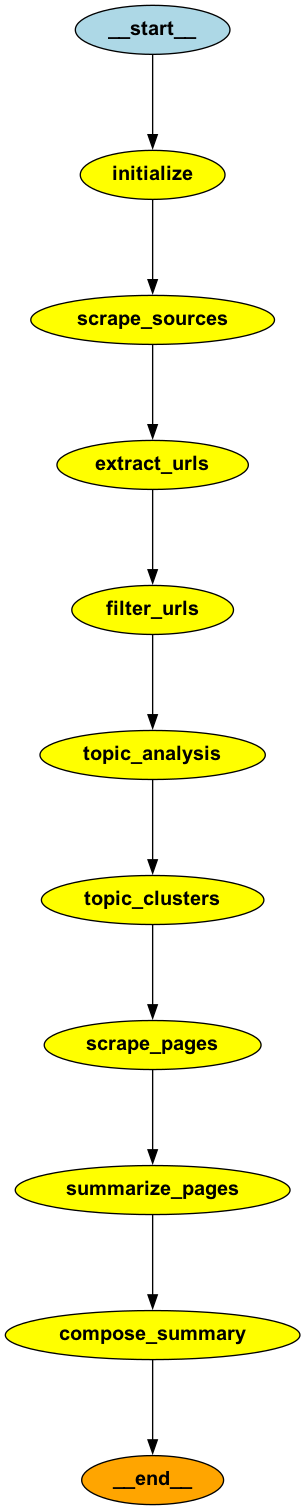

In [25]:
Image(lg_agent.graph.get_graph().draw_png())


In [ ]:
# Configuration with thread ID for checkpointing
config = {"configurable": {"thread_id": "profile-thread-1"}}
# initial state
state = AgentState()
state["AIdf"]=pd.DataFrame()

lg_agent.run(config, state)


'Step 0'

""


2024-07-18 21:00:46,481 - AInewsbot - INFO - Loaded 17 sources from sources.yaml
2024-07-18 21:00:46,482 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-07-18 21:00:46,482 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/technology -> Bloomberg Technology - Bloomberg.html
2024-07-18 21:00:46,482 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Tech - Business Insider.html
2024-07-18 21:00:46,482 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> Technology.html
2024-07-18 21:00:46,483 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Discover and Add New Feedly AI Feeds.html
2024-07-18 21

'Step 1'

""


2024-07-18 21:00:46,526 - AInewsbot - INFO - Saving HTML files using 3 browsers
2024-07-18 21:00:46,528 - AInewsbot - INFO - get_driver - 30309 Initializing webdriver
2024-07-18 21:00:46,528 - AInewsbot - INFO - get_driver - 30309 Initializing webdriver
2024-07-18 21:00:46,528 - AInewsbot - INFO - get_driver - 30309 Initializing webdriver
2024-07-18 21:01:04,103 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-18 21:01:04,103 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-18 21:01:04,103 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-07-18 21:01:04,104 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-07-18 21:01:04,104 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-07-18 21:01:04,105 - AInewsbot - INFO - get_driver - Initialized webdriver service
python(37714) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(37715) MallocStackLogging: